In [4]:
import numpy as np
import matplotlib.pyplot as pl
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras import Sequential, activations, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    BatchNormalization, Activation, SpatialDropout2D, GlobalAveragePooling2D,
    Dense, Dropout, Flatten,
    Conv2D, MaxPooling2D, SeparableConv2D
)
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

# Import project utils scripts
import os
import sys

src_path = os.path.join('../src/')

if src_path not in sys.path:
    sys.path.append(src_path)

from statisticsUtils import recall_precision_fscore_from_confusion_matrix
from labelsUtils import Label
from regionUtils import vietnam_labels_coordinates
from rasterUtils import make_dataset_from_raster_files
from bandUtils import Band
from convNetUtils import (
    cross_validation,
    evaluate_model,
)
from visualizationUtils import (
    plot_confusion_matrix
)

In [3]:
NB_TESTS = 4
EPOCHS = 2000
DATA_ROOT_PATH ='../data/'
LABELS_COORDINATES = vietnam_labels_coordinates()

In [25]:
labels = [
    Label.COFFEE,
    # Label.NATIVEVEGE, now replaced by DENSE_FOREST
    Label.DENSE_FOREST,
    Label.URBAN,
    Label.WATER,
    Label.PEPPER,
    Label.TEA,
]

In [5]:
NB_PIXEL_AROUND=4

bands = [
    Band.COASTAL_AEROSOL.value, 
    Band.BLUE.value, 
    Band.GREEN.value, 
    Band.RED.value, 
    Band.NIR.value, 
    Band.SWIR1.value, 
    Band.SWIR2.value, 
]

# January and february 2017

In [6]:
dataset_args = dict(
    labels = labels,
    raster_paths = [DATA_ROOT_PATH + 'Vietnam_2017_january_february/merged.tif'],
    labels_coordinates_list = [LABELS_COORDINATES],
    nb_pixel_around = NB_PIXEL_AROUND
)

dataset = make_dataset_from_raster_files(**dataset_args)

model_name = "january_february_2017"

# images have all the same shapes, take the shape of the first image
image_width = len(dataset[0][1][0][0])
image_height = len(dataset[0][1][0])
image_depth = len(bands)
nb_outputs = len(labels)

# Create model
model = Sequential([
    Rescaling(1./2**16, input_shape=(image_width, image_height, image_depth)),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),
    SpatialDropout2D(0.25),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(nb_outputs, activation='softmax'),
])

mean_loss, mean_accuracy, histories, conf_matrix = cross_validation(model, dataset, bands, labels, EPOCHS, NB_TESTS, early_stopping=True, with_model_checkpoint=True, model_name=model_name)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 9, 9, 7)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 9, 9, 7)           28        
_________________________________________________________________
conv2d (Conv2D)              (None, 9, 9, 32)          2048      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 32)          9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          3

Epoch 41/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5613 - accuracy: 0.7151 - val_loss: 0.7432 - val_accuracy: 0.7154
Epoch 42/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5583 - accuracy: 0.7032 - val_loss: 0.7510 - val_accuracy: 0.7148
Epoch 43/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5878 - accuracy: 0.7070 - val_loss: 0.7475 - val_accuracy: 0.7089
Epoch 44/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5466 - accuracy: 0.7216 - val_loss: 0.8160 - val_accuracy: 0.6830
Epoch 45/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5253 - accuracy: 0.7358 - val_loss: 0.7640 - val_accuracy: 0.6979
Epoch 46/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5302 - accuracy: 0.7303 - val_loss: 0.8425 - val_accuracy: 0.6720
Epoch 47/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5485 - accuracy: 0.7173 - val_loss: 0.8101 - val_accuracy: 0.6891

57/57 [==============================] - 0s 7ms/step - loss: 0.2886 - accuracy: 0.8329 - val_loss: 0.6318 - val_accuracy: 0.7860
Epoch 156/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2484 - accuracy: 0.8437 - val_loss: 0.7406 - val_accuracy: 0.7575
Epoch 157/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2426 - accuracy: 0.8394 - val_loss: 0.6445 - val_accuracy: 0.7906
Epoch 158/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2661 - accuracy: 0.8405 - val_loss: 0.6927 - val_accuracy: 0.7653
Epoch 159/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2510 - accuracy: 0.8600 - val_loss: 0.7236 - val_accuracy: 0.7887
Epoch 160/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2837 - accuracy: 0.8307 - val_loss: 0.7118 - val_accuracy: 0.7643
Epoch 161/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2362 - accuracy: 0.8470 - val_loss: 0.6418 - val_accuracy: 0.7945
Epoch 1

Epoch 212/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1800 - accuracy: 0.8871 - val_loss: 0.6561 - val_accuracy: 0.8191
Epoch 213/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1865 - accuracy: 0.8817 - val_loss: 0.7178 - val_accuracy: 0.8028
Epoch 214/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1897 - accuracy: 0.8747 - val_loss: 0.6869 - val_accuracy: 0.8013
Epoch 215/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1648 - accuracy: 0.8947 - val_loss: 0.8347 - val_accuracy: 0.7831
Epoch 216/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2230 - accuracy: 0.8568 - val_loss: 0.7201 - val_accuracy: 0.7928
Epoch 217/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1932 - accuracy: 0.8785 - val_loss: 0.8442 - val_accuracy: 0.7762
Epoch 218/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2709 - accuracy: 0.8573 - val_loss: 0.6803 - val_accuracy:

Epoch 269/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1861 - accuracy: 0.8985 - val_loss: 0.7307 - val_accuracy: 0.7947
Epoch 270/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1774 - accuracy: 0.8953 - val_loss: 0.6824 - val_accuracy: 0.8120
Epoch 271/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1519 - accuracy: 0.8969 - val_loss: 0.7155 - val_accuracy: 0.8120
Epoch 272/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1439 - accuracy: 0.9072 - val_loss: 0.6899 - val_accuracy: 0.8192
Epoch 273/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1640 - accuracy: 0.8974 - val_loss: 0.7064 - val_accuracy: 0.8119
Epoch 274/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1438 - accuracy: 0.9105 - val_loss: 0.7829 - val_accuracy: 0.7986
Epoch 275/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1885 - accuracy: 0.8931 - val_loss: 0.7653 - val_accuracy:

Epoch 14/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.8516 - accuracy: 0.6026 - val_loss: 0.9612 - val_accuracy: 0.6506
Epoch 15/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.8503 - accuracy: 0.6107 - val_loss: 0.9895 - val_accuracy: 0.6453
Epoch 16/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.8152 - accuracy: 0.6384 - val_loss: 0.8614 - val_accuracy: 0.6850
Epoch 17/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.8344 - accuracy: 0.6200 - val_loss: 1.0392 - val_accuracy: 0.6052
Epoch 18/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.8117 - accuracy: 0.6374 - val_loss: 0.8805 - val_accuracy: 0.6648
Epoch 19/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.7333 - accuracy: 0.6585 - val_loss: 0.9204 - val_accuracy: 0.6512
Epoch 20/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.7794 - accuracy: 0.6536 - val_loss: 0.8303 - val_accuracy: 0.6940

57/57 [==============================] - 0s 7ms/step - loss: 0.2916 - accuracy: 0.8355 - val_loss: 0.7174 - val_accuracy: 0.7667
Epoch 129/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2781 - accuracy: 0.8350 - val_loss: 0.6634 - val_accuracy: 0.7704
Epoch 130/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2942 - accuracy: 0.8366 - val_loss: 0.7019 - val_accuracy: 0.7537
Epoch 131/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2802 - accuracy: 0.8496 - val_loss: 0.6695 - val_accuracy: 0.7769
Epoch 132/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2844 - accuracy: 0.8491 - val_loss: 0.7684 - val_accuracy: 0.7415
Epoch 133/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2544 - accuracy: 0.8480 - val_loss: 0.6231 - val_accuracy: 0.7799
Epoch 134/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2543 - accuracy: 0.8567 - val_loss: 0.6646 - val_accuracy: 0.7722
Epoch 1

Epoch 185/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2168 - accuracy: 0.8643 - val_loss: 0.6150 - val_accuracy: 0.8112
Epoch 186/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2045 - accuracy: 0.8740 - val_loss: 0.8054 - val_accuracy: 0.7618
Epoch 187/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2229 - accuracy: 0.8621 - val_loss: 0.6832 - val_accuracy: 0.7916
Epoch 188/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2002 - accuracy: 0.8849 - val_loss: 0.6867 - val_accuracy: 0.7997
Epoch 189/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2304 - accuracy: 0.8643 - val_loss: 0.6570 - val_accuracy: 0.7979
Epoch 190/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2316 - accuracy: 0.8686 - val_loss: 0.6577 - val_accuracy: 0.7883
Epoch 191/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2104 - accuracy: 0.8789 - val_loss: 0.6985 - val_accuracy:

Epoch 242/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2119 - accuracy: 0.8903 - val_loss: 0.7130 - val_accuracy: 0.7859
Epoch 243/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1937 - accuracy: 0.8773 - val_loss: 0.6536 - val_accuracy: 0.8150
Epoch 244/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1851 - accuracy: 0.8941 - val_loss: 0.7381 - val_accuracy: 0.7899
Epoch 245/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1538 - accuracy: 0.9055 - val_loss: 0.7729 - val_accuracy: 0.7785
Epoch 246/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1551 - accuracy: 0.9066 - val_loss: 0.7507 - val_accuracy: 0.7845
Epoch 247/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1627 - accuracy: 0.9023 - val_loss: 0.6727 - val_accuracy: 0.8141
Epoch 248/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1519 - accuracy: 0.9115 - val_loss: 0.7803 - val_accuracy:

Epoch 299/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1636 - accuracy: 0.9034 - val_loss: 0.7070 - val_accuracy: 0.8035
Epoch 300/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1423 - accuracy: 0.9077 - val_loss: 0.7295 - val_accuracy: 0.7932
Epoch 301/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1595 - accuracy: 0.9045 - val_loss: 0.7570 - val_accuracy: 0.7951
Epoch 302/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1486 - accuracy: 0.9072 - val_loss: 0.7874 - val_accuracy: 0.8007
Epoch 303/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1592 - accuracy: 0.8985 - val_loss: 0.7855 - val_accuracy: 0.8049
Epoch 304/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2258 - accuracy: 0.8740 - val_loss: 0.6408 - val_accuracy: 0.8019
Epoch 305/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1778 - accuracy: 0.9093 - val_loss: 0.7081 - val_accuracy:

Epoch 356/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1657 - accuracy: 0.9083 - val_loss: 0.8380 - val_accuracy: 0.7860
Epoch 357/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1646 - accuracy: 0.9055 - val_loss: 0.7119 - val_accuracy: 0.8153
Epoch 358/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1180 - accuracy: 0.9213 - val_loss: 0.7327 - val_accuracy: 0.7964
Epoch 359/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1248 - accuracy: 0.9229 - val_loss: 0.7270 - val_accuracy: 0.8065
Epoch 360/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1103 - accuracy: 0.9245 - val_loss: 0.7724 - val_accuracy: 0.8127
Epoch 361/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1176 - accuracy: 0.9343 - val_loss: 0.8249 - val_accuracy: 0.8095
Epoch 362/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1784 - accuracy: 0.9034 - val_loss: 0.7507 - val_accuracy:

Epoch 413/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1579 - accuracy: 0.9159 - val_loss: 0.7564 - val_accuracy: 0.8054
Epoch 414/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1618 - accuracy: 0.9153 - val_loss: 0.8034 - val_accuracy: 0.8064
Epoch 415/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1291 - accuracy: 0.9218 - val_loss: 0.7938 - val_accuracy: 0.8100
Epoch 416/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1460 - accuracy: 0.9191 - val_loss: 0.7147 - val_accuracy: 0.8125
Epoch 417/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1308 - accuracy: 0.9186 - val_loss: 0.7748 - val_accuracy: 0.8016
Epoch 418/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1404 - accuracy: 0.9202 - val_loss: 0.7396 - val_accuracy: 0.8203
Epoch 419/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1418 - accuracy: 0.9245 - val_loss: 0.7726 - val_accuracy:

Epoch 470/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1598 - accuracy: 0.9050 - val_loss: 0.7159 - val_accuracy: 0.8034
Epoch 471/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1516 - accuracy: 0.9180 - val_loss: 0.7694 - val_accuracy: 0.8019
Epoch 472/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1200 - accuracy: 0.9289 - val_loss: 0.7660 - val_accuracy: 0.8145
Epoch 473/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1490 - accuracy: 0.9164 - val_loss: 0.7830 - val_accuracy: 0.7907
Epoch 474/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1327 - accuracy: 0.9175 - val_loss: 0.8416 - val_accuracy: 0.7944
Epoch 475/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1657 - accuracy: 0.9164 - val_loss: 0.7555 - val_accuracy: 0.8065
Epoch 476/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1111 - accuracy: 0.9338 - val_loss: 0.7687 - val_accuracy:

Epoch 527/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1410 - accuracy: 0.9273 - val_loss: 0.8413 - val_accuracy: 0.7879
Epoch 528/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1643 - accuracy: 0.9115 - val_loss: 0.7693 - val_accuracy: 0.8084
Epoch 529/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1281 - accuracy: 0.9289 - val_loss: 0.7397 - val_accuracy: 0.8129
Epoch 530/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1092 - accuracy: 0.9359 - val_loss: 0.7517 - val_accuracy: 0.8103
Epoch 531/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1310 - accuracy: 0.9316 - val_loss: 0.8433 - val_accuracy: 0.7941
Epoch 532/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0983 - accuracy: 0.9343 - val_loss: 0.7659 - val_accuracy: 0.8160
Epoch 533/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1151 - accuracy: 0.9387 - val_loss: 0.7885 - val_accuracy:

Epoch 584/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1202 - accuracy: 0.9300 - val_loss: 0.7863 - val_accuracy: 0.8092
Epoch 585/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1140 - accuracy: 0.9321 - val_loss: 0.7609 - val_accuracy: 0.8077
Epoch 586/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0907 - accuracy: 0.9468 - val_loss: 0.7714 - val_accuracy: 0.8125
Epoch 587/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1246 - accuracy: 0.9359 - val_loss: 0.7778 - val_accuracy: 0.8020
Epoch 588/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0953 - accuracy: 0.9463 - val_loss: 0.7563 - val_accuracy: 0.8148
Epoch 589/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0896 - accuracy: 0.9539 - val_loss: 0.7572 - val_accuracy: 0.8130
Epoch 590/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0973 - accuracy: 0.9419 - val_loss: 0.7909 - val_accuracy:

Epoch 641/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0830 - accuracy: 0.9566 - val_loss: 0.8465 - val_accuracy: 0.8150
Epoch 642/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0992 - accuracy: 0.9441 - val_loss: 0.8372 - val_accuracy: 0.8127
Epoch 643/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1011 - accuracy: 0.9495 - val_loss: 0.9384 - val_accuracy: 0.8004
Epoch 644/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1068 - accuracy: 0.9419 - val_loss: 0.8647 - val_accuracy: 0.8103
Epoch 645/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0924 - accuracy: 0.9473 - val_loss: 0.7752 - val_accuracy: 0.8232
Epoch 646/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1032 - accuracy: 0.9511 - val_loss: 0.9516 - val_accuracy: 0.7884
Epoch 647/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1081 - accuracy: 0.9435 - val_loss: 0.8674 - val_accuracy:

Epoch 36/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5723 - accuracy: 0.7106 - val_loss: 0.7436 - val_accuracy: 0.7118
Epoch 37/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5722 - accuracy: 0.7226 - val_loss: 0.8897 - val_accuracy: 0.6497
Epoch 38/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5906 - accuracy: 0.6992 - val_loss: 0.7304 - val_accuracy: 0.7221
Epoch 39/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5748 - accuracy: 0.7378 - val_loss: 0.8232 - val_accuracy: 0.6826
Epoch 40/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5263 - accuracy: 0.7416 - val_loss: 0.7895 - val_accuracy: 0.6903
Epoch 41/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5572 - accuracy: 0.7237 - val_loss: 0.8625 - val_accuracy: 0.6578
Epoch 42/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5714 - accuracy: 0.7182 - val_loss: 0.8803 - val_accuracy: 0.6698

57/57 [==============================] - 0s 7ms/step - loss: 0.2819 - accuracy: 0.8431 - val_loss: 0.7032 - val_accuracy: 0.7849
Epoch 151/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3107 - accuracy: 0.8377 - val_loss: 0.8277 - val_accuracy: 0.7441
Epoch 152/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2297 - accuracy: 0.8496 - val_loss: 0.7290 - val_accuracy: 0.7750
Epoch 153/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2428 - accuracy: 0.8512 - val_loss: 0.7519 - val_accuracy: 0.7617
Epoch 154/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2245 - accuracy: 0.8681 - val_loss: 0.8046 - val_accuracy: 0.7515
Epoch 155/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2501 - accuracy: 0.8382 - val_loss: 0.6702 - val_accuracy: 0.7950
Epoch 156/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2621 - accuracy: 0.8333 - val_loss: 0.7006 - val_accuracy: 0.7747
Epoch 1

Epoch 207/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2115 - accuracy: 0.8795 - val_loss: 0.7830 - val_accuracy: 0.7621
Epoch 208/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1962 - accuracy: 0.8789 - val_loss: 0.7258 - val_accuracy: 0.7874
Epoch 209/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2142 - accuracy: 0.8762 - val_loss: 0.9067 - val_accuracy: 0.7352
Epoch 210/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2234 - accuracy: 0.8686 - val_loss: 0.8380 - val_accuracy: 0.7620
Epoch 211/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1744 - accuracy: 0.8931 - val_loss: 0.7418 - val_accuracy: 0.7906
Epoch 212/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1848 - accuracy: 0.8958 - val_loss: 0.7191 - val_accuracy: 0.7888
Epoch 213/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2058 - accuracy: 0.8757 - val_loss: 0.7369 - val_accuracy:

Epoch 264/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1403 - accuracy: 0.9121 - val_loss: 0.7476 - val_accuracy: 0.8027
Epoch 265/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1673 - accuracy: 0.8952 - val_loss: 0.7033 - val_accuracy: 0.8173
Epoch 266/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1649 - accuracy: 0.9017 - val_loss: 0.7372 - val_accuracy: 0.8051
Epoch 267/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2068 - accuracy: 0.8817 - val_loss: 0.7358 - val_accuracy: 0.7867
Epoch 268/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1620 - accuracy: 0.8947 - val_loss: 0.7682 - val_accuracy: 0.7966
Epoch 269/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2259 - accuracy: 0.8702 - val_loss: 0.7023 - val_accuracy: 0.7994
Epoch 270/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1550 - accuracy: 0.9121 - val_loss: 0.8327 - val_accuracy:

Epoch 321/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1359 - accuracy: 0.9121 - val_loss: 0.8318 - val_accuracy: 0.7960
Epoch 322/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1752 - accuracy: 0.8887 - val_loss: 0.7971 - val_accuracy: 0.7950
Epoch 323/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1677 - accuracy: 0.9137 - val_loss: 0.8531 - val_accuracy: 0.7863
Epoch 324/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1599 - accuracy: 0.8990 - val_loss: 0.8381 - val_accuracy: 0.7850
Epoch 325/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1347 - accuracy: 0.9175 - val_loss: 0.7987 - val_accuracy: 0.8013
Epoch 326/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1708 - accuracy: 0.8941 - val_loss: 0.8265 - val_accuracy: 0.7894
Epoch 327/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1862 - accuracy: 0.9034 - val_loss: 0.7615 - val_accuracy:

Epoch 31/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6292 - accuracy: 0.7177 - val_loss: 0.7207 - val_accuracy: 0.7358
Epoch 32/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6462 - accuracy: 0.6868 - val_loss: 0.8110 - val_accuracy: 0.6796
Epoch 33/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6319 - accuracy: 0.7182 - val_loss: 0.7708 - val_accuracy: 0.7146
Epoch 34/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5970 - accuracy: 0.7193 - val_loss: 0.8045 - val_accuracy: 0.6882
Epoch 35/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6065 - accuracy: 0.7258 - val_loss: 0.7679 - val_accuracy: 0.7141
Epoch 36/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5790 - accuracy: 0.7324 - val_loss: 0.8980 - val_accuracy: 0.6572
Epoch 37/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5955 - accuracy: 0.7242 - val_loss: 0.7075 - val_accuracy: 0.7358

57/57 [==============================] - 0s 8ms/step - loss: 0.2937 - accuracy: 0.8426 - val_loss: 0.6773 - val_accuracy: 0.7811
Epoch 146/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2776 - accuracy: 0.8572 - val_loss: 0.6055 - val_accuracy: 0.7956
Epoch 147/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2962 - accuracy: 0.8442 - val_loss: 0.7361 - val_accuracy: 0.7511
Epoch 148/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2529 - accuracy: 0.8583 - val_loss: 0.6491 - val_accuracy: 0.7830
Epoch 149/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2411 - accuracy: 0.8572 - val_loss: 0.6699 - val_accuracy: 0.7871
Epoch 150/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2511 - accuracy: 0.8431 - val_loss: 0.6713 - val_accuracy: 0.7812
Epoch 151/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2388 - accuracy: 0.8599 - val_loss: 0.6778 - val_accuracy: 0.7853
Epoch 1

Epoch 202/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1797 - accuracy: 0.8855 - val_loss: 0.6900 - val_accuracy: 0.7964
Epoch 203/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2070 - accuracy: 0.8800 - val_loss: 0.6716 - val_accuracy: 0.7818
Epoch 204/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2378 - accuracy: 0.8730 - val_loss: 0.6797 - val_accuracy: 0.7910
Epoch 205/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1810 - accuracy: 0.8898 - val_loss: 0.7343 - val_accuracy: 0.7891
Epoch 206/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2481 - accuracy: 0.8626 - val_loss: 0.7830 - val_accuracy: 0.7791
Epoch 207/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2388 - accuracy: 0.8664 - val_loss: 0.6870 - val_accuracy: 0.7875
Epoch 208/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2198 - accuracy: 0.8708 - val_loss: 0.6507 - val_accuracy:

Epoch 259/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1525 - accuracy: 0.9153 - val_loss: 0.7437 - val_accuracy: 0.7956
Epoch 260/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1784 - accuracy: 0.8985 - val_loss: 0.7610 - val_accuracy: 0.7939
Epoch 261/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1991 - accuracy: 0.8838 - val_loss: 0.6998 - val_accuracy: 0.7921
Epoch 262/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1640 - accuracy: 0.9039 - val_loss: 0.6806 - val_accuracy: 0.8114
Epoch 263/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2131 - accuracy: 0.8882 - val_loss: 0.7052 - val_accuracy: 0.7997
Epoch 264/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1724 - accuracy: 0.8947 - val_loss: 0.6725 - val_accuracy: 0.8097
Epoch 265/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1958 - accuracy: 0.8838 - val_loss: 0.7350 - val_accuracy:

Epoch 316/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1295 - accuracy: 0.9218 - val_loss: 0.8097 - val_accuracy: 0.7948
Epoch 317/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1726 - accuracy: 0.9028 - val_loss: 0.7692 - val_accuracy: 0.8016
Epoch 318/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1411 - accuracy: 0.9256 - val_loss: 0.7720 - val_accuracy: 0.8089
Epoch 319/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1992 - accuracy: 0.9012 - val_loss: 0.7492 - val_accuracy: 0.8077
Epoch 320/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1714 - accuracy: 0.8985 - val_loss: 0.7287 - val_accuracy: 0.8012
Epoch 321/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1550 - accuracy: 0.9175 - val_loss: 0.8483 - val_accuracy: 0.7931
Epoch 322/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1518 - accuracy: 0.9045 - val_loss: 0.8451 - val_accuracy:

Epoch 373/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1533 - accuracy: 0.9175 - val_loss: 0.7500 - val_accuracy: 0.7935
Epoch 374/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1261 - accuracy: 0.9267 - val_loss: 0.7573 - val_accuracy: 0.8085
Epoch 375/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1307 - accuracy: 0.9240 - val_loss: 0.8879 - val_accuracy: 0.7670
Epoch 376/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1287 - accuracy: 0.9256 - val_loss: 0.9090 - val_accuracy: 0.7723
Epoch 377/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1639 - accuracy: 0.9121 - val_loss: 0.8173 - val_accuracy: 0.7922
Epoch 378/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1740 - accuracy: 0.9017 - val_loss: 0.8336 - val_accuracy: 0.7743
Epoch 379/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1890 - accuracy: 0.9061 - val_loss: 0.8186 - val_accuracy:

Epoch 31/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6272 - accuracy: 0.6808 - val_loss: 0.8595 - val_accuracy: 0.6506
Epoch 32/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6315 - accuracy: 0.6678 - val_loss: 0.7269 - val_accuracy: 0.7173
Epoch 33/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6107 - accuracy: 0.6906 - val_loss: 0.7718 - val_accuracy: 0.6956
Epoch 34/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6306 - accuracy: 0.6813 - val_loss: 0.8324 - val_accuracy: 0.6845
Epoch 35/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6245 - accuracy: 0.6889 - val_loss: 0.7161 - val_accuracy: 0.7366
Epoch 36/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6068 - accuracy: 0.7009 - val_loss: 0.8018 - val_accuracy: 0.6829
Epoch 37/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5806 - accuracy: 0.7063 - val_loss: 0.7896 - val_accuracy: 0.7009

57/57 [==============================] - 0s 7ms/step - loss: 0.2687 - accuracy: 0.8480 - val_loss: 0.6753 - val_accuracy: 0.7780
Epoch 146/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2333 - accuracy: 0.8561 - val_loss: 0.7446 - val_accuracy: 0.7781
Epoch 147/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2625 - accuracy: 0.8426 - val_loss: 0.7244 - val_accuracy: 0.7613
Epoch 148/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2956 - accuracy: 0.8306 - val_loss: 0.7157 - val_accuracy: 0.7723
Epoch 149/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2572 - accuracy: 0.8502 - val_loss: 0.7463 - val_accuracy: 0.7487
Epoch 150/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2582 - accuracy: 0.8556 - val_loss: 0.7679 - val_accuracy: 0.7610
Epoch 151/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2399 - accuracy: 0.8588 - val_loss: 0.7042 - val_accuracy: 0.7715
Epoch 1

Epoch 202/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2189 - accuracy: 0.8719 - val_loss: 0.7185 - val_accuracy: 0.7967
Epoch 203/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2136 - accuracy: 0.8724 - val_loss: 0.6810 - val_accuracy: 0.7913
Epoch 204/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2079 - accuracy: 0.8724 - val_loss: 0.7768 - val_accuracy: 0.7709
Epoch 205/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2217 - accuracy: 0.8719 - val_loss: 0.7127 - val_accuracy: 0.7785
Epoch 206/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1831 - accuracy: 0.8871 - val_loss: 0.7577 - val_accuracy: 0.7704
Epoch 207/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2162 - accuracy: 0.8757 - val_loss: 0.7447 - val_accuracy: 0.7761
Epoch 208/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2084 - accuracy: 0.8838 - val_loss: 0.7425 - val_accuracy:

Epoch 42/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5744 - accuracy: 0.7412 - val_loss: 0.8795 - val_accuracy: 0.6566
Epoch 43/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5769 - accuracy: 0.7211 - val_loss: 0.7897 - val_accuracy: 0.6971
Epoch 44/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5527 - accuracy: 0.7206 - val_loss: 0.7404 - val_accuracy: 0.7129
Epoch 45/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5424 - accuracy: 0.7374 - val_loss: 0.7551 - val_accuracy: 0.7129
Epoch 46/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5409 - accuracy: 0.7363 - val_loss: 0.7709 - val_accuracy: 0.7119
Epoch 47/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5461 - accuracy: 0.7406 - val_loss: 0.7472 - val_accuracy: 0.7150
Epoch 48/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5273 - accuracy: 0.7309 - val_loss: 0.7748 - val_accuracy: 0.7144

Epoch 156/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2583 - accuracy: 0.8557 - val_loss: 0.7069 - val_accuracy: 0.7720
Epoch 157/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2497 - accuracy: 0.8530 - val_loss: 0.7391 - val_accuracy: 0.7617
Epoch 158/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2569 - accuracy: 0.8470 - val_loss: 0.6124 - val_accuracy: 0.7993
Epoch 159/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2136 - accuracy: 0.8681 - val_loss: 0.6257 - val_accuracy: 0.8066
Epoch 160/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2363 - accuracy: 0.8578 - val_loss: 0.7816 - val_accuracy: 0.7531
Epoch 161/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2757 - accuracy: 0.8361 - val_loss: 0.7375 - val_accuracy: 0.7668
Epoch 162/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2158 - accuracy: 0.8660 - val_loss: 0.6927 - val_accuracy:

Epoch 213/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1790 - accuracy: 0.8942 - val_loss: 0.8019 - val_accuracy: 0.7697
Epoch 214/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1803 - accuracy: 0.8709 - val_loss: 0.6988 - val_accuracy: 0.8037
Epoch 215/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1872 - accuracy: 0.8893 - val_loss: 0.6895 - val_accuracy: 0.8074
Epoch 216/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1605 - accuracy: 0.8969 - val_loss: 0.6924 - val_accuracy: 0.8039
Epoch 217/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2060 - accuracy: 0.8823 - val_loss: 0.6668 - val_accuracy: 0.8070
Epoch 218/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1910 - accuracy: 0.8893 - val_loss: 0.6614 - val_accuracy: 0.8162
Epoch 219/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1681 - accuracy: 0.9050 - val_loss: 0.7072 - val_accuracy:

Epoch 270/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1642 - accuracy: 0.9088 - val_loss: 0.7822 - val_accuracy: 0.7959
Epoch 271/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1711 - accuracy: 0.9034 - val_loss: 0.6536 - val_accuracy: 0.8191
Epoch 272/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1414 - accuracy: 0.9202 - val_loss: 0.7145 - val_accuracy: 0.8063
Epoch 273/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1778 - accuracy: 0.9056 - val_loss: 0.7024 - val_accuracy: 0.7998
Epoch 274/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1739 - accuracy: 0.8947 - val_loss: 0.7142 - val_accuracy: 0.7966
Epoch 275/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1462 - accuracy: 0.9105 - val_loss: 0.7316 - val_accuracy: 0.8145
Epoch 276/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2372 - accuracy: 0.8741 - val_loss: 0.9464 - val_accuracy:

Epoch 327/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1700 - accuracy: 0.9007 - val_loss: 0.7017 - val_accuracy: 0.8058
Epoch 328/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1353 - accuracy: 0.9192 - val_loss: 0.7887 - val_accuracy: 0.7999
Epoch 329/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1664 - accuracy: 0.9126 - val_loss: 0.7419 - val_accuracy: 0.8016
Epoch 330/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1700 - accuracy: 0.9040 - val_loss: 0.7346 - val_accuracy: 0.8147
Epoch 331/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1813 - accuracy: 0.8931 - val_loss: 0.7560 - val_accuracy: 0.7951
Epoch 332/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1257 - accuracy: 0.9289 - val_loss: 0.8317 - val_accuracy: 0.7968
Epoch 333/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1626 - accuracy: 0.9110 - val_loss: 0.7087 - val_accuracy:

Epoch 384/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1184 - accuracy: 0.9267 - val_loss: 0.7582 - val_accuracy: 0.8196
Epoch 385/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0890 - accuracy: 0.9392 - val_loss: 0.7597 - val_accuracy: 0.8276
Epoch 386/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1252 - accuracy: 0.9316 - val_loss: 0.7547 - val_accuracy: 0.8161
Epoch 387/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1225 - accuracy: 0.9338 - val_loss: 0.7964 - val_accuracy: 0.8118
Epoch 388/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1404 - accuracy: 0.9208 - val_loss: 0.7366 - val_accuracy: 0.8187
Epoch 389/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1762 - accuracy: 0.9148 - val_loss: 0.7337 - val_accuracy: 0.7952
Epoch 390/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1247 - accuracy: 0.9267 - val_loss: 0.7747 - val_accuracy:

Epoch 441/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1088 - accuracy: 0.9278 - val_loss: 0.8016 - val_accuracy: 0.8151
Epoch 442/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0923 - accuracy: 0.9409 - val_loss: 0.8531 - val_accuracy: 0.8168
Epoch 443/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0983 - accuracy: 0.9387 - val_loss: 0.8025 - val_accuracy: 0.8172
Epoch 444/2000
57/57 [==============================] - 0s 6ms/step - loss: 0.1363 - accuracy: 0.9202 - val_loss: 0.7870 - val_accuracy: 0.8115
Epoch 445/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1307 - accuracy: 0.9295 - val_loss: 0.8322 - val_accuracy: 0.8043
Epoch 446/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1143 - accuracy: 0.9447 - val_loss: 0.8305 - val_accuracy: 0.8023
Epoch 447/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1211 - accuracy: 0.9376 - val_loss: 0.7510 - val_accuracy:

Epoch 498/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0932 - accuracy: 0.9474 - val_loss: 0.8808 - val_accuracy: 0.8097
Epoch 499/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1397 - accuracy: 0.9197 - val_loss: 0.8925 - val_accuracy: 0.7913
Epoch 500/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1593 - accuracy: 0.9170 - val_loss: 0.7693 - val_accuracy: 0.8108
Epoch 501/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1186 - accuracy: 0.9392 - val_loss: 0.8548 - val_accuracy: 0.8130
Epoch 502/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1136 - accuracy: 0.9430 - val_loss: 0.8473 - val_accuracy: 0.8103
Epoch 503/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0896 - accuracy: 0.9463 - val_loss: 0.8097 - val_accuracy: 0.8272
Epoch 504/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1422 - accuracy: 0.9240 - val_loss: 0.8358 - val_accuracy:

Epoch 32/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6118 - accuracy: 0.7074 - val_loss: 0.7369 - val_accuracy: 0.7270
Epoch 33/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6441 - accuracy: 0.6906 - val_loss: 0.7896 - val_accuracy: 0.6911
Epoch 34/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6204 - accuracy: 0.6987 - val_loss: 0.7491 - val_accuracy: 0.7192
Epoch 35/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6187 - accuracy: 0.7003 - val_loss: 0.7523 - val_accuracy: 0.6975
Epoch 36/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5994 - accuracy: 0.7128 - val_loss: 0.7987 - val_accuracy: 0.6891
Epoch 37/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6229 - accuracy: 0.7090 - val_loss: 0.8066 - val_accuracy: 0.6891
Epoch 38/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5995 - accuracy: 0.6944 - val_loss: 0.8242 - val_accuracy: 0.6797

57/57 [==============================] - 0s 7ms/step - loss: 0.2737 - accuracy: 0.8464 - val_loss: 0.6540 - val_accuracy: 0.7838
Epoch 147/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2314 - accuracy: 0.8572 - val_loss: 0.6823 - val_accuracy: 0.7841
Epoch 148/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2440 - accuracy: 0.8588 - val_loss: 0.6610 - val_accuracy: 0.7943
Epoch 149/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2976 - accuracy: 0.8371 - val_loss: 0.7072 - val_accuracy: 0.7621
Epoch 150/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2976 - accuracy: 0.8458 - val_loss: 0.7862 - val_accuracy: 0.7397
Epoch 151/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2660 - accuracy: 0.8453 - val_loss: 0.7597 - val_accuracy: 0.7614
Epoch 152/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3276 - accuracy: 0.8241 - val_loss: 0.7363 - val_accuracy: 0.7621
Epoch 1

Epoch 203/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1851 - accuracy: 0.8844 - val_loss: 0.7159 - val_accuracy: 0.8046
Epoch 204/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2146 - accuracy: 0.8735 - val_loss: 0.8059 - val_accuracy: 0.7850
Epoch 205/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2372 - accuracy: 0.8675 - val_loss: 0.7133 - val_accuracy: 0.7924
Epoch 206/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2268 - accuracy: 0.8822 - val_loss: 0.7246 - val_accuracy: 0.7791
Epoch 207/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2100 - accuracy: 0.8784 - val_loss: 0.6853 - val_accuracy: 0.7974
Epoch 208/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1981 - accuracy: 0.8762 - val_loss: 0.7084 - val_accuracy: 0.7988
Epoch 209/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1890 - accuracy: 0.8811 - val_loss: 0.7845 - val_accuracy:

Epoch 260/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2196 - accuracy: 0.8849 - val_loss: 0.7226 - val_accuracy: 0.7939
Epoch 261/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1828 - accuracy: 0.9007 - val_loss: 0.7616 - val_accuracy: 0.7910
Epoch 262/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2023 - accuracy: 0.8844 - val_loss: 0.7937 - val_accuracy: 0.7825
Epoch 263/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1548 - accuracy: 0.9061 - val_loss: 0.7482 - val_accuracy: 0.8031
Epoch 264/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1795 - accuracy: 0.8887 - val_loss: 0.7550 - val_accuracy: 0.8047
Epoch 265/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1733 - accuracy: 0.9012 - val_loss: 0.7335 - val_accuracy: 0.8099
Epoch 266/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1667 - accuracy: 0.8952 - val_loss: 0.7429 - val_accuracy:

Epoch 317/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1836 - accuracy: 0.9077 - val_loss: 0.7593 - val_accuracy: 0.7948
Epoch 318/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1416 - accuracy: 0.9110 - val_loss: 0.7820 - val_accuracy: 0.7958
Epoch 319/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1924 - accuracy: 0.8969 - val_loss: 0.7412 - val_accuracy: 0.8093
Epoch 320/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1607 - accuracy: 0.8974 - val_loss: 0.7936 - val_accuracy: 0.7772
Epoch 321/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1911 - accuracy: 0.8941 - val_loss: 0.8558 - val_accuracy: 0.7817
Epoch 322/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2038 - accuracy: 0.8925 - val_loss: 0.7197 - val_accuracy: 0.8066
Epoch 323/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1932 - accuracy: 0.8855 - val_loss: 0.7776 - val_accuracy:

Epoch 36/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5731 - accuracy: 0.7188 - val_loss: 0.7896 - val_accuracy: 0.6953
Epoch 37/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6634 - accuracy: 0.6900 - val_loss: 0.7475 - val_accuracy: 0.7108
Epoch 38/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6197 - accuracy: 0.7117 - val_loss: 0.8189 - val_accuracy: 0.6891
Epoch 39/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6032 - accuracy: 0.7367 - val_loss: 0.8912 - val_accuracy: 0.6567
Epoch 40/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5404 - accuracy: 0.7275 - val_loss: 0.7499 - val_accuracy: 0.7138
Epoch 41/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5692 - accuracy: 0.7367 - val_loss: 0.8024 - val_accuracy: 0.6941
Epoch 42/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5601 - accuracy: 0.7356 - val_loss: 0.8588 - val_accuracy: 0.6834

57/57 [==============================] - 0s 7ms/step - loss: 0.2560 - accuracy: 0.8610 - val_loss: 0.6835 - val_accuracy: 0.7912
Epoch 151/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2654 - accuracy: 0.8458 - val_loss: 0.7674 - val_accuracy: 0.7500
Epoch 152/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2373 - accuracy: 0.8621 - val_loss: 0.6572 - val_accuracy: 0.7910
Epoch 153/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2275 - accuracy: 0.8768 - val_loss: 0.7367 - val_accuracy: 0.7698
Epoch 154/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1962 - accuracy: 0.8860 - val_loss: 0.6696 - val_accuracy: 0.7925
Epoch 155/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2098 - accuracy: 0.8795 - val_loss: 0.6590 - val_accuracy: 0.7931
Epoch 156/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2219 - accuracy: 0.8719 - val_loss: 0.7735 - val_accuracy: 0.7418
Epoch 1

Epoch 207/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2028 - accuracy: 0.8958 - val_loss: 0.6985 - val_accuracy: 0.7925
Epoch 208/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1883 - accuracy: 0.8844 - val_loss: 0.6901 - val_accuracy: 0.8088
Epoch 209/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1887 - accuracy: 0.8740 - val_loss: 0.6474 - val_accuracy: 0.8059
Epoch 210/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1753 - accuracy: 0.8969 - val_loss: 0.6550 - val_accuracy: 0.8088
Epoch 211/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1641 - accuracy: 0.9028 - val_loss: 0.7327 - val_accuracy: 0.7926
Epoch 212/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1764 - accuracy: 0.8871 - val_loss: 0.6939 - val_accuracy: 0.8084
Epoch 213/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1914 - accuracy: 0.8827 - val_loss: 0.7535 - val_accuracy:

Epoch 264/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1666 - accuracy: 0.9034 - val_loss: 0.7188 - val_accuracy: 0.7970
Epoch 265/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1847 - accuracy: 0.8903 - val_loss: 0.7497 - val_accuracy: 0.7898
Epoch 266/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1997 - accuracy: 0.8833 - val_loss: 0.7154 - val_accuracy: 0.8012
Epoch 267/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1895 - accuracy: 0.9028 - val_loss: 0.6628 - val_accuracy: 0.8116
Epoch 268/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1353 - accuracy: 0.9104 - val_loss: 0.7350 - val_accuracy: 0.8038
Epoch 269/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2065 - accuracy: 0.8860 - val_loss: 0.7029 - val_accuracy: 0.7992
Epoch 270/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1594 - accuracy: 0.9028 - val_loss: 0.7839 - val_accuracy:

Epoch 321/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1410 - accuracy: 0.9186 - val_loss: 0.7629 - val_accuracy: 0.8144
Epoch 322/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1220 - accuracy: 0.9197 - val_loss: 0.7592 - val_accuracy: 0.8249
Epoch 323/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2450 - accuracy: 0.8931 - val_loss: 0.7900 - val_accuracy: 0.7738
Epoch 324/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1894 - accuracy: 0.8936 - val_loss: 0.7954 - val_accuracy: 0.7932
Epoch 325/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2011 - accuracy: 0.8914 - val_loss: 0.7499 - val_accuracy: 0.7906
Epoch 326/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1474 - accuracy: 0.9066 - val_loss: 0.7028 - val_accuracy: 0.8087
Epoch 327/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1459 - accuracy: 0.9186 - val_loss: 0.7395 - val_accuracy:

Epoch 378/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1098 - accuracy: 0.9273 - val_loss: 0.7649 - val_accuracy: 0.8096
Epoch 379/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1440 - accuracy: 0.9278 - val_loss: 0.7933 - val_accuracy: 0.7948
Epoch 380/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1366 - accuracy: 0.9180 - val_loss: 0.8867 - val_accuracy: 0.7917
Epoch 381/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1193 - accuracy: 0.9207 - val_loss: 0.8236 - val_accuracy: 0.8076
Epoch 382/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1344 - accuracy: 0.9251 - val_loss: 0.8267 - val_accuracy: 0.8015
Epoch 383/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1409 - accuracy: 0.9202 - val_loss: 0.7771 - val_accuracy: 0.7981
Epoch 384/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1364 - accuracy: 0.9218 - val_loss: 0.7557 - val_accuracy:

57/57 [==============================] - 0s 7ms/step - loss: 0.4158 - accuracy: 0.7780 - val_loss: 0.7119 - val_accuracy: 0.7336
Epoch 70/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4361 - accuracy: 0.7839 - val_loss: 0.6977 - val_accuracy: 0.7337
Epoch 71/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4547 - accuracy: 0.7709 - val_loss: 0.8475 - val_accuracy: 0.6750
Epoch 72/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4620 - accuracy: 0.7573 - val_loss: 0.6800 - val_accuracy: 0.7494
Epoch 73/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4458 - accuracy: 0.7796 - val_loss: 0.7968 - val_accuracy: 0.7040
Epoch 74/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4421 - accuracy: 0.7720 - val_loss: 0.6999 - val_accuracy: 0.7325
Epoch 75/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4652 - accuracy: 0.7633 - val_loss: 0.6736 - val_accuracy: 0.7369
Epoch 76/2000

Epoch 183/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2100 - accuracy: 0.8757 - val_loss: 0.7374 - val_accuracy: 0.7722
Epoch 184/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1940 - accuracy: 0.8860 - val_loss: 0.7754 - val_accuracy: 0.7798
Epoch 185/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2065 - accuracy: 0.8882 - val_loss: 0.7978 - val_accuracy: 0.7618
Epoch 186/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1867 - accuracy: 0.8768 - val_loss: 0.7923 - val_accuracy: 0.7815
Epoch 187/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2050 - accuracy: 0.8822 - val_loss: 0.7004 - val_accuracy: 0.7963
Epoch 188/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2116 - accuracy: 0.8822 - val_loss: 0.8488 - val_accuracy: 0.7533
Epoch 189/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2281 - accuracy: 0.8762 - val_loss: 0.6922 - val_accuracy:

Epoch 240/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1710 - accuracy: 0.9012 - val_loss: 0.7975 - val_accuracy: 0.7818
Epoch 241/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1550 - accuracy: 0.9077 - val_loss: 0.7209 - val_accuracy: 0.8002
Epoch 242/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1939 - accuracy: 0.8936 - val_loss: 0.7605 - val_accuracy: 0.7921
Epoch 243/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1859 - accuracy: 0.8985 - val_loss: 0.7521 - val_accuracy: 0.7781
Epoch 244/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2111 - accuracy: 0.8963 - val_loss: 0.8166 - val_accuracy: 0.7692
Epoch 245/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1909 - accuracy: 0.8903 - val_loss: 0.6752 - val_accuracy: 0.8081
Epoch 246/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1749 - accuracy: 0.8979 - val_loss: 0.7006 - val_accuracy:

Epoch 297/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1872 - accuracy: 0.8990 - val_loss: 0.7804 - val_accuracy: 0.7829
Epoch 298/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1567 - accuracy: 0.9061 - val_loss: 0.8104 - val_accuracy: 0.7863
Epoch 299/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1546 - accuracy: 0.9164 - val_loss: 0.8329 - val_accuracy: 0.7880
Epoch 300/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1682 - accuracy: 0.9045 - val_loss: 0.8076 - val_accuracy: 0.7940
Epoch 301/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1271 - accuracy: 0.9218 - val_loss: 0.8580 - val_accuracy: 0.7776
Epoch 302/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1822 - accuracy: 0.9012 - val_loss: 0.8537 - val_accuracy: 0.7793
Epoch 303/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1434 - accuracy: 0.9077 - val_loss: 0.8596 - val_accuracy:

57/57 [==============================] - 0s 7ms/step - loss: 0.4403 - accuracy: 0.7557 - val_loss: 0.7970 - val_accuracy: 0.6959
Epoch 66/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4294 - accuracy: 0.7709 - val_loss: 0.6235 - val_accuracy: 0.7712
Epoch 67/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4248 - accuracy: 0.7769 - val_loss: 0.6530 - val_accuracy: 0.7575
Epoch 68/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4422 - accuracy: 0.7823 - val_loss: 0.7776 - val_accuracy: 0.7084
Epoch 69/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3914 - accuracy: 0.7942 - val_loss: 0.6233 - val_accuracy: 0.7708
Epoch 70/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4114 - accuracy: 0.7660 - val_loss: 0.7786 - val_accuracy: 0.7279
Epoch 71/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4438 - accuracy: 0.7676 - val_loss: 0.6654 - val_accuracy: 0.7553
Epoch 72/2000

Epoch 179/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2098 - accuracy: 0.8735 - val_loss: 0.7413 - val_accuracy: 0.7749
Epoch 180/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2041 - accuracy: 0.8675 - val_loss: 0.6860 - val_accuracy: 0.7996
Epoch 181/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1811 - accuracy: 0.8838 - val_loss: 0.7835 - val_accuracy: 0.7727
Epoch 182/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2311 - accuracy: 0.8648 - val_loss: 0.7482 - val_accuracy: 0.7798
Epoch 183/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2161 - accuracy: 0.8740 - val_loss: 0.7436 - val_accuracy: 0.7738
Epoch 184/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2245 - accuracy: 0.8599 - val_loss: 0.7091 - val_accuracy: 0.7720
Epoch 185/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2108 - accuracy: 0.8670 - val_loss: 0.6518 - val_accuracy:

Epoch 236/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2123 - accuracy: 0.8833 - val_loss: 0.6907 - val_accuracy: 0.8007
Epoch 237/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1684 - accuracy: 0.8963 - val_loss: 0.7082 - val_accuracy: 0.7973
Epoch 238/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1895 - accuracy: 0.8811 - val_loss: 0.7374 - val_accuracy: 0.7860
Epoch 239/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2036 - accuracy: 0.8844 - val_loss: 0.7128 - val_accuracy: 0.7941
Epoch 240/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1840 - accuracy: 0.8779 - val_loss: 0.6894 - val_accuracy: 0.7917
Epoch 241/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1812 - accuracy: 0.8958 - val_loss: 0.7644 - val_accuracy: 0.7840
Epoch 242/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1735 - accuracy: 0.8844 - val_loss: 0.7657 - val_accuracy:

Epoch 293/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1384 - accuracy: 0.9153 - val_loss: 0.7425 - val_accuracy: 0.8072
Epoch 294/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1793 - accuracy: 0.8871 - val_loss: 0.7179 - val_accuracy: 0.7945
Epoch 295/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1859 - accuracy: 0.8996 - val_loss: 0.7684 - val_accuracy: 0.7937
Epoch 296/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2086 - accuracy: 0.8903 - val_loss: 0.7722 - val_accuracy: 0.7989
Epoch 297/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1734 - accuracy: 0.8963 - val_loss: 0.7285 - val_accuracy: 0.7947
Epoch 298/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2067 - accuracy: 0.8914 - val_loss: 0.6764 - val_accuracy: 0.8194
Epoch 299/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1869 - accuracy: 0.8936 - val_loss: 0.7501 - val_accuracy:

Epoch 350/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1595 - accuracy: 0.9061 - val_loss: 0.6974 - val_accuracy: 0.8097
Epoch 351/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1357 - accuracy: 0.9175 - val_loss: 0.7013 - val_accuracy: 0.8152
Epoch 352/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1693 - accuracy: 0.9104 - val_loss: 0.7950 - val_accuracy: 0.7834
Epoch 353/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1213 - accuracy: 0.9240 - val_loss: 0.7317 - val_accuracy: 0.8068
Epoch 354/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1339 - accuracy: 0.9202 - val_loss: 0.8299 - val_accuracy: 0.7912
Epoch 355/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1729 - accuracy: 0.9066 - val_loss: 0.7119 - val_accuracy: 0.8146
Epoch 356/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1237 - accuracy: 0.9332 - val_loss: 0.7336 - val_accuracy:

57/57 [==============================] - 0s 7ms/step - loss: 0.4344 - accuracy: 0.7618 - val_loss: 0.7594 - val_accuracy: 0.7170
Epoch 66/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4463 - accuracy: 0.7591 - val_loss: 0.7363 - val_accuracy: 0.7200
Epoch 67/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4087 - accuracy: 0.7792 - val_loss: 0.7386 - val_accuracy: 0.7291
Epoch 68/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3665 - accuracy: 0.7830 - val_loss: 0.6797 - val_accuracy: 0.7545
Epoch 69/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3963 - accuracy: 0.7786 - val_loss: 0.6950 - val_accuracy: 0.7476
Epoch 70/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3866 - accuracy: 0.7933 - val_loss: 0.6356 - val_accuracy: 0.7685
Epoch 71/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4180 - accuracy: 0.7922 - val_loss: 0.7069 - val_accuracy: 0.7406
Epoch 72/2000

Epoch 179/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2231 - accuracy: 0.8866 - val_loss: 0.6643 - val_accuracy: 0.8067
Epoch 180/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2717 - accuracy: 0.8416 - val_loss: 0.7015 - val_accuracy: 0.7834
Epoch 181/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2339 - accuracy: 0.8660 - val_loss: 0.6548 - val_accuracy: 0.8044
Epoch 182/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2159 - accuracy: 0.8644 - val_loss: 0.7134 - val_accuracy: 0.7861
Epoch 183/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1977 - accuracy: 0.8763 - val_loss: 0.8129 - val_accuracy: 0.7693
Epoch 184/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2422 - accuracy: 0.8600 - val_loss: 0.7213 - val_accuracy: 0.7872
Epoch 185/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2107 - accuracy: 0.8730 - val_loss: 0.7380 - val_accuracy:

Epoch 236/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1691 - accuracy: 0.8893 - val_loss: 0.7677 - val_accuracy: 0.7944
Epoch 237/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1705 - accuracy: 0.8817 - val_loss: 0.7604 - val_accuracy: 0.7933
Epoch 238/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1748 - accuracy: 0.8985 - val_loss: 0.7058 - val_accuracy: 0.8160
Epoch 239/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1943 - accuracy: 0.8958 - val_loss: 0.7697 - val_accuracy: 0.7879
Epoch 240/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1889 - accuracy: 0.8839 - val_loss: 0.8049 - val_accuracy: 0.7717
Epoch 241/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2160 - accuracy: 0.8909 - val_loss: 0.6837 - val_accuracy: 0.7980
Epoch 242/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1821 - accuracy: 0.8991 - val_loss: 0.8084 - val_accuracy:

Epoch 293/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1785 - accuracy: 0.8920 - val_loss: 0.7316 - val_accuracy: 0.8008
Epoch 294/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1473 - accuracy: 0.9007 - val_loss: 0.7631 - val_accuracy: 0.7940
Epoch 295/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1316 - accuracy: 0.9137 - val_loss: 0.7251 - val_accuracy: 0.8217
Epoch 296/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1661 - accuracy: 0.9045 - val_loss: 0.8348 - val_accuracy: 0.7896
Epoch 297/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1589 - accuracy: 0.8985 - val_loss: 0.7500 - val_accuracy: 0.8014
Epoch 298/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1298 - accuracy: 0.9262 - val_loss: 0.8509 - val_accuracy: 0.8043
Epoch 299/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1740 - accuracy: 0.9110 - val_loss: 0.7991 - val_accuracy:

Epoch 350/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1300 - accuracy: 0.9175 - val_loss: 0.8395 - val_accuracy: 0.7971
Epoch 351/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1230 - accuracy: 0.9246 - val_loss: 0.8581 - val_accuracy: 0.7986
Epoch 352/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1281 - accuracy: 0.9246 - val_loss: 0.8299 - val_accuracy: 0.8080
Epoch 353/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1357 - accuracy: 0.9083 - val_loss: 0.8732 - val_accuracy: 0.7898
Epoch 354/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1809 - accuracy: 0.9126 - val_loss: 0.8392 - val_accuracy: 0.7983
Epoch 355/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1184 - accuracy: 0.9197 - val_loss: 0.8783 - val_accuracy: 0.7896
Epoch 356/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1462 - accuracy: 0.9159 - val_loss: 0.7598 - val_accuracy:

Epoch 407/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1229 - accuracy: 0.9197 - val_loss: 0.8358 - val_accuracy: 0.8010
Epoch 408/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1231 - accuracy: 0.9230 - val_loss: 0.7568 - val_accuracy: 0.8191
Epoch 409/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1602 - accuracy: 0.9121 - val_loss: 0.7461 - val_accuracy: 0.8128
Epoch 410/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1262 - accuracy: 0.9230 - val_loss: 0.7868 - val_accuracy: 0.8078
Epoch 411/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1858 - accuracy: 0.9007 - val_loss: 0.7034 - val_accuracy: 0.8213
Epoch 412/2000
57/57 [==============================] - 0s 6ms/step - loss: 0.0997 - accuracy: 0.9398 - val_loss: 0.8445 - val_accuracy: 0.7982
Epoch 413/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1287 - accuracy: 0.9278 - val_loss: 0.7921 - val_accuracy:

Epoch 464/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1084 - accuracy: 0.9300 - val_loss: 0.9355 - val_accuracy: 0.7963
Epoch 465/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1190 - accuracy: 0.9365 - val_loss: 0.9307 - val_accuracy: 0.8021
Epoch 466/2000
57/57 [==============================] - 0s 6ms/step - loss: 0.1489 - accuracy: 0.9208 - val_loss: 0.8203 - val_accuracy: 0.8149
Epoch 467/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1580 - accuracy: 0.9061 - val_loss: 0.7726 - val_accuracy: 0.8226
Epoch 468/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1159 - accuracy: 0.9365 - val_loss: 0.9619 - val_accuracy: 0.7835
Epoch 469/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1143 - accuracy: 0.9398 - val_loss: 0.8160 - val_accuracy: 0.8081
Epoch 470/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1089 - accuracy: 0.9419 - val_loss: 0.8650 - val_accuracy:

Epoch 521/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1485 - accuracy: 0.9230 - val_loss: 0.8596 - val_accuracy: 0.8094
Epoch 522/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1310 - accuracy: 0.9300 - val_loss: 0.8122 - val_accuracy: 0.8166
Epoch 523/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1241 - accuracy: 0.9387 - val_loss: 0.7872 - val_accuracy: 0.8128
Epoch 524/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1127 - accuracy: 0.9381 - val_loss: 0.9162 - val_accuracy: 0.7823
Epoch 525/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1650 - accuracy: 0.9023 - val_loss: 0.7996 - val_accuracy: 0.8027
Epoch 526/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1164 - accuracy: 0.9327 - val_loss: 0.8215 - val_accuracy: 0.8004
Epoch 527/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1212 - accuracy: 0.9246 - val_loss: 0.8490 - val_accuracy:

Epoch 578/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1486 - accuracy: 0.9365 - val_loss: 1.0554 - val_accuracy: 0.7565
Epoch 579/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1055 - accuracy: 0.9278 - val_loss: 0.8824 - val_accuracy: 0.8009
Epoch 580/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0882 - accuracy: 0.9452 - val_loss: 0.8977 - val_accuracy: 0.8059
Epoch 581/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1286 - accuracy: 0.9333 - val_loss: 0.9938 - val_accuracy: 0.7957
Epoch 582/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1140 - accuracy: 0.9490 - val_loss: 0.8877 - val_accuracy: 0.8173
Epoch 583/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0883 - accuracy: 0.9474 - val_loss: 0.9021 - val_accuracy: 0.8081
Epoch 584/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1061 - accuracy: 0.9539 - val_loss: 0.9044 - val_accuracy:

Epoch 635/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1268 - accuracy: 0.9295 - val_loss: 0.8993 - val_accuracy: 0.8113
Epoch 636/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1030 - accuracy: 0.9403 - val_loss: 0.8661 - val_accuracy: 0.8175
Epoch 637/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0840 - accuracy: 0.9560 - val_loss: 0.9782 - val_accuracy: 0.8099
Epoch 638/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1110 - accuracy: 0.9398 - val_loss: 0.9071 - val_accuracy: 0.8146
Epoch 639/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1293 - accuracy: 0.9338 - val_loss: 0.8910 - val_accuracy: 0.7976
Epoch 640/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1233 - accuracy: 0.9349 - val_loss: 1.0164 - val_accuracy: 0.7921
Epoch 641/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1252 - accuracy: 0.9338 - val_loss: 0.9315 - val_accuracy:

Epoch 19/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.7563 - accuracy: 0.6308 - val_loss: 0.9697 - val_accuracy: 0.6248
Epoch 20/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.7402 - accuracy: 0.6542 - val_loss: 0.9453 - val_accuracy: 0.6316
Epoch 21/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6794 - accuracy: 0.6585 - val_loss: 0.8665 - val_accuracy: 0.6616
Epoch 22/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6397 - accuracy: 0.6873 - val_loss: 0.9321 - val_accuracy: 0.6336
Epoch 23/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6998 - accuracy: 0.6721 - val_loss: 0.8289 - val_accuracy: 0.6955
Epoch 24/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6865 - accuracy: 0.6574 - val_loss: 0.8841 - val_accuracy: 0.6584
Epoch 25/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6527 - accuracy: 0.6851 - val_loss: 0.8696 - val_accuracy: 0.6738

57/57 [==============================] - 0s 7ms/step - loss: 0.2853 - accuracy: 0.8279 - val_loss: 0.7317 - val_accuracy: 0.7477
Epoch 134/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2679 - accuracy: 0.8431 - val_loss: 0.7637 - val_accuracy: 0.7399
Epoch 135/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2832 - accuracy: 0.8382 - val_loss: 0.7011 - val_accuracy: 0.7631
Epoch 136/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3116 - accuracy: 0.8143 - val_loss: 0.6777 - val_accuracy: 0.7751
Epoch 137/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2853 - accuracy: 0.8236 - val_loss: 0.7754 - val_accuracy: 0.7167
Epoch 138/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2403 - accuracy: 0.8388 - val_loss: 0.7149 - val_accuracy: 0.7662
Epoch 139/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2469 - accuracy: 0.8496 - val_loss: 0.6589 - val_accuracy: 0.7814
Epoch 1

Epoch 190/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2057 - accuracy: 0.8686 - val_loss: 0.7270 - val_accuracy: 0.7722
Epoch 191/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2439 - accuracy: 0.8464 - val_loss: 0.6984 - val_accuracy: 0.7804
Epoch 192/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2347 - accuracy: 0.8561 - val_loss: 0.6952 - val_accuracy: 0.7765
Epoch 193/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2435 - accuracy: 0.8453 - val_loss: 0.7135 - val_accuracy: 0.7618
Epoch 194/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2213 - accuracy: 0.8740 - val_loss: 0.7703 - val_accuracy: 0.7631
Epoch 195/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1959 - accuracy: 0.8632 - val_loss: 0.7225 - val_accuracy: 0.7830
Epoch 196/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1881 - accuracy: 0.8925 - val_loss: 0.7451 - val_accuracy:

Epoch 247/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2170 - accuracy: 0.8751 - val_loss: 0.7957 - val_accuracy: 0.7640
Epoch 248/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2110 - accuracy: 0.8697 - val_loss: 0.7450 - val_accuracy: 0.7774
Epoch 249/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1986 - accuracy: 0.8838 - val_loss: 0.8111 - val_accuracy: 0.7563
Epoch 250/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1995 - accuracy: 0.8817 - val_loss: 0.7740 - val_accuracy: 0.7761
Epoch 251/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1673 - accuracy: 0.8909 - val_loss: 0.7470 - val_accuracy: 0.7963
Epoch 252/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1789 - accuracy: 0.8860 - val_loss: 0.8216 - val_accuracy: 0.7636
Epoch 253/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2465 - accuracy: 0.8578 - val_loss: 0.7259 - val_accuracy:

Epoch 304/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1842 - accuracy: 0.8903 - val_loss: 0.8534 - val_accuracy: 0.7734
Epoch 305/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1753 - accuracy: 0.8941 - val_loss: 0.7893 - val_accuracy: 0.7864
Epoch 306/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2104 - accuracy: 0.8936 - val_loss: 0.8075 - val_accuracy: 0.7814
Epoch 307/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1933 - accuracy: 0.8827 - val_loss: 0.7882 - val_accuracy: 0.7807
Epoch 308/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1551 - accuracy: 0.8947 - val_loss: 0.7769 - val_accuracy: 0.7975
Epoch 309/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2080 - accuracy: 0.8882 - val_loss: 0.8844 - val_accuracy: 0.7572
Epoch 310/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2153 - accuracy: 0.8626 - val_loss: 0.7744 - val_accuracy:

Epoch 361/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1420 - accuracy: 0.9202 - val_loss: 0.8397 - val_accuracy: 0.7871
Epoch 362/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1273 - accuracy: 0.9121 - val_loss: 0.9510 - val_accuracy: 0.7694
Epoch 363/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1601 - accuracy: 0.9083 - val_loss: 0.8652 - val_accuracy: 0.7814
Epoch 364/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1467 - accuracy: 0.9115 - val_loss: 0.8802 - val_accuracy: 0.7922
Epoch 365/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1726 - accuracy: 0.9039 - val_loss: 0.8493 - val_accuracy: 0.7731
Epoch 366/2000
57/57 [==============================] - 0s 6ms/step - loss: 0.1547 - accuracy: 0.8996 - val_loss: 0.7952 - val_accuracy: 0.7890
Epoch 367/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1338 - accuracy: 0.9148 - val_loss: 0.8315 - val_accuracy:

57/57 [==============================] - 0s 7ms/step - loss: 0.4361 - accuracy: 0.7704 - val_loss: 0.7147 - val_accuracy: 0.7411
Epoch 64/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4100 - accuracy: 0.7834 - val_loss: 0.7694 - val_accuracy: 0.7210
Epoch 65/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5484 - accuracy: 0.7378 - val_loss: 0.7115 - val_accuracy: 0.7228
Epoch 66/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4024 - accuracy: 0.7856 - val_loss: 0.6980 - val_accuracy: 0.7430
Epoch 67/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4313 - accuracy: 0.7671 - val_loss: 0.8065 - val_accuracy: 0.7024
Epoch 68/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4017 - accuracy: 0.7926 - val_loss: 0.7333 - val_accuracy: 0.7290
Epoch 69/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4477 - accuracy: 0.7758 - val_loss: 0.6932 - val_accuracy: 0.7422
Epoch 70/2000

Epoch 177/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1871 - accuracy: 0.8789 - val_loss: 0.7443 - val_accuracy: 0.7840
Epoch 178/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2355 - accuracy: 0.8637 - val_loss: 0.7619 - val_accuracy: 0.7662
Epoch 179/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2314 - accuracy: 0.8675 - val_loss: 0.7870 - val_accuracy: 0.7601
Epoch 180/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1977 - accuracy: 0.8779 - val_loss: 0.8137 - val_accuracy: 0.7700
Epoch 181/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2125 - accuracy: 0.8757 - val_loss: 0.7395 - val_accuracy: 0.7964
Epoch 182/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2331 - accuracy: 0.8730 - val_loss: 0.7648 - val_accuracy: 0.7723
Epoch 183/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2139 - accuracy: 0.8675 - val_loss: 0.7673 - val_accuracy:

Epoch 234/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1958 - accuracy: 0.8882 - val_loss: 0.7719 - val_accuracy: 0.7842
Epoch 235/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2092 - accuracy: 0.8844 - val_loss: 0.8042 - val_accuracy: 0.7704
Epoch 236/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1719 - accuracy: 0.8925 - val_loss: 0.7554 - val_accuracy: 0.7981
Epoch 237/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1599 - accuracy: 0.9007 - val_loss: 0.7601 - val_accuracy: 0.7943
Epoch 238/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1687 - accuracy: 0.9055 - val_loss: 0.7623 - val_accuracy: 0.7928
Epoch 239/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1757 - accuracy: 0.8860 - val_loss: 0.8526 - val_accuracy: 0.7693
Epoch 240/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2159 - accuracy: 0.8822 - val_loss: 0.7858 - val_accuracy:

Epoch 291/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1443 - accuracy: 0.9121 - val_loss: 0.8475 - val_accuracy: 0.7853
Epoch 292/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1738 - accuracy: 0.8947 - val_loss: 0.7629 - val_accuracy: 0.8020
Epoch 293/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1289 - accuracy: 0.9229 - val_loss: 0.8113 - val_accuracy: 0.7979
Epoch 294/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1900 - accuracy: 0.8909 - val_loss: 0.8023 - val_accuracy: 0.7884
Epoch 295/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1548 - accuracy: 0.8963 - val_loss: 0.9636 - val_accuracy: 0.7537
Epoch 296/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2073 - accuracy: 0.8768 - val_loss: 0.8186 - val_accuracy: 0.7945
Epoch 297/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1912 - accuracy: 0.8941 - val_loss: 0.7772 - val_accuracy:

Epoch 348/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1257 - accuracy: 0.9251 - val_loss: 0.8831 - val_accuracy: 0.8038
Epoch 349/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1475 - accuracy: 0.9180 - val_loss: 0.9034 - val_accuracy: 0.7838
Epoch 350/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1188 - accuracy: 0.9159 - val_loss: 0.8735 - val_accuracy: 0.7958
Epoch 351/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0966 - accuracy: 0.9359 - val_loss: 0.9065 - val_accuracy: 0.8123
Epoch 352/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1173 - accuracy: 0.9278 - val_loss: 0.8861 - val_accuracy: 0.8016
Epoch 353/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2510 - accuracy: 0.8990 - val_loss: 0.9742 - val_accuracy: 0.7899
Epoch 354/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1782 - accuracy: 0.8952 - val_loss: 0.8301 - val_accuracy:

Epoch 405/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1340 - accuracy: 0.9175 - val_loss: 0.9053 - val_accuracy: 0.7982
Epoch 406/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1469 - accuracy: 0.9213 - val_loss: 0.9749 - val_accuracy: 0.7812
Epoch 407/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1166 - accuracy: 0.9229 - val_loss: 0.8359 - val_accuracy: 0.8110
Epoch 408/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1589 - accuracy: 0.9213 - val_loss: 0.8860 - val_accuracy: 0.7837
Epoch 409/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1897 - accuracy: 0.8974 - val_loss: 0.8480 - val_accuracy: 0.7945
Epoch 410/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1599 - accuracy: 0.9066 - val_loss: 0.7964 - val_accuracy: 0.8004
Epoch 411/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1323 - accuracy: 0.9213 - val_loss: 0.8466 - val_accuracy:

Epoch 462/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1236 - accuracy: 0.9305 - val_loss: 0.9192 - val_accuracy: 0.8027
Epoch 463/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1404 - accuracy: 0.9262 - val_loss: 0.9769 - val_accuracy: 0.7867
Epoch 464/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1402 - accuracy: 0.9283 - val_loss: 0.9261 - val_accuracy: 0.7833
Epoch 465/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1109 - accuracy: 0.9213 - val_loss: 0.8789 - val_accuracy: 0.8038
Epoch 466/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1165 - accuracy: 0.9267 - val_loss: 0.8453 - val_accuracy: 0.8047
Epoch 467/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1570 - accuracy: 0.9256 - val_loss: 1.0519 - val_accuracy: 0.7769
Epoch 468/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2874 - accuracy: 0.8876 - val_loss: 0.9548 - val_accuracy:

Epoch 35/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6284 - accuracy: 0.7025 - val_loss: 0.7901 - val_accuracy: 0.6865
Epoch 36/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5911 - accuracy: 0.7052 - val_loss: 0.7781 - val_accuracy: 0.6754
Epoch 37/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6147 - accuracy: 0.6900 - val_loss: 0.7769 - val_accuracy: 0.6845
Epoch 38/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6161 - accuracy: 0.7096 - val_loss: 0.7412 - val_accuracy: 0.7104
Epoch 39/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5707 - accuracy: 0.7242 - val_loss: 0.6703 - val_accuracy: 0.7418
Epoch 40/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5755 - accuracy: 0.7296 - val_loss: 0.7161 - val_accuracy: 0.7218
Epoch 41/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5526 - accuracy: 0.7204 - val_loss: 0.7699 - val_accuracy: 0.6915

57/57 [==============================] - 0s 7ms/step - loss: 0.2808 - accuracy: 0.8453 - val_loss: 0.7434 - val_accuracy: 0.7578
Epoch 150/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2240 - accuracy: 0.8583 - val_loss: 0.7222 - val_accuracy: 0.7675
Epoch 151/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2968 - accuracy: 0.8398 - val_loss: 0.7470 - val_accuracy: 0.7523
Epoch 152/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2710 - accuracy: 0.8436 - val_loss: 0.8855 - val_accuracy: 0.7086
Epoch 153/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2673 - accuracy: 0.8464 - val_loss: 0.7548 - val_accuracy: 0.7551
Epoch 154/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2494 - accuracy: 0.8382 - val_loss: 0.7501 - val_accuracy: 0.7692
Epoch 155/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2353 - accuracy: 0.8621 - val_loss: 0.7160 - val_accuracy: 0.7772
Epoch 1

Epoch 206/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2268 - accuracy: 0.8659 - val_loss: 0.7850 - val_accuracy: 0.7451
Epoch 207/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2733 - accuracy: 0.8540 - val_loss: 0.8029 - val_accuracy: 0.7681
Epoch 208/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2682 - accuracy: 0.8512 - val_loss: 0.7020 - val_accuracy: 0.7796
Epoch 209/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2111 - accuracy: 0.8855 - val_loss: 0.7473 - val_accuracy: 0.7587
Epoch 210/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2102 - accuracy: 0.8724 - val_loss: 0.7022 - val_accuracy: 0.7750
Epoch 211/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2300 - accuracy: 0.8675 - val_loss: 0.7290 - val_accuracy: 0.7838
Epoch 212/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2034 - accuracy: 0.8779 - val_loss: 0.7786 - val_accuracy:

Epoch 263/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1869 - accuracy: 0.8909 - val_loss: 0.8487 - val_accuracy: 0.7678
Epoch 264/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1591 - accuracy: 0.8979 - val_loss: 0.7609 - val_accuracy: 0.7936
Epoch 265/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1693 - accuracy: 0.9012 - val_loss: 0.8226 - val_accuracy: 0.7874
Epoch 266/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1782 - accuracy: 0.8958 - val_loss: 0.7472 - val_accuracy: 0.7941
Epoch 267/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1897 - accuracy: 0.8838 - val_loss: 0.7508 - val_accuracy: 0.8011
Epoch 268/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1912 - accuracy: 0.8952 - val_loss: 0.7526 - val_accuracy: 0.7950
Epoch 269/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1837 - accuracy: 0.8952 - val_loss: 0.7685 - val_accuracy:

Epoch 320/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1293 - accuracy: 0.9283 - val_loss: 0.7770 - val_accuracy: 0.8069
Epoch 321/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1954 - accuracy: 0.8985 - val_loss: 0.9755 - val_accuracy: 0.7466
Epoch 322/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1998 - accuracy: 0.8893 - val_loss: 0.8665 - val_accuracy: 0.7651
Epoch 323/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1534 - accuracy: 0.9137 - val_loss: 0.8090 - val_accuracy: 0.7921
Epoch 324/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1765 - accuracy: 0.8941 - val_loss: 0.7939 - val_accuracy: 0.7821
Epoch 325/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1596 - accuracy: 0.9104 - val_loss: 0.8508 - val_accuracy: 0.7726
Epoch 326/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1525 - accuracy: 0.9093 - val_loss: 0.7459 - val_accuracy:

Epoch 377/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1491 - accuracy: 0.9224 - val_loss: 0.9809 - val_accuracy: 0.7620
Epoch 378/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1343 - accuracy: 0.9197 - val_loss: 0.8343 - val_accuracy: 0.7863
Epoch 379/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1674 - accuracy: 0.9126 - val_loss: 0.8731 - val_accuracy: 0.7863
Epoch 380/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1393 - accuracy: 0.9153 - val_loss: 0.8344 - val_accuracy: 0.7925
Epoch 381/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1516 - accuracy: 0.9180 - val_loss: 0.9017 - val_accuracy: 0.7822
Epoch 382/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1378 - accuracy: 0.9180 - val_loss: 0.8431 - val_accuracy: 0.7973
Epoch 383/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1771 - accuracy: 0.9104 - val_loss: 0.9647 - val_accuracy:

Epoch 34/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6840 - accuracy: 0.6770 - val_loss: 0.9938 - val_accuracy: 0.6004
Epoch 35/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6692 - accuracy: 0.6748 - val_loss: 0.8703 - val_accuracy: 0.6751
Epoch 36/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6466 - accuracy: 0.6911 - val_loss: 0.8550 - val_accuracy: 0.6742
Epoch 37/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6605 - accuracy: 0.6965 - val_loss: 0.8671 - val_accuracy: 0.6660
Epoch 38/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6401 - accuracy: 0.7128 - val_loss: 0.7375 - val_accuracy: 0.7243
Epoch 39/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6229 - accuracy: 0.6992 - val_loss: 0.7573 - val_accuracy: 0.7206
Epoch 40/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6634 - accuracy: 0.6900 - val_loss: 0.8675 - val_accuracy: 0.6603

57/57 [==============================] - 0s 7ms/step - loss: 0.2431 - accuracy: 0.8632 - val_loss: 0.6462 - val_accuracy: 0.7951
Epoch 149/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2939 - accuracy: 0.8556 - val_loss: 0.8266 - val_accuracy: 0.7313
Epoch 150/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2960 - accuracy: 0.8306 - val_loss: 0.6519 - val_accuracy: 0.7841
Epoch 151/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2594 - accuracy: 0.8518 - val_loss: 0.6287 - val_accuracy: 0.7996
Epoch 152/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2243 - accuracy: 0.8670 - val_loss: 0.7121 - val_accuracy: 0.7798
Epoch 153/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2587 - accuracy: 0.8588 - val_loss: 0.7818 - val_accuracy: 0.7450
Epoch 154/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2617 - accuracy: 0.8442 - val_loss: 0.7143 - val_accuracy: 0.7690
Epoch 1

Epoch 205/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1999 - accuracy: 0.8833 - val_loss: 0.6633 - val_accuracy: 0.7971
Epoch 206/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2158 - accuracy: 0.8779 - val_loss: 0.8835 - val_accuracy: 0.7408
Epoch 207/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2234 - accuracy: 0.8855 - val_loss: 0.6907 - val_accuracy: 0.7977
Epoch 208/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2327 - accuracy: 0.8795 - val_loss: 0.7981 - val_accuracy: 0.7526
Epoch 209/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2410 - accuracy: 0.8681 - val_loss: 0.7177 - val_accuracy: 0.7704
Epoch 210/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1961 - accuracy: 0.8865 - val_loss: 0.7237 - val_accuracy: 0.7823
Epoch 211/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1927 - accuracy: 0.8833 - val_loss: 0.6706 - val_accuracy:

Epoch 262/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2557 - accuracy: 0.8588 - val_loss: 0.6647 - val_accuracy: 0.7899
Epoch 263/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2135 - accuracy: 0.8887 - val_loss: 0.7514 - val_accuracy: 0.7837
Epoch 264/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1858 - accuracy: 0.8985 - val_loss: 0.6699 - val_accuracy: 0.8050
Epoch 265/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1445 - accuracy: 0.9186 - val_loss: 0.7004 - val_accuracy: 0.8096
Epoch 266/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1713 - accuracy: 0.8952 - val_loss: 0.7549 - val_accuracy: 0.7960
Epoch 267/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1988 - accuracy: 0.8941 - val_loss: 0.6918 - val_accuracy: 0.8001
Epoch 268/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1889 - accuracy: 0.8974 - val_loss: 0.8128 - val_accuracy:

Epoch 319/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1738 - accuracy: 0.9077 - val_loss: 0.7569 - val_accuracy: 0.8035
Epoch 320/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1442 - accuracy: 0.9197 - val_loss: 0.7662 - val_accuracy: 0.8076
Epoch 321/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1373 - accuracy: 0.9137 - val_loss: 0.7930 - val_accuracy: 0.7979
Epoch 322/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1401 - accuracy: 0.9262 - val_loss: 0.7718 - val_accuracy: 0.7947
Epoch 323/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1412 - accuracy: 0.9180 - val_loss: 0.8926 - val_accuracy: 0.7751
Epoch 324/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1609 - accuracy: 0.9039 - val_loss: 0.8209 - val_accuracy: 0.7844
Epoch 325/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1337 - accuracy: 0.9256 - val_loss: 0.7886 - val_accuracy:

Epoch 376/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1148 - accuracy: 0.9289 - val_loss: 0.7571 - val_accuracy: 0.8053
Epoch 377/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1240 - accuracy: 0.9300 - val_loss: 0.7945 - val_accuracy: 0.8032
Epoch 378/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1249 - accuracy: 0.9229 - val_loss: 0.7565 - val_accuracy: 0.8157
Epoch 379/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1321 - accuracy: 0.9289 - val_loss: 0.9461 - val_accuracy: 0.7762
Epoch 380/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1729 - accuracy: 0.9028 - val_loss: 0.8634 - val_accuracy: 0.7766
Epoch 381/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1710 - accuracy: 0.9061 - val_loss: 0.7399 - val_accuracy: 0.8023
Epoch 382/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1799 - accuracy: 0.9126 - val_loss: 0.7980 - val_accuracy:

Epoch 17/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.7949 - accuracy: 0.6337 - val_loss: 0.7927 - val_accuracy: 0.6960
Epoch 18/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.7530 - accuracy: 0.6316 - val_loss: 0.9344 - val_accuracy: 0.6306
Epoch 19/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.7288 - accuracy: 0.6511 - val_loss: 0.9223 - val_accuracy: 0.6372
Epoch 20/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.7258 - accuracy: 0.6397 - val_loss: 1.0920 - val_accuracy: 0.5748
Epoch 21/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.7385 - accuracy: 0.6522 - val_loss: 0.8465 - val_accuracy: 0.6740
Epoch 22/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6824 - accuracy: 0.6755 - val_loss: 0.9087 - val_accuracy: 0.6531
Epoch 23/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.7043 - accuracy: 0.6630 - val_loss: 0.7940 - val_accuracy: 0.7010

57/57 [==============================] - 0s 7ms/step - loss: 0.2379 - accuracy: 0.8464 - val_loss: 0.6266 - val_accuracy: 0.7906
Epoch 132/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2280 - accuracy: 0.8649 - val_loss: 0.7468 - val_accuracy: 0.7596
Epoch 133/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2789 - accuracy: 0.8356 - val_loss: 0.5945 - val_accuracy: 0.8071
Epoch 134/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2426 - accuracy: 0.8530 - val_loss: 0.6147 - val_accuracy: 0.8023
Epoch 135/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2385 - accuracy: 0.8530 - val_loss: 0.5907 - val_accuracy: 0.8025
Epoch 136/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2848 - accuracy: 0.8318 - val_loss: 0.7019 - val_accuracy: 0.7592
Epoch 137/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2454 - accuracy: 0.8508 - val_loss: 0.7037 - val_accuracy: 0.7784
Epoch 1

Epoch 188/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2330 - accuracy: 0.8730 - val_loss: 0.6889 - val_accuracy: 0.7712
Epoch 189/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2128 - accuracy: 0.8757 - val_loss: 0.6944 - val_accuracy: 0.7917
Epoch 190/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2257 - accuracy: 0.8719 - val_loss: 0.6317 - val_accuracy: 0.8010
Epoch 191/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2058 - accuracy: 0.8719 - val_loss: 0.6345 - val_accuracy: 0.8092
Epoch 192/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2107 - accuracy: 0.8774 - val_loss: 0.5962 - val_accuracy: 0.8132
Epoch 193/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1628 - accuracy: 0.8991 - val_loss: 0.6707 - val_accuracy: 0.8039
Epoch 194/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2416 - accuracy: 0.8622 - val_loss: 0.8093 - val_accuracy:

Epoch 245/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1900 - accuracy: 0.8920 - val_loss: 0.7148 - val_accuracy: 0.8035
Epoch 246/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1810 - accuracy: 0.8909 - val_loss: 0.7242 - val_accuracy: 0.7947
Epoch 247/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1587 - accuracy: 0.9067 - val_loss: 0.7158 - val_accuracy: 0.8096
Epoch 248/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1625 - accuracy: 0.9029 - val_loss: 0.6680 - val_accuracy: 0.8168
Epoch 249/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1509 - accuracy: 0.8991 - val_loss: 0.7858 - val_accuracy: 0.7970
Epoch 250/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1780 - accuracy: 0.9007 - val_loss: 0.6911 - val_accuracy: 0.8139
Epoch 251/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1646 - accuracy: 0.8964 - val_loss: 0.7315 - val_accuracy:

Epoch 302/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1377 - accuracy: 0.9067 - val_loss: 0.7259 - val_accuracy: 0.8124
Epoch 303/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1923 - accuracy: 0.8985 - val_loss: 0.8071 - val_accuracy: 0.7896
Epoch 304/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1903 - accuracy: 0.8790 - val_loss: 0.7470 - val_accuracy: 0.7933
Epoch 305/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1528 - accuracy: 0.9072 - val_loss: 0.7488 - val_accuracy: 0.8156
Epoch 306/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1340 - accuracy: 0.9137 - val_loss: 0.7346 - val_accuracy: 0.8127
Epoch 307/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1948 - accuracy: 0.9034 - val_loss: 0.7012 - val_accuracy: 0.8111
Epoch 308/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1348 - accuracy: 0.9154 - val_loss: 0.8298 - val_accuracy:

Epoch 359/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1577 - accuracy: 0.9061 - val_loss: 0.7629 - val_accuracy: 0.8010
Epoch 360/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1403 - accuracy: 0.9170 - val_loss: 0.7390 - val_accuracy: 0.8108
Epoch 361/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1199 - accuracy: 0.9251 - val_loss: 0.7836 - val_accuracy: 0.8123
Epoch 362/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1395 - accuracy: 0.9219 - val_loss: 0.7781 - val_accuracy: 0.8156
Epoch 363/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1808 - accuracy: 0.9105 - val_loss: 0.8587 - val_accuracy: 0.7854
Epoch 364/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1377 - accuracy: 0.9094 - val_loss: 0.7628 - val_accuracy: 0.8052
Epoch 365/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1245 - accuracy: 0.9208 - val_loss: 0.6983 - val_accuracy:

Epoch 416/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1549 - accuracy: 0.9137 - val_loss: 0.7135 - val_accuracy: 0.8255
Epoch 417/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1172 - accuracy: 0.9300 - val_loss: 0.7614 - val_accuracy: 0.8222
Epoch 418/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1337 - accuracy: 0.9246 - val_loss: 0.7756 - val_accuracy: 0.8054
Epoch 419/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1383 - accuracy: 0.9235 - val_loss: 0.7514 - val_accuracy: 0.8172
Epoch 420/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1534 - accuracy: 0.9202 - val_loss: 0.7795 - val_accuracy: 0.8040
Epoch 421/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1405 - accuracy: 0.9240 - val_loss: 0.7333 - val_accuracy: 0.8138
Epoch 422/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1053 - accuracy: 0.9414 - val_loss: 0.7648 - val_accuracy:

Epoch 473/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1045 - accuracy: 0.9365 - val_loss: 0.7891 - val_accuracy: 0.8118
Epoch 474/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1125 - accuracy: 0.9360 - val_loss: 0.8120 - val_accuracy: 0.8103
Epoch 475/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1306 - accuracy: 0.9354 - val_loss: 0.7885 - val_accuracy: 0.8101
Epoch 476/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1147 - accuracy: 0.9311 - val_loss: 0.7600 - val_accuracy: 0.8131
Epoch 477/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1146 - accuracy: 0.9322 - val_loss: 0.7677 - val_accuracy: 0.8198
Epoch 478/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0912 - accuracy: 0.9387 - val_loss: 0.7830 - val_accuracy: 0.8246
Epoch 479/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1348 - accuracy: 0.9284 - val_loss: 0.8329 - val_accuracy:

Epoch 20/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.7894 - accuracy: 0.6439 - val_loss: 0.8484 - val_accuracy: 0.7012
Epoch 21/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.8057 - accuracy: 0.6319 - val_loss: 1.0465 - val_accuracy: 0.5796
Epoch 22/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.7824 - accuracy: 0.6515 - val_loss: 0.8843 - val_accuracy: 0.6655
Epoch 23/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.7580 - accuracy: 0.6618 - val_loss: 0.8960 - val_accuracy: 0.6625
Epoch 24/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.7435 - accuracy: 0.6618 - val_loss: 0.8421 - val_accuracy: 0.6844
Epoch 25/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.7067 - accuracy: 0.6770 - val_loss: 0.7912 - val_accuracy: 0.6985
Epoch 26/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.7254 - accuracy: 0.6878 - val_loss: 0.8863 - val_accuracy: 0.6625

57/57 [==============================] - 0s 7ms/step - loss: 0.3596 - accuracy: 0.7991 - val_loss: 0.7355 - val_accuracy: 0.7416
Epoch 135/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2683 - accuracy: 0.8518 - val_loss: 0.7081 - val_accuracy: 0.7712
Epoch 136/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2742 - accuracy: 0.8415 - val_loss: 0.6889 - val_accuracy: 0.7698
Epoch 137/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2869 - accuracy: 0.8393 - val_loss: 0.7299 - val_accuracy: 0.7590
Epoch 138/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3335 - accuracy: 0.8208 - val_loss: 0.7142 - val_accuracy: 0.7513
Epoch 139/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2791 - accuracy: 0.8203 - val_loss: 0.6621 - val_accuracy: 0.7814
Epoch 140/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2533 - accuracy: 0.8409 - val_loss: 0.6785 - val_accuracy: 0.7675
Epoch 1

Epoch 191/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2093 - accuracy: 0.8675 - val_loss: 0.7222 - val_accuracy: 0.7945
Epoch 192/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1793 - accuracy: 0.8914 - val_loss: 0.7100 - val_accuracy: 0.7970
Epoch 193/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2184 - accuracy: 0.8751 - val_loss: 0.7734 - val_accuracy: 0.7844
Epoch 194/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2396 - accuracy: 0.8800 - val_loss: 0.8148 - val_accuracy: 0.7606
Epoch 195/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2157 - accuracy: 0.8626 - val_loss: 0.6822 - val_accuracy: 0.7977
Epoch 196/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2412 - accuracy: 0.8702 - val_loss: 0.7376 - val_accuracy: 0.7803
Epoch 197/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2696 - accuracy: 0.8556 - val_loss: 0.7088 - val_accuracy:

Epoch 248/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1713 - accuracy: 0.8920 - val_loss: 0.7371 - val_accuracy: 0.7948
Epoch 249/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1526 - accuracy: 0.8963 - val_loss: 0.7550 - val_accuracy: 0.7960
Epoch 250/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1927 - accuracy: 0.8795 - val_loss: 0.8808 - val_accuracy: 0.7393
Epoch 251/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1797 - accuracy: 0.8947 - val_loss: 0.7309 - val_accuracy: 0.7922
Epoch 252/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1523 - accuracy: 0.9055 - val_loss: 0.8036 - val_accuracy: 0.7713
Epoch 253/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1919 - accuracy: 0.8779 - val_loss: 0.7659 - val_accuracy: 0.7853
Epoch 254/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1584 - accuracy: 0.9045 - val_loss: 0.8329 - val_accuracy:

Epoch 305/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1517 - accuracy: 0.9104 - val_loss: 0.8529 - val_accuracy: 0.7876
Epoch 306/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1956 - accuracy: 0.8990 - val_loss: 0.8006 - val_accuracy: 0.7785
Epoch 307/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1678 - accuracy: 0.8952 - val_loss: 0.7705 - val_accuracy: 0.7955
Epoch 308/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1569 - accuracy: 0.9088 - val_loss: 0.7742 - val_accuracy: 0.8085
Epoch 309/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1616 - accuracy: 0.9028 - val_loss: 0.7792 - val_accuracy: 0.7864
Epoch 310/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1600 - accuracy: 0.8996 - val_loss: 0.8684 - val_accuracy: 0.7780
Epoch 311/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1470 - accuracy: 0.9045 - val_loss: 0.8217 - val_accuracy:

Epoch 362/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1248 - accuracy: 0.9311 - val_loss: 0.7496 - val_accuracy: 0.8121
Epoch 363/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1586 - accuracy: 0.9207 - val_loss: 0.7863 - val_accuracy: 0.7963
Epoch 364/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1444 - accuracy: 0.9104 - val_loss: 0.7302 - val_accuracy: 0.8156
Epoch 365/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1291 - accuracy: 0.9262 - val_loss: 0.8352 - val_accuracy: 0.7770
Epoch 366/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1526 - accuracy: 0.9045 - val_loss: 0.8166 - val_accuracy: 0.7962
Epoch 367/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1605 - accuracy: 0.9110 - val_loss: 0.8716 - val_accuracy: 0.7899
Epoch 368/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1337 - accuracy: 0.9175 - val_loss: 0.7975 - val_accuracy:

Epoch 419/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1039 - accuracy: 0.9316 - val_loss: 0.7608 - val_accuracy: 0.8146
Epoch 420/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1003 - accuracy: 0.9381 - val_loss: 0.8394 - val_accuracy: 0.8035
Epoch 421/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1212 - accuracy: 0.9338 - val_loss: 0.8489 - val_accuracy: 0.8017
Epoch 422/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1381 - accuracy: 0.9207 - val_loss: 0.8581 - val_accuracy: 0.7884
Epoch 423/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1340 - accuracy: 0.9256 - val_loss: 0.8604 - val_accuracy: 0.7863
Epoch 424/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1042 - accuracy: 0.9359 - val_loss: 0.8357 - val_accuracy: 0.8032
Epoch 425/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1277 - accuracy: 0.9338 - val_loss: 0.7939 - val_accuracy:

57/57 [==============================] - 0s 7ms/step - loss: 0.4314 - accuracy: 0.7682 - val_loss: 0.7193 - val_accuracy: 0.7346
Epoch 69/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4720 - accuracy: 0.7628 - val_loss: 0.7255 - val_accuracy: 0.7114
Epoch 70/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4247 - accuracy: 0.7834 - val_loss: 0.7807 - val_accuracy: 0.6898
Epoch 71/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4090 - accuracy: 0.7731 - val_loss: 0.6128 - val_accuracy: 0.7675
Epoch 72/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4192 - accuracy: 0.7725 - val_loss: 0.7223 - val_accuracy: 0.7103
Epoch 73/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4394 - accuracy: 0.7742 - val_loss: 0.7568 - val_accuracy: 0.6929
Epoch 74/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4557 - accuracy: 0.7546 - val_loss: 0.7927 - val_accuracy: 0.6959
Epoch 75/2000

Epoch 182/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2892 - accuracy: 0.8583 - val_loss: 0.5845 - val_accuracy: 0.7981
Epoch 183/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2360 - accuracy: 0.8751 - val_loss: 0.6808 - val_accuracy: 0.7826
Epoch 184/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2503 - accuracy: 0.8599 - val_loss: 0.6991 - val_accuracy: 0.7669
Epoch 185/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2061 - accuracy: 0.8817 - val_loss: 0.7154 - val_accuracy: 0.7720
Epoch 186/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2841 - accuracy: 0.8491 - val_loss: 0.6665 - val_accuracy: 0.7779
Epoch 187/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2359 - accuracy: 0.8697 - val_loss: 0.6587 - val_accuracy: 0.7865
Epoch 188/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2661 - accuracy: 0.8485 - val_loss: 0.7864 - val_accuracy:

Epoch 239/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1934 - accuracy: 0.8882 - val_loss: 0.6818 - val_accuracy: 0.8036
Epoch 240/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1639 - accuracy: 0.8979 - val_loss: 0.6821 - val_accuracy: 0.8028
Epoch 241/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1865 - accuracy: 0.8947 - val_loss: 0.6902 - val_accuracy: 0.7912
Epoch 242/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2166 - accuracy: 0.8844 - val_loss: 0.7614 - val_accuracy: 0.7641
Epoch 243/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1912 - accuracy: 0.8914 - val_loss: 0.7213 - val_accuracy: 0.7966
Epoch 244/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1869 - accuracy: 0.8969 - val_loss: 1.0034 - val_accuracy: 0.7274
Epoch 245/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2425 - accuracy: 0.8621 - val_loss: 0.6809 - val_accuracy:

Epoch 296/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2062 - accuracy: 0.8871 - val_loss: 0.7803 - val_accuracy: 0.7709
Epoch 297/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1651 - accuracy: 0.9066 - val_loss: 0.7280 - val_accuracy: 0.7979
Epoch 298/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1479 - accuracy: 0.9164 - val_loss: 0.7123 - val_accuracy: 0.8145
Epoch 299/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1686 - accuracy: 0.8996 - val_loss: 0.7372 - val_accuracy: 0.7921
Epoch 300/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1670 - accuracy: 0.9061 - val_loss: 0.7293 - val_accuracy: 0.8031
Epoch 301/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1821 - accuracy: 0.8996 - val_loss: 0.7616 - val_accuracy: 0.7914
Epoch 302/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1447 - accuracy: 0.9153 - val_loss: 0.7243 - val_accuracy:

Epoch 353/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1520 - accuracy: 0.9088 - val_loss: 0.7278 - val_accuracy: 0.8133
Epoch 354/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1482 - accuracy: 0.9148 - val_loss: 0.7242 - val_accuracy: 0.8051
Epoch 355/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1471 - accuracy: 0.9186 - val_loss: 0.7168 - val_accuracy: 0.8087
Epoch 356/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1571 - accuracy: 0.9207 - val_loss: 0.7979 - val_accuracy: 0.7914
Epoch 357/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1086 - accuracy: 0.9300 - val_loss: 0.7249 - val_accuracy: 0.8077
Epoch 358/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1024 - accuracy: 0.9343 - val_loss: 0.7959 - val_accuracy: 0.7996
Epoch 359/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1161 - accuracy: 0.9376 - val_loss: 0.7778 - val_accuracy:

Epoch 410/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1544 - accuracy: 0.9093 - val_loss: 0.7871 - val_accuracy: 0.7857
Epoch 411/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1353 - accuracy: 0.9235 - val_loss: 0.7392 - val_accuracy: 0.8141
Epoch 412/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1038 - accuracy: 0.9359 - val_loss: 0.8136 - val_accuracy: 0.8019
Epoch 413/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1459 - accuracy: 0.9267 - val_loss: 0.7535 - val_accuracy: 0.8074
Epoch 414/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1378 - accuracy: 0.9251 - val_loss: 0.8264 - val_accuracy: 0.7899
Epoch 415/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1196 - accuracy: 0.9370 - val_loss: 0.7751 - val_accuracy: 0.8103
Epoch 416/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1614 - accuracy: 0.9039 - val_loss: 0.7226 - val_accuracy:

Epoch 467/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1316 - accuracy: 0.9278 - val_loss: 0.8099 - val_accuracy: 0.7967
Epoch 468/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1478 - accuracy: 0.9164 - val_loss: 0.7799 - val_accuracy: 0.8005
Epoch 469/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0936 - accuracy: 0.9392 - val_loss: 0.7910 - val_accuracy: 0.8125
Epoch 470/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1360 - accuracy: 0.9305 - val_loss: 0.9036 - val_accuracy: 0.7803
Epoch 471/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1531 - accuracy: 0.9240 - val_loss: 0.7721 - val_accuracy: 0.8130
Epoch 472/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1160 - accuracy: 0.9381 - val_loss: 0.7477 - val_accuracy: 0.8096
Epoch 473/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0736 - accuracy: 0.9506 - val_loss: 0.8027 - val_accuracy:

Epoch 45/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5210 - accuracy: 0.7535 - val_loss: 0.7710 - val_accuracy: 0.6979
Epoch 46/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5040 - accuracy: 0.7579 - val_loss: 0.7038 - val_accuracy: 0.7389
Epoch 47/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5066 - accuracy: 0.7562 - val_loss: 0.8263 - val_accuracy: 0.6930
Epoch 48/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4713 - accuracy: 0.7470 - val_loss: 0.8085 - val_accuracy: 0.6978
Epoch 49/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4554 - accuracy: 0.7758 - val_loss: 0.9101 - val_accuracy: 0.6687
Epoch 50/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4551 - accuracy: 0.7790 - val_loss: 0.7756 - val_accuracy: 0.7218
Epoch 51/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4894 - accuracy: 0.7595 - val_loss: 0.8139 - val_accuracy: 0.6830

Epoch 159/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2260 - accuracy: 0.8637 - val_loss: 0.8208 - val_accuracy: 0.7504
Epoch 160/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2174 - accuracy: 0.8659 - val_loss: 0.6932 - val_accuracy: 0.7977
Epoch 161/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2580 - accuracy: 0.8485 - val_loss: 0.8149 - val_accuracy: 0.7576
Epoch 162/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1975 - accuracy: 0.8768 - val_loss: 0.6838 - val_accuracy: 0.7931
Epoch 163/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2344 - accuracy: 0.8648 - val_loss: 0.6610 - val_accuracy: 0.7959
Epoch 164/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2517 - accuracy: 0.8491 - val_loss: 0.7370 - val_accuracy: 0.7648
Epoch 165/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2166 - accuracy: 0.8697 - val_loss: 0.7322 - val_accuracy:

Epoch 216/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2719 - accuracy: 0.8643 - val_loss: 0.6800 - val_accuracy: 0.7969
Epoch 217/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2060 - accuracy: 0.8811 - val_loss: 0.7203 - val_accuracy: 0.7952
Epoch 218/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2099 - accuracy: 0.8822 - val_loss: 0.8366 - val_accuracy: 0.7457
Epoch 219/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2201 - accuracy: 0.8833 - val_loss: 0.7114 - val_accuracy: 0.7990
Epoch 220/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1778 - accuracy: 0.8952 - val_loss: 0.6733 - val_accuracy: 0.7945
Epoch 221/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1674 - accuracy: 0.8947 - val_loss: 0.6976 - val_accuracy: 0.8027
Epoch 222/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1538 - accuracy: 0.9072 - val_loss: 0.7820 - val_accuracy:

Epoch 273/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1465 - accuracy: 0.9083 - val_loss: 0.7697 - val_accuracy: 0.7967
Epoch 274/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2165 - accuracy: 0.8757 - val_loss: 0.7671 - val_accuracy: 0.7743
Epoch 275/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1610 - accuracy: 0.8990 - val_loss: 0.7803 - val_accuracy: 0.7974
Epoch 276/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2266 - accuracy: 0.8882 - val_loss: 0.6751 - val_accuracy: 0.8076
Epoch 277/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1853 - accuracy: 0.8952 - val_loss: 0.7210 - val_accuracy: 0.7967
Epoch 278/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1789 - accuracy: 0.8996 - val_loss: 0.7151 - val_accuracy: 0.8118
Epoch 279/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1400 - accuracy: 0.9115 - val_loss: 0.7299 - val_accuracy:

Epoch 330/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1360 - accuracy: 0.9186 - val_loss: 0.8341 - val_accuracy: 0.8064
Epoch 331/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1561 - accuracy: 0.9093 - val_loss: 0.8703 - val_accuracy: 0.7836
Epoch 332/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2020 - accuracy: 0.8909 - val_loss: 0.7836 - val_accuracy: 0.7912
Epoch 333/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1344 - accuracy: 0.9180 - val_loss: 0.7670 - val_accuracy: 0.8042
Epoch 334/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1274 - accuracy: 0.9251 - val_loss: 0.8614 - val_accuracy: 0.7928
Epoch 335/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1340 - accuracy: 0.9267 - val_loss: 0.8381 - val_accuracy: 0.7879
Epoch 336/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1494 - accuracy: 0.9099 - val_loss: 0.7435 - val_accuracy:

Epoch 387/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1240 - accuracy: 0.9316 - val_loss: 0.8431 - val_accuracy: 0.8118
Epoch 388/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1286 - accuracy: 0.9300 - val_loss: 0.8316 - val_accuracy: 0.7956
Epoch 389/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1092 - accuracy: 0.9349 - val_loss: 0.8827 - val_accuracy: 0.8081
Epoch 390/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1430 - accuracy: 0.9093 - val_loss: 0.7856 - val_accuracy: 0.8115
Epoch 391/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1218 - accuracy: 0.9332 - val_loss: 0.9278 - val_accuracy: 0.7895
Epoch 392/2000
57/57 [==============================] - 1s 13ms/step - loss: 0.1664 - accuracy: 0.9245 - val_loss: 0.9155 - val_accuracy: 0.7952
Epoch 393/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1770 - accuracy: 0.9099 - val_loss: 0.8758 - val_accuracy

Epoch 444/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0952 - accuracy: 0.9419 - val_loss: 0.9012 - val_accuracy: 0.8163
Epoch 445/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1091 - accuracy: 0.9414 - val_loss: 0.9188 - val_accuracy: 0.8070
Epoch 446/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1724 - accuracy: 0.9186 - val_loss: 0.8185 - val_accuracy: 0.8038
Epoch 447/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1614 - accuracy: 0.9077 - val_loss: 0.9083 - val_accuracy: 0.7827
Epoch 448/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1723 - accuracy: 0.9093 - val_loss: 0.8236 - val_accuracy: 0.7963
Epoch 449/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1050 - accuracy: 0.9278 - val_loss: 0.8076 - val_accuracy: 0.8070
Epoch 450/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1001 - accuracy: 0.9359 - val_loss: 0.8185 - val_accuracy:

Epoch 501/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1266 - accuracy: 0.9305 - val_loss: 1.1271 - val_accuracy: 0.7639
Epoch 502/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1105 - accuracy: 0.9376 - val_loss: 0.8925 - val_accuracy: 0.7899
Epoch 503/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0853 - accuracy: 0.9479 - val_loss: 0.9200 - val_accuracy: 0.8002
Epoch 504/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1576 - accuracy: 0.9311 - val_loss: 1.0964 - val_accuracy: 0.7677
Epoch 505/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1424 - accuracy: 0.9262 - val_loss: 0.8785 - val_accuracy: 0.8127
Epoch 506/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1197 - accuracy: 0.9381 - val_loss: 0.8887 - val_accuracy: 0.8119
Epoch 507/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1265 - accuracy: 0.9289 - val_loss: 0.8956 - val_accuracy:

Epoch 23/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6914 - accuracy: 0.6683 - val_loss: 0.9370 - val_accuracy: 0.6322
Epoch 24/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6748 - accuracy: 0.6868 - val_loss: 0.8717 - val_accuracy: 0.6625
Epoch 25/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6892 - accuracy: 0.6656 - val_loss: 0.8770 - val_accuracy: 0.6466
Epoch 26/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.7145 - accuracy: 0.6629 - val_loss: 0.7940 - val_accuracy: 0.6887
Epoch 27/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6539 - accuracy: 0.6667 - val_loss: 0.8431 - val_accuracy: 0.6705
Epoch 28/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6760 - accuracy: 0.6705 - val_loss: 0.7685 - val_accuracy: 0.7012
Epoch 29/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6364 - accuracy: 0.6808 - val_loss: 0.7736 - val_accuracy: 0.6933

57/57 [==============================] - 0s 7ms/step - loss: 0.2839 - accuracy: 0.8360 - val_loss: 0.6990 - val_accuracy: 0.7802
Epoch 138/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2801 - accuracy: 0.8442 - val_loss: 0.7266 - val_accuracy: 0.7780
Epoch 139/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3019 - accuracy: 0.8268 - val_loss: 0.6810 - val_accuracy: 0.7689
Epoch 140/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2457 - accuracy: 0.8502 - val_loss: 0.7011 - val_accuracy: 0.7713
Epoch 141/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3549 - accuracy: 0.7932 - val_loss: 0.7495 - val_accuracy: 0.7453
Epoch 142/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3053 - accuracy: 0.8176 - val_loss: 0.6529 - val_accuracy: 0.7821
Epoch 143/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2861 - accuracy: 0.8360 - val_loss: 0.7671 - val_accuracy: 0.7612
Epoch 1

Epoch 194/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2381 - accuracy: 0.8572 - val_loss: 0.6886 - val_accuracy: 0.8023
Epoch 195/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2396 - accuracy: 0.8675 - val_loss: 0.7004 - val_accuracy: 0.7907
Epoch 196/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2259 - accuracy: 0.8746 - val_loss: 0.7240 - val_accuracy: 0.7855
Epoch 197/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2289 - accuracy: 0.8529 - val_loss: 0.7715 - val_accuracy: 0.7508
Epoch 198/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2453 - accuracy: 0.8540 - val_loss: 0.7753 - val_accuracy: 0.7823
Epoch 199/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2365 - accuracy: 0.8637 - val_loss: 0.8149 - val_accuracy: 0.7495
Epoch 200/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2066 - accuracy: 0.8659 - val_loss: 0.7061 - val_accuracy:

Epoch 251/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2183 - accuracy: 0.8817 - val_loss: 0.7583 - val_accuracy: 0.7815
Epoch 252/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2301 - accuracy: 0.8561 - val_loss: 0.7750 - val_accuracy: 0.7659
Epoch 253/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2115 - accuracy: 0.8697 - val_loss: 0.7695 - val_accuracy: 0.7667
Epoch 254/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1844 - accuracy: 0.8784 - val_loss: 0.7463 - val_accuracy: 0.7940
Epoch 255/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1772 - accuracy: 0.8833 - val_loss: 0.7695 - val_accuracy: 0.7910
Epoch 256/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2425 - accuracy: 0.8670 - val_loss: 0.7209 - val_accuracy: 0.7841
Epoch 257/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2523 - accuracy: 0.8773 - val_loss: 0.7357 - val_accuracy:

In [7]:
print("mean loss: ", mean_loss)
print("mean accuracy: ", mean_accuracy)

mean loss:  0.8576560765440125
mean accuracy:  0.7970774624524605


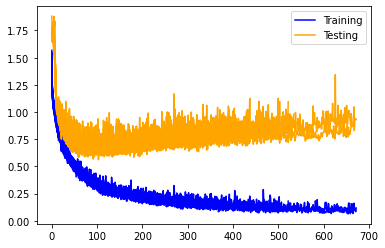

In [8]:
for i, history in enumerate(histories):
    pl.plot(history.history['loss'], label='Training', color="blue")
    pl.plot(history.history['val_loss'], label='Testing', color="orange")
    
    if i == 0:
        pl.legend()
        
    pl.grid()

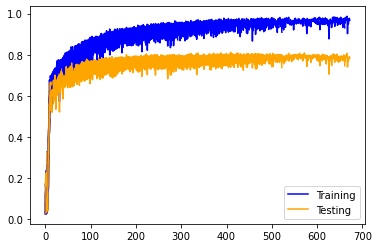

In [9]:
for i, history in enumerate(histories):
    pl.plot(history.history['f1_score_train'], label='Training', color="blue")
    pl.plot(history.history['f1_score_val'], label='Testing', color="orange")
    
    if i == 0:
        pl.legend()
        
    pl.grid()

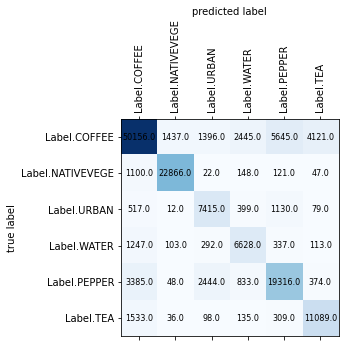

In [10]:
plot_confusion_matrix(conf_matrix, labels)

In [11]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrix)

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.86568401 0.93322994 0.63555327 0.62599169 0.71918981 0.70081527]
Mean precision:  0.7467439980115366

Recalls:  [0.7692638  0.94083278 0.77627722 0.76009174 0.73166667 0.84007576]
Mean recall:  0.8030346625333252

F-Score:  [0.81463074 0.93701594 0.69890193 0.6865548  0.72537459 0.76415257]
Mean f-score:  0.7711050939798257


# January to April 2017

In [12]:
dataset_args = dict(
    labels = labels,
    raster_paths = [DATA_ROOT_PATH + 'Vietnam_2017_january_to_april/merged.tif'],
    labels_coordinates_list = [LABELS_COORDINATES],
    nb_pixel_around = NB_PIXEL_AROUND
)

dataset = make_dataset_from_raster_files(**dataset_args)

model_name = "january_to_april_2017"

# images have all the same shapes, take the shape of the first image
image_width = len(dataset[0][1][0][0])
image_height = len(dataset[0][1][0])
image_depth = len(bands)
nb_outputs = len(labels)

# Create model
model = Sequential([
    Rescaling(1./2**16, input_shape=(image_width, image_height, image_depth)),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),
    SpatialDropout2D(0.25),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(nb_outputs, activation='softmax'),
])

mean_loss, mean_accuracy, histories, conf_matrix = cross_validation(model, dataset, bands, labels, EPOCHS, NB_TESTS, early_stopping=True, with_model_checkpoint=True, model_name=model_name)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 9, 9, 7)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 9, 7)           28        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 9, 9, 32)          2048      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 9, 9, 32)          9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 3, 3, 64)          18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 3, 3, 64)         

58/58 [==============================] - 1s 10ms/step - loss: 0.3396 - accuracy: 0.8116 - val_loss: 0.6329 - val_accuracy: 0.7708
Epoch 101/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.4228 - accuracy: 0.7826 - val_loss: 0.6882 - val_accuracy: 0.7437
Epoch 102/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3906 - accuracy: 0.7858 - val_loss: 0.6426 - val_accuracy: 0.7677
Epoch 103/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.3625 - accuracy: 0.8014 - val_loss: 0.7009 - val_accuracy: 0.7425
Epoch 104/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3496 - accuracy: 0.8068 - val_loss: 0.6238 - val_accuracy: 0.7735
Epoch 105/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3662 - accuracy: 0.8186 - val_loss: 0.7969 - val_accuracy: 0.7136
Epoch 106/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.4352 - accuracy: 0.7799 - val_loss: 0.6494 - val_accuracy: 0.7677
Epoch 

Epoch 157/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2571 - accuracy: 0.8482 - val_loss: 0.5894 - val_accuracy: 0.8065
Epoch 158/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2615 - accuracy: 0.8579 - val_loss: 0.5942 - val_accuracy: 0.7957
Epoch 159/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2378 - accuracy: 0.8617 - val_loss: 0.6149 - val_accuracy: 0.7956
Epoch 160/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3475 - accuracy: 0.8192 - val_loss: 0.7178 - val_accuracy: 0.7460
Epoch 161/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.3082 - accuracy: 0.8267 - val_loss: 0.6860 - val_accuracy: 0.7669
Epoch 162/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.3814 - accuracy: 0.8030 - val_loss: 0.6065 - val_accuracy: 0.7840
Epoch 163/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2884 - accuracy: 0.8536 - val_loss: 0.6888 - val_accuracy:

Epoch 214/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2174 - accuracy: 0.8746 - val_loss: 0.6362 - val_accuracy: 0.7956
Epoch 215/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2238 - accuracy: 0.8805 - val_loss: 0.7007 - val_accuracy: 0.7838
Epoch 216/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.2154 - accuracy: 0.8800 - val_loss: 0.6097 - val_accuracy: 0.8122
Epoch 217/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2230 - accuracy: 0.8784 - val_loss: 0.6126 - val_accuracy: 0.8054
Epoch 218/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2534 - accuracy: 0.8698 - val_loss: 0.6293 - val_accuracy: 0.7962
Epoch 219/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1926 - accuracy: 0.8897 - val_loss: 0.5941 - val_accuracy: 0.8187
Epoch 220/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1751 - accuracy: 0.8940 - val_loss: 0.5832 - val_accuracy

Epoch 271/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2278 - accuracy: 0.8794 - val_loss: 0.5838 - val_accuracy: 0.8186
Epoch 272/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2055 - accuracy: 0.8832 - val_loss: 0.6338 - val_accuracy: 0.8116
Epoch 273/2000
58/58 [==============================] - 1s 8ms/step - loss: 0.2711 - accuracy: 0.8428 - val_loss: 0.6343 - val_accuracy: 0.7965
Epoch 274/2000
58/58 [==============================] - 0s 9ms/step - loss: 0.1956 - accuracy: 0.8794 - val_loss: 0.6542 - val_accuracy: 0.7962
Epoch 275/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2460 - accuracy: 0.8461 - val_loss: 0.6036 - val_accuracy: 0.8081
Epoch 276/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.3937 - accuracy: 0.8208 - val_loss: 0.6478 - val_accuracy: 0.7769
Epoch 277/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2343 - accuracy: 0.8741 - val_loss: 0.6775 - val_accuracy:

Epoch 328/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.1948 - accuracy: 0.8967 - val_loss: 0.7266 - val_accuracy: 0.7950
Epoch 329/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1563 - accuracy: 0.9080 - val_loss: 0.6627 - val_accuracy: 0.8192
Epoch 330/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2499 - accuracy: 0.8703 - val_loss: 0.7691 - val_accuracy: 0.7556
Epoch 331/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2869 - accuracy: 0.8515 - val_loss: 0.6860 - val_accuracy: 0.7876
Epoch 332/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.1711 - accuracy: 0.8977 - val_loss: 0.6381 - val_accuracy: 0.8190
Epoch 333/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.1839 - accuracy: 0.9064 - val_loss: 0.6634 - val_accuracy: 0.8062
Epoch 334/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.1590 - accuracy: 0.9090 - val_loss: 0.6812 - val_accuracy

Epoch 385/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1553 - accuracy: 0.9112 - val_loss: 0.6575 - val_accuracy: 0.8147
Epoch 386/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1769 - accuracy: 0.9117 - val_loss: 0.6631 - val_accuracy: 0.8139
Epoch 387/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1501 - accuracy: 0.9155 - val_loss: 0.7691 - val_accuracy: 0.7977
Epoch 388/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1260 - accuracy: 0.9268 - val_loss: 0.6698 - val_accuracy: 0.8199
Epoch 389/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1412 - accuracy: 0.9166 - val_loss: 0.7391 - val_accuracy: 0.8031
Epoch 390/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.1382 - accuracy: 0.9263 - val_loss: 0.6874 - val_accuracy: 0.8242
Epoch 391/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1785 - accuracy: 0.9031 - val_loss: 0.7001 - val_accuracy:

Epoch 36/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.5596 - accuracy: 0.7174 - val_loss: 0.6591 - val_accuracy: 0.7560
Epoch 37/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.5418 - accuracy: 0.7293 - val_loss: 0.6863 - val_accuracy: 0.7401
Epoch 38/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.5625 - accuracy: 0.7282 - val_loss: 0.8054 - val_accuracy: 0.6923
Epoch 39/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.5881 - accuracy: 0.7212 - val_loss: 0.6934 - val_accuracy: 0.7460
Epoch 40/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.5501 - accuracy: 0.7255 - val_loss: 0.6486 - val_accuracy: 0.7540
Epoch 41/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.5354 - accuracy: 0.7417 - val_loss: 0.7184 - val_accuracy: 0.7233
Epoch 42/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.5248 - accuracy: 0.7255 - val_loss: 0.7969 - val_accuracy: 0.6958

Epoch 150/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2850 - accuracy: 0.8229 - val_loss: 0.6609 - val_accuracy: 0.7790
Epoch 151/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2859 - accuracy: 0.8229 - val_loss: 0.7072 - val_accuracy: 0.7637
Epoch 152/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.3183 - accuracy: 0.8235 - val_loss: 0.8034 - val_accuracy: 0.7284
Epoch 153/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3361 - accuracy: 0.7912 - val_loss: 0.6893 - val_accuracy: 0.7670
Epoch 154/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2920 - accuracy: 0.8235 - val_loss: 0.6681 - val_accuracy: 0.7821
Epoch 155/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2939 - accuracy: 0.8434 - val_loss: 0.6680 - val_accuracy: 0.7739
Epoch 156/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3657 - accuracy: 0.8041 - val_loss: 0.6158 - val_accuracy:

Epoch 207/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2082 - accuracy: 0.8665 - val_loss: 0.7443 - val_accuracy: 0.7793
Epoch 208/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2520 - accuracy: 0.8525 - val_loss: 0.6426 - val_accuracy: 0.8026
Epoch 209/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2174 - accuracy: 0.8541 - val_loss: 0.7034 - val_accuracy: 0.7838
Epoch 210/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2326 - accuracy: 0.8547 - val_loss: 0.6974 - val_accuracy: 0.8017
Epoch 211/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2724 - accuracy: 0.8584 - val_loss: 0.7627 - val_accuracy: 0.7619
Epoch 212/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2307 - accuracy: 0.8466 - val_loss: 0.6971 - val_accuracy: 0.7799
Epoch 213/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2086 - accuracy: 0.8730 - val_loss: 0.7508 - val_accuracy:

Epoch 25/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.7789 - accuracy: 0.6039 - val_loss: 0.8617 - val_accuracy: 0.6629
Epoch 26/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.6777 - accuracy: 0.6755 - val_loss: 0.9723 - val_accuracy: 0.6093
Epoch 27/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.7329 - accuracy: 0.6572 - val_loss: 0.8663 - val_accuracy: 0.6744
Epoch 28/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.6919 - accuracy: 0.6781 - val_loss: 0.8730 - val_accuracy: 0.6600
Epoch 29/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.6626 - accuracy: 0.6749 - val_loss: 0.8493 - val_accuracy: 0.6684
Epoch 30/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.7013 - accuracy: 0.6636 - val_loss: 0.8765 - val_accuracy: 0.6708
Epoch 31/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.7186 - accuracy: 0.6561 - val_loss: 0.8372 - val_accuracy: 0.6956

58/58 [==============================] - 0s 7ms/step - loss: 0.3648 - accuracy: 0.8267 - val_loss: 0.6313 - val_accuracy: 0.7844
Epoch 140/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3158 - accuracy: 0.8369 - val_loss: 0.6396 - val_accuracy: 0.7742
Epoch 141/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.3001 - accuracy: 0.8396 - val_loss: 0.6265 - val_accuracy: 0.7857
Epoch 142/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2984 - accuracy: 0.8353 - val_loss: 0.5965 - val_accuracy: 0.7984
Epoch 143/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2917 - accuracy: 0.8375 - val_loss: 0.6424 - val_accuracy: 0.7787
Epoch 144/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3527 - accuracy: 0.8062 - val_loss: 0.6572 - val_accuracy: 0.7681
Epoch 145/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.3074 - accuracy: 0.8418 - val_loss: 0.6347 - val_accuracy: 0.7771
Epoch 1

Epoch 196/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2721 - accuracy: 0.8590 - val_loss: 0.6482 - val_accuracy: 0.7773
Epoch 197/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2365 - accuracy: 0.8719 - val_loss: 0.6243 - val_accuracy: 0.7943
Epoch 198/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2970 - accuracy: 0.8149 - val_loss: 0.8346 - val_accuracy: 0.7341
Epoch 199/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.4652 - accuracy: 0.7460 - val_loss: 0.7745 - val_accuracy: 0.6939
Epoch 200/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3208 - accuracy: 0.8175 - val_loss: 0.5951 - val_accuracy: 0.7987
Epoch 201/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3022 - accuracy: 0.8385 - val_loss: 0.7673 - val_accuracy: 0.7552
Epoch 202/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2894 - accuracy: 0.8509 - val_loss: 0.6456 - val_accuracy:

Epoch 28/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.7366 - accuracy: 0.6607 - val_loss: 0.8433 - val_accuracy: 0.6797
Epoch 29/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.7066 - accuracy: 0.6764 - val_loss: 0.7940 - val_accuracy: 0.7066
Epoch 30/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.7126 - accuracy: 0.6575 - val_loss: 0.8144 - val_accuracy: 0.6883
Epoch 31/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.6725 - accuracy: 0.6791 - val_loss: 0.8700 - val_accuracy: 0.6691
Epoch 32/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.7716 - accuracy: 0.6085 - val_loss: 0.9164 - val_accuracy: 0.6435
Epoch 33/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.7078 - accuracy: 0.6688 - val_loss: 0.7610 - val_accuracy: 0.7201
Epoch 34/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.6522 - accuracy: 0.6957 - val_loss: 0.8061 - val_accuracy: 0.6969

58/58 [==============================] - 0s 7ms/step - loss: 0.3528 - accuracy: 0.8083 - val_loss: 0.5935 - val_accuracy: 0.7856
Epoch 143/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3191 - accuracy: 0.8072 - val_loss: 0.5954 - val_accuracy: 0.7925
Epoch 144/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3703 - accuracy: 0.8029 - val_loss: 0.8139 - val_accuracy: 0.7136
Epoch 145/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.3156 - accuracy: 0.7938 - val_loss: 0.6452 - val_accuracy: 0.7792
Epoch 146/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.3283 - accuracy: 0.8244 - val_loss: 0.6183 - val_accuracy: 0.7867
Epoch 147/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3472 - accuracy: 0.8088 - val_loss: 0.6640 - val_accuracy: 0.7652
Epoch 148/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3817 - accuracy: 0.7954 - val_loss: 0.6427 - val_accuracy: 0.7722
Epoch 1

Epoch 199/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2678 - accuracy: 0.8406 - val_loss: 0.6430 - val_accuracy: 0.7879
Epoch 200/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2704 - accuracy: 0.8390 - val_loss: 0.7052 - val_accuracy: 0.7751
Epoch 201/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2480 - accuracy: 0.8411 - val_loss: 0.6195 - val_accuracy: 0.7852
Epoch 202/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3181 - accuracy: 0.8255 - val_loss: 0.5951 - val_accuracy: 0.8037
Epoch 203/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2614 - accuracy: 0.8454 - val_loss: 0.6024 - val_accuracy: 0.8002
Epoch 204/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.3347 - accuracy: 0.8207 - val_loss: 0.6981 - val_accuracy: 0.7664
Epoch 205/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3857 - accuracy: 0.8137 - val_loss: 0.6941 - val_accuracy:

Epoch 256/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.3001 - accuracy: 0.8411 - val_loss: 0.5901 - val_accuracy: 0.8046
Epoch 257/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2789 - accuracy: 0.8465 - val_loss: 0.6077 - val_accuracy: 0.7956
Epoch 258/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2248 - accuracy: 0.8643 - val_loss: 0.6753 - val_accuracy: 0.7911
Epoch 259/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2233 - accuracy: 0.8638 - val_loss: 0.6804 - val_accuracy: 0.7835
Epoch 260/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2255 - accuracy: 0.8691 - val_loss: 0.6421 - val_accuracy: 0.7977
Epoch 261/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2300 - accuracy: 0.8638 - val_loss: 0.6506 - val_accuracy: 0.7925
Epoch 262/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2584 - accuracy: 0.8573 - val_loss: 0.7347 - val_accuracy:

Epoch 313/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2362 - accuracy: 0.8551 - val_loss: 0.6620 - val_accuracy: 0.7872
Epoch 314/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.4662 - accuracy: 0.7577 - val_loss: 0.6578 - val_accuracy: 0.7632
Epoch 315/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3630 - accuracy: 0.8142 - val_loss: 0.6342 - val_accuracy: 0.7765
Epoch 316/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2891 - accuracy: 0.8212 - val_loss: 0.6731 - val_accuracy: 0.7667
Epoch 317/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2880 - accuracy: 0.8422 - val_loss: 0.6497 - val_accuracy: 0.7806
Epoch 318/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2657 - accuracy: 0.8546 - val_loss: 0.6177 - val_accuracy: 0.8010
Epoch 319/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2430 - accuracy: 0.8616 - val_loss: 0.6777 - val_accuracy

Epoch 370/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1587 - accuracy: 0.9106 - val_loss: 0.6246 - val_accuracy: 0.8287
Epoch 371/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1446 - accuracy: 0.9025 - val_loss: 0.6482 - val_accuracy: 0.8312
Epoch 372/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1856 - accuracy: 0.8934 - val_loss: 0.6738 - val_accuracy: 0.8068
Epoch 373/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2127 - accuracy: 0.8751 - val_loss: 0.6619 - val_accuracy: 0.8090
Epoch 374/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1761 - accuracy: 0.8988 - val_loss: 0.7058 - val_accuracy: 0.7941
Epoch 375/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1941 - accuracy: 0.8821 - val_loss: 0.6800 - val_accuracy: 0.8158
Epoch 376/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1481 - accuracy: 0.9074 - val_loss: 0.6737 - val_accuracy:

Epoch 427/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.7236 - accuracy: 0.6785 - val_loss: 0.8713 - val_accuracy: 0.6665
Epoch 428/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.3929 - accuracy: 0.7711 - val_loss: 0.6600 - val_accuracy: 0.7684
Epoch 429/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.3339 - accuracy: 0.8164 - val_loss: 0.6793 - val_accuracy: 0.7677
Epoch 430/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2840 - accuracy: 0.8228 - val_loss: 0.8253 - val_accuracy: 0.7513
Epoch 431/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2492 - accuracy: 0.8411 - val_loss: 0.5979 - val_accuracy: 0.8047
Epoch 432/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1901 - accuracy: 0.8751 - val_loss: 0.6082 - val_accuracy: 0.8068
Epoch 433/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1977 - accuracy: 0.8735 - val_loss: 0.6291 - val_accuracy

58/58 [==============================] - 0s 8ms/step - loss: 0.5465 - accuracy: 0.7383 - val_loss: 0.7363 - val_accuracy: 0.7191
Epoch 61/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.4456 - accuracy: 0.7690 - val_loss: 0.6845 - val_accuracy: 0.7457
Epoch 62/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.4994 - accuracy: 0.7539 - val_loss: 0.6467 - val_accuracy: 0.7571
Epoch 63/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.5304 - accuracy: 0.7410 - val_loss: 0.7156 - val_accuracy: 0.7340
Epoch 64/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.4775 - accuracy: 0.7550 - val_loss: 0.6614 - val_accuracy: 0.7630
Epoch 65/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.5479 - accuracy: 0.7092 - val_loss: 1.0253 - val_accuracy: 0.5865
Epoch 66/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.5891 - accuracy: 0.6758 - val_loss: 0.8685 - val_accuracy: 0.6597
Epoch 67/20

Epoch 174/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.2778 - accuracy: 0.8551 - val_loss: 0.6816 - val_accuracy: 0.7640
Epoch 175/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.2756 - accuracy: 0.8325 - val_loss: 0.6551 - val_accuracy: 0.7786
Epoch 176/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.2547 - accuracy: 0.8476 - val_loss: 0.6912 - val_accuracy: 0.7737
Epoch 177/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2488 - accuracy: 0.8578 - val_loss: 0.6648 - val_accuracy: 0.7866
Epoch 178/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2623 - accuracy: 0.8471 - val_loss: 0.6587 - val_accuracy: 0.7746
Epoch 179/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2770 - accuracy: 0.8428 - val_loss: 0.6289 - val_accuracy: 0.7899
Epoch 180/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2251 - accuracy: 0.8605 - val_loss: 0.6292 - val_accura

Epoch 231/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2215 - accuracy: 0.8713 - val_loss: 0.6354 - val_accuracy: 0.7972
Epoch 232/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2236 - accuracy: 0.8783 - val_loss: 0.6090 - val_accuracy: 0.8038
Epoch 233/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2170 - accuracy: 0.8648 - val_loss: 0.6257 - val_accuracy: 0.7977
Epoch 234/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2325 - accuracy: 0.8589 - val_loss: 0.6453 - val_accuracy: 0.7934
Epoch 235/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2483 - accuracy: 0.8616 - val_loss: 0.6614 - val_accuracy: 0.7883
Epoch 236/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.3054 - accuracy: 0.8584 - val_loss: 0.7155 - val_accuracy: 0.7633
Epoch 237/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2418 - accuracy: 0.8525 - val_loss: 0.6313 - val_accuracy:

Epoch 288/2000
58/58 [==============================] - 1s 15ms/step - loss: 0.1993 - accuracy: 0.8805 - val_loss: 0.6573 - val_accuracy: 0.7886
Epoch 289/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2075 - accuracy: 0.8621 - val_loss: 0.6413 - val_accuracy: 0.7897
Epoch 290/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.1916 - accuracy: 0.8783 - val_loss: 0.6111 - val_accuracy: 0.8045
Epoch 291/2000
58/58 [==============================] - 0s 9ms/step - loss: 0.2261 - accuracy: 0.8643 - val_loss: 0.7034 - val_accuracy: 0.7920
Epoch 292/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2254 - accuracy: 0.8643 - val_loss: 0.6758 - val_accuracy: 0.8033
Epoch 293/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2266 - accuracy: 0.8675 - val_loss: 0.6598 - val_accuracy: 0.7794
Epoch 294/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1833 - accuracy: 0.8912 - val_loss: 0.7195 - val_accuracy

Epoch 345/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2567 - accuracy: 0.8546 - val_loss: 0.6697 - val_accuracy: 0.7847
Epoch 346/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1837 - accuracy: 0.8880 - val_loss: 0.6320 - val_accuracy: 0.8037
Epoch 347/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.1690 - accuracy: 0.8896 - val_loss: 0.6758 - val_accuracy: 0.7936
Epoch 348/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.1732 - accuracy: 0.8864 - val_loss: 0.6480 - val_accuracy: 0.8132
Epoch 349/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1758 - accuracy: 0.8939 - val_loss: 0.7070 - val_accuracy: 0.7886
Epoch 350/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2403 - accuracy: 0.8627 - val_loss: 0.6760 - val_accuracy: 0.7833
Epoch 351/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1907 - accuracy: 0.8869 - val_loss: 0.6714 - val_accuracy

Epoch 42/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.5769 - accuracy: 0.6921 - val_loss: 0.7802 - val_accuracy: 0.7023
Epoch 43/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.5656 - accuracy: 0.7174 - val_loss: 0.7884 - val_accuracy: 0.7106
Epoch 44/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.5612 - accuracy: 0.7029 - val_loss: 0.7894 - val_accuracy: 0.7030
Epoch 45/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.5511 - accuracy: 0.7217 - val_loss: 0.7634 - val_accuracy: 0.7024
Epoch 46/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.5305 - accuracy: 0.7255 - val_loss: 0.7643 - val_accuracy: 0.7113
Epoch 47/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.5740 - accuracy: 0.7223 - val_loss: 0.8081 - val_accuracy: 0.6943
Epoch 48/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.5436 - accuracy: 0.6938 - val_loss: 0.6815 - val_accuracy: 0.744

Epoch 156/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2944 - accuracy: 0.8342 - val_loss: 0.6068 - val_accuracy: 0.8100
Epoch 157/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2755 - accuracy: 0.8332 - val_loss: 0.6314 - val_accuracy: 0.7993
Epoch 158/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2756 - accuracy: 0.8288 - val_loss: 0.6861 - val_accuracy: 0.7674
Epoch 159/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2790 - accuracy: 0.8202 - val_loss: 0.6579 - val_accuracy: 0.7953
Epoch 160/2000
58/58 [==============================] - 1s 14ms/step - loss: 0.2412 - accuracy: 0.8509 - val_loss: 0.6778 - val_accuracy: 0.7782
Epoch 161/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2799 - accuracy: 0.8358 - val_loss: 0.7952 - val_accuracy: 0.7482
Epoch 162/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.2773 - accuracy: 0.8310 - val_loss: 0.6260 - val_accurac

Epoch 213/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2453 - accuracy: 0.8563 - val_loss: 0.6302 - val_accuracy: 0.8108
Epoch 214/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2457 - accuracy: 0.8590 - val_loss: 0.6555 - val_accuracy: 0.7952
Epoch 215/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3688 - accuracy: 0.7960 - val_loss: 0.7285 - val_accuracy: 0.7655
Epoch 216/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2613 - accuracy: 0.8321 - val_loss: 0.7947 - val_accuracy: 0.7506
Epoch 217/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3431 - accuracy: 0.8062 - val_loss: 0.6912 - val_accuracy: 0.7834
Epoch 218/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2771 - accuracy: 0.8305 - val_loss: 0.6459 - val_accuracy: 0.7980
Epoch 219/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2750 - accuracy: 0.8450 - val_loss: 0.6719 - val_accuracy:

Epoch 270/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2186 - accuracy: 0.8762 - val_loss: 0.7580 - val_accuracy: 0.7958
Epoch 271/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1737 - accuracy: 0.8994 - val_loss: 0.7289 - val_accuracy: 0.8148
Epoch 272/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2075 - accuracy: 0.8724 - val_loss: 0.7441 - val_accuracy: 0.7859
Epoch 273/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2217 - accuracy: 0.8574 - val_loss: 0.7818 - val_accuracy: 0.7646
Epoch 274/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2241 - accuracy: 0.8628 - val_loss: 0.7562 - val_accuracy: 0.7773
Epoch 275/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1661 - accuracy: 0.8886 - val_loss: 0.7524 - val_accuracy: 0.7992
Epoch 276/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1730 - accuracy: 0.8881 - val_loss: 0.7316 - val_accuracy:

Epoch 327/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.1808 - accuracy: 0.8907 - val_loss: 0.7687 - val_accuracy: 0.7867
Epoch 328/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2292 - accuracy: 0.8767 - val_loss: 0.7483 - val_accuracy: 0.7637
Epoch 329/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2345 - accuracy: 0.8606 - val_loss: 0.7105 - val_accuracy: 0.7786
Epoch 330/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1932 - accuracy: 0.8805 - val_loss: 0.6965 - val_accuracy: 0.7977
Epoch 331/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1788 - accuracy: 0.8934 - val_loss: 0.6759 - val_accuracy: 0.8044
Epoch 332/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1953 - accuracy: 0.8961 - val_loss: 0.7101 - val_accuracy: 0.8062
Epoch 333/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2125 - accuracy: 0.8854 - val_loss: 0.6813 - val_accuracy:

Epoch 384/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.5217 - accuracy: 0.7600 - val_loss: 0.7956 - val_accuracy: 0.7603
Epoch 385/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.3190 - accuracy: 0.8294 - val_loss: 0.7664 - val_accuracy: 0.7611
Epoch 386/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2090 - accuracy: 0.8778 - val_loss: 0.7789 - val_accuracy: 0.7662
Epoch 387/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.3080 - accuracy: 0.8272 - val_loss: 0.7385 - val_accuracy: 0.7584
Epoch 388/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2929 - accuracy: 0.8170 - val_loss: 0.7219 - val_accuracy: 0.7764
Epoch 389/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1993 - accuracy: 0.8654 - val_loss: 0.8279 - val_accuracy: 0.7487
Epoch 390/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2122 - accuracy: 0.8611 - val_loss: 0.7227 - val_accuracy:

Epoch 441/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2407 - accuracy: 0.8638 - val_loss: 0.7441 - val_accuracy: 0.7871
Epoch 442/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2154 - accuracy: 0.8864 - val_loss: 0.7790 - val_accuracy: 0.7879
Epoch 443/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1554 - accuracy: 0.9020 - val_loss: 0.7343 - val_accuracy: 0.8028
Epoch 444/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1456 - accuracy: 0.9080 - val_loss: 0.7210 - val_accuracy: 0.8152
Epoch 445/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.1501 - accuracy: 0.9144 - val_loss: 0.8033 - val_accuracy: 0.8004
Epoch 446/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1312 - accuracy: 0.9123 - val_loss: 0.7427 - val_accuracy: 0.8159
Epoch 447/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1542 - accuracy: 0.9112 - val_loss: 0.7464 - val_accuracy:

Epoch 18/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.7393 - accuracy: 0.6534 - val_loss: 0.9720 - val_accuracy: 0.6143
Epoch 19/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.7453 - accuracy: 0.6642 - val_loss: 1.0463 - val_accuracy: 0.5855
Epoch 20/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.7045 - accuracy: 0.6717 - val_loss: 0.7363 - val_accuracy: 0.7421
Epoch 21/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.7215 - accuracy: 0.6598 - val_loss: 0.8894 - val_accuracy: 0.6450
Epoch 22/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.6929 - accuracy: 0.6868 - val_loss: 0.9310 - val_accuracy: 0.6394
Epoch 23/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.7199 - accuracy: 0.6566 - val_loss: 0.9994 - val_accuracy: 0.5968
Epoch 24/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.7028 - accuracy: 0.6825 - val_loss: 0.8841 - val_accuracy: 0.6521

58/58 [==============================] - 0s 7ms/step - loss: 0.3732 - accuracy: 0.7949 - val_loss: 0.6225 - val_accuracy: 0.7790
Epoch 133/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3377 - accuracy: 0.8278 - val_loss: 0.6456 - val_accuracy: 0.7729
Epoch 134/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3215 - accuracy: 0.8245 - val_loss: 0.6277 - val_accuracy: 0.7731
Epoch 135/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2657 - accuracy: 0.8531 - val_loss: 0.6061 - val_accuracy: 0.7942
Epoch 136/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3467 - accuracy: 0.8143 - val_loss: 0.7619 - val_accuracy: 0.7424
Epoch 137/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3679 - accuracy: 0.7955 - val_loss: 0.6780 - val_accuracy: 0.7587
Epoch 138/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.3201 - accuracy: 0.8127 - val_loss: 0.6403 - val_accuracy: 0.7707
Epoch 1

Epoch 189/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2379 - accuracy: 0.8654 - val_loss: 0.6397 - val_accuracy: 0.7900
Epoch 190/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3053 - accuracy: 0.8348 - val_loss: 0.8212 - val_accuracy: 0.7176
Epoch 191/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.3891 - accuracy: 0.8057 - val_loss: 0.7093 - val_accuracy: 0.7454
Epoch 192/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2906 - accuracy: 0.8412 - val_loss: 0.6163 - val_accuracy: 0.7820
Epoch 193/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2666 - accuracy: 0.8515 - val_loss: 0.7123 - val_accuracy: 0.7608
Epoch 194/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2625 - accuracy: 0.8536 - val_loss: 0.6886 - val_accuracy: 0.7739
Epoch 195/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2382 - accuracy: 0.8671 - val_loss: 0.6307 - val_accuracy:

Epoch 246/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1953 - accuracy: 0.8854 - val_loss: 0.6520 - val_accuracy: 0.8059
Epoch 247/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1714 - accuracy: 0.8956 - val_loss: 0.6952 - val_accuracy: 0.7957
Epoch 248/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1746 - accuracy: 0.8918 - val_loss: 0.7410 - val_accuracy: 0.7900
Epoch 249/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2014 - accuracy: 0.8816 - val_loss: 0.7173 - val_accuracy: 0.7840
Epoch 250/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1962 - accuracy: 0.8902 - val_loss: 0.8018 - val_accuracy: 0.7681
Epoch 251/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2235 - accuracy: 0.8773 - val_loss: 0.6797 - val_accuracy: 0.7945
Epoch 252/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2131 - accuracy: 0.8821 - val_loss: 0.6945 - val_accuracy:

Epoch 303/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1993 - accuracy: 0.8854 - val_loss: 0.6790 - val_accuracy: 0.8031
Epoch 304/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1963 - accuracy: 0.8950 - val_loss: 0.6564 - val_accuracy: 0.7980
Epoch 305/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1739 - accuracy: 0.8929 - val_loss: 0.6962 - val_accuracy: 0.8055
Epoch 306/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1527 - accuracy: 0.9010 - val_loss: 0.6798 - val_accuracy: 0.8127
Epoch 307/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2105 - accuracy: 0.8837 - val_loss: 0.7942 - val_accuracy: 0.7821
Epoch 308/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1808 - accuracy: 0.9020 - val_loss: 0.6834 - val_accuracy: 0.8020
Epoch 309/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1602 - accuracy: 0.8999 - val_loss: 0.7066 - val_accuracy:

Epoch 360/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3524 - accuracy: 0.8515 - val_loss: 0.7022 - val_accuracy: 0.7818
Epoch 361/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2236 - accuracy: 0.8811 - val_loss: 0.7170 - val_accuracy: 0.7829
Epoch 362/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2145 - accuracy: 0.8741 - val_loss: 0.6556 - val_accuracy: 0.8000
Epoch 363/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1912 - accuracy: 0.8746 - val_loss: 0.6752 - val_accuracy: 0.8012
Epoch 364/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2557 - accuracy: 0.8488 - val_loss: 0.6847 - val_accuracy: 0.7995
Epoch 365/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1773 - accuracy: 0.9064 - val_loss: 0.6802 - val_accuracy: 0.8074
Epoch 366/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2178 - accuracy: 0.8703 - val_loss: 0.7800 - val_accuracy:

58/58 [==============================] - 0s 7ms/step - loss: 0.4501 - accuracy: 0.7648 - val_loss: 0.6238 - val_accuracy: 0.7619
Epoch 60/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.4286 - accuracy: 0.7777 - val_loss: 0.6479 - val_accuracy: 0.7557
Epoch 61/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.5564 - accuracy: 0.7207 - val_loss: 0.6994 - val_accuracy: 0.7127
Epoch 62/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.4734 - accuracy: 0.7427 - val_loss: 0.7638 - val_accuracy: 0.7124
Epoch 63/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.4393 - accuracy: 0.7756 - val_loss: 0.6892 - val_accuracy: 0.7448
Epoch 64/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.4609 - accuracy: 0.7643 - val_loss: 0.7490 - val_accuracy: 0.7131
Epoch 65/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.4428 - accuracy: 0.7664 - val_loss: 0.7389 - val_accuracy: 0.7026
Epoch 66/2000

Epoch 173/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2603 - accuracy: 0.8482 - val_loss: 0.6080 - val_accuracy: 0.7931
Epoch 174/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2552 - accuracy: 0.8590 - val_loss: 0.6691 - val_accuracy: 0.7719
Epoch 175/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2413 - accuracy: 0.8504 - val_loss: 0.5727 - val_accuracy: 0.8106
Epoch 176/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2489 - accuracy: 0.8525 - val_loss: 0.6184 - val_accuracy: 0.7937
Epoch 177/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3067 - accuracy: 0.8235 - val_loss: 0.6917 - val_accuracy: 0.7639
Epoch 178/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2491 - accuracy: 0.8552 - val_loss: 0.6447 - val_accuracy: 0.7795
Epoch 179/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2694 - accuracy: 0.8466 - val_loss: 0.6539 - val_accuracy:

Epoch 230/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2400 - accuracy: 0.8552 - val_loss: 0.6253 - val_accuracy: 0.7868
Epoch 231/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2236 - accuracy: 0.8595 - val_loss: 0.6370 - val_accuracy: 0.7973
Epoch 232/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2171 - accuracy: 0.8735 - val_loss: 0.6716 - val_accuracy: 0.7814
Epoch 233/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2067 - accuracy: 0.8767 - val_loss: 0.6292 - val_accuracy: 0.8012
Epoch 234/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3114 - accuracy: 0.8283 - val_loss: 0.6351 - val_accuracy: 0.7966
Epoch 235/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2119 - accuracy: 0.8741 - val_loss: 0.5970 - val_accuracy: 0.8183
Epoch 236/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2118 - accuracy: 0.8638 - val_loss: 0.5941 - val_accuracy:

Epoch 47/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.5323 - accuracy: 0.7232 - val_loss: 0.7068 - val_accuracy: 0.7325
Epoch 48/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.4824 - accuracy: 0.7523 - val_loss: 0.7700 - val_accuracy: 0.6834
Epoch 49/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.4886 - accuracy: 0.7345 - val_loss: 0.6764 - val_accuracy: 0.7397
Epoch 50/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.4862 - accuracy: 0.7464 - val_loss: 0.7553 - val_accuracy: 0.7099
Epoch 51/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.5024 - accuracy: 0.7561 - val_loss: 0.7082 - val_accuracy: 0.7170
Epoch 52/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.4772 - accuracy: 0.7577 - val_loss: 0.6214 - val_accuracy: 0.7629
Epoch 53/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.4727 - accuracy: 0.7512 - val_loss: 0.6997 - val_accuracy: 0.7331

Epoch 161/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3024 - accuracy: 0.8261 - val_loss: 0.6326 - val_accuracy: 0.7856
Epoch 162/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2641 - accuracy: 0.8374 - val_loss: 0.6041 - val_accuracy: 0.7953
Epoch 163/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2480 - accuracy: 0.8638 - val_loss: 0.6004 - val_accuracy: 0.8058
Epoch 164/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2705 - accuracy: 0.8503 - val_loss: 0.6669 - val_accuracy: 0.7881
Epoch 165/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2365 - accuracy: 0.8525 - val_loss: 0.5798 - val_accuracy: 0.8166
Epoch 166/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2761 - accuracy: 0.8643 - val_loss: 0.7262 - val_accuracy: 0.7677
Epoch 167/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2632 - accuracy: 0.8417 - val_loss: 0.6244 - val_accuracy:

Epoch 218/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2558 - accuracy: 0.8713 - val_loss: 1.0064 - val_accuracy: 0.6764
Epoch 219/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3205 - accuracy: 0.8110 - val_loss: 0.6132 - val_accuracy: 0.7998
Epoch 220/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2079 - accuracy: 0.8702 - val_loss: 0.5940 - val_accuracy: 0.8119
Epoch 221/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2219 - accuracy: 0.8745 - val_loss: 0.6734 - val_accuracy: 0.7950
Epoch 222/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2315 - accuracy: 0.8621 - val_loss: 0.6430 - val_accuracy: 0.8008
Epoch 223/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2829 - accuracy: 0.8498 - val_loss: 0.6051 - val_accuracy: 0.8041
Epoch 224/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2038 - accuracy: 0.8729 - val_loss: 0.5796 - val_accuracy:

Epoch 275/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1815 - accuracy: 0.8891 - val_loss: 0.6145 - val_accuracy: 0.8189
Epoch 276/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2394 - accuracy: 0.8621 - val_loss: 0.7821 - val_accuracy: 0.7638
Epoch 277/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1876 - accuracy: 0.8901 - val_loss: 0.5917 - val_accuracy: 0.8233
Epoch 278/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1821 - accuracy: 0.8923 - val_loss: 0.6559 - val_accuracy: 0.8073
Epoch 279/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1877 - accuracy: 0.8971 - val_loss: 0.6357 - val_accuracy: 0.8299
Epoch 280/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1853 - accuracy: 0.8901 - val_loss: 0.6642 - val_accuracy: 0.8166
Epoch 281/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1745 - accuracy: 0.8945 - val_loss: 0.6731 - val_accuracy:

Epoch 332/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1715 - accuracy: 0.8998 - val_loss: 0.6153 - val_accuracy: 0.8198
Epoch 333/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1527 - accuracy: 0.9246 - val_loss: 0.6339 - val_accuracy: 0.8228
Epoch 334/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1888 - accuracy: 0.9009 - val_loss: 0.6600 - val_accuracy: 0.8133
Epoch 335/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1719 - accuracy: 0.8961 - val_loss: 0.6759 - val_accuracy: 0.8014
Epoch 336/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1975 - accuracy: 0.8659 - val_loss: 0.6106 - val_accuracy: 0.8139
Epoch 337/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1940 - accuracy: 0.8907 - val_loss: 0.6827 - val_accuracy: 0.7944
Epoch 338/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2261 - accuracy: 0.8686 - val_loss: 0.6237 - val_accuracy:

58/58 [==============================] - 0s 7ms/step - loss: 0.5083 - accuracy: 0.7394 - val_loss: 0.7370 - val_accuracy: 0.7381
Epoch 63/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.4870 - accuracy: 0.7674 - val_loss: 0.7094 - val_accuracy: 0.7393
Epoch 64/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.4482 - accuracy: 0.7771 - val_loss: 0.7864 - val_accuracy: 0.7198
Epoch 65/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.4711 - accuracy: 0.7841 - val_loss: 0.8184 - val_accuracy: 0.7140
Epoch 66/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.4635 - accuracy: 0.7695 - val_loss: 0.7648 - val_accuracy: 0.7276
Epoch 67/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.4674 - accuracy: 0.7690 - val_loss: 0.7156 - val_accuracy: 0.7344
Epoch 68/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.4662 - accuracy: 0.7862 - val_loss: 0.7227 - val_accuracy: 0.7455
Epoch 69/2000

Epoch 176/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2797 - accuracy: 0.8352 - val_loss: 0.7685 - val_accuracy: 0.7617
Epoch 177/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3297 - accuracy: 0.8045 - val_loss: 0.6641 - val_accuracy: 0.7788
Epoch 178/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2487 - accuracy: 0.8487 - val_loss: 0.6808 - val_accuracy: 0.7722
Epoch 179/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2308 - accuracy: 0.8654 - val_loss: 0.6928 - val_accuracy: 0.7893
Epoch 180/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2330 - accuracy: 0.8643 - val_loss: 0.7038 - val_accuracy: 0.7751
Epoch 181/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2575 - accuracy: 0.8535 - val_loss: 0.6768 - val_accuracy: 0.7855
Epoch 182/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2299 - accuracy: 0.8568 - val_loss: 0.7685 - val_accuracy:

Epoch 233/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2255 - accuracy: 0.8600 - val_loss: 0.6764 - val_accuracy: 0.8070
Epoch 234/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2204 - accuracy: 0.8686 - val_loss: 0.7036 - val_accuracy: 0.7839
Epoch 235/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1963 - accuracy: 0.8702 - val_loss: 0.6678 - val_accuracy: 0.7992
Epoch 236/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2160 - accuracy: 0.8837 - val_loss: 0.7089 - val_accuracy: 0.7921
Epoch 237/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2320 - accuracy: 0.8724 - val_loss: 0.6708 - val_accuracy: 0.7965
Epoch 238/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1924 - accuracy: 0.8815 - val_loss: 0.7021 - val_accuracy: 0.7874
Epoch 239/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1925 - accuracy: 0.8821 - val_loss: 0.6973 - val_accuracy:

Epoch 290/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3185 - accuracy: 0.8331 - val_loss: 0.7215 - val_accuracy: 0.7846
Epoch 291/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2508 - accuracy: 0.8745 - val_loss: 0.6576 - val_accuracy: 0.7992
Epoch 292/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2239 - accuracy: 0.8675 - val_loss: 0.7222 - val_accuracy: 0.7825
Epoch 293/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1926 - accuracy: 0.8831 - val_loss: 0.7164 - val_accuracy: 0.7948
Epoch 294/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1925 - accuracy: 0.8891 - val_loss: 0.6915 - val_accuracy: 0.8090
Epoch 295/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2119 - accuracy: 0.8745 - val_loss: 0.7926 - val_accuracy: 0.7660
Epoch 296/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2692 - accuracy: 0.8535 - val_loss: 0.7486 - val_accuracy:

Epoch 38/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.6213 - accuracy: 0.6830 - val_loss: 0.8966 - val_accuracy: 0.6427
Epoch 39/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.5183 - accuracy: 0.7142 - val_loss: 0.8110 - val_accuracy: 0.6927
Epoch 40/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.5708 - accuracy: 0.6916 - val_loss: 0.9549 - val_accuracy: 0.6315
Epoch 41/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.6149 - accuracy: 0.6760 - val_loss: 0.8294 - val_accuracy: 0.6898
Epoch 42/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.5771 - accuracy: 0.7029 - val_loss: 0.8186 - val_accuracy: 0.6941
Epoch 43/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.5659 - accuracy: 0.6862 - val_loss: 0.7669 - val_accuracy: 0.7061
Epoch 44/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.5473 - accuracy: 0.7034 - val_loss: 0.7014 - val_accuracy: 0.7272

58/58 [==============================] - 0s 7ms/step - loss: 0.2940 - accuracy: 0.8186 - val_loss: 0.6829 - val_accuracy: 0.7774
Epoch 153/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3665 - accuracy: 0.7944 - val_loss: 0.6518 - val_accuracy: 0.7880
Epoch 154/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2885 - accuracy: 0.8235 - val_loss: 0.6342 - val_accuracy: 0.7828
Epoch 155/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2523 - accuracy: 0.8391 - val_loss: 0.6540 - val_accuracy: 0.7848
Epoch 156/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2725 - accuracy: 0.8407 - val_loss: 0.6839 - val_accuracy: 0.7820
Epoch 157/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2700 - accuracy: 0.8262 - val_loss: 0.6577 - val_accuracy: 0.7867
Epoch 158/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2489 - accuracy: 0.8482 - val_loss: 0.6417 - val_accuracy: 0.8004
Epoch 1

Epoch 209/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2042 - accuracy: 0.8558 - val_loss: 0.6583 - val_accuracy: 0.7808
Epoch 210/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2083 - accuracy: 0.8805 - val_loss: 0.6664 - val_accuracy: 0.7939
Epoch 211/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2061 - accuracy: 0.8692 - val_loss: 0.6988 - val_accuracy: 0.7845
Epoch 212/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2146 - accuracy: 0.8606 - val_loss: 0.6929 - val_accuracy: 0.7980
Epoch 213/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1889 - accuracy: 0.8848 - val_loss: 0.6808 - val_accuracy: 0.7977
Epoch 214/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2563 - accuracy: 0.8439 - val_loss: 0.6746 - val_accuracy: 0.7891
Epoch 215/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2241 - accuracy: 0.8628 - val_loss: 0.6215 - val_accuracy:

Epoch 266/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2332 - accuracy: 0.8488 - val_loss: 0.6319 - val_accuracy: 0.8038
Epoch 267/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1795 - accuracy: 0.8794 - val_loss: 0.6152 - val_accuracy: 0.8156
Epoch 268/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1724 - accuracy: 0.8811 - val_loss: 0.6952 - val_accuracy: 0.8043
Epoch 269/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1811 - accuracy: 0.8762 - val_loss: 0.6272 - val_accuracy: 0.8174
Epoch 270/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1653 - accuracy: 0.8950 - val_loss: 0.6419 - val_accuracy: 0.8182
Epoch 271/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2420 - accuracy: 0.8595 - val_loss: 0.7091 - val_accuracy: 0.7980
Epoch 272/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1818 - accuracy: 0.8811 - val_loss: 0.7297 - val_accuracy:

Epoch 323/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1751 - accuracy: 0.8789 - val_loss: 0.6939 - val_accuracy: 0.8086
Epoch 324/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.3029 - accuracy: 0.8407 - val_loss: 0.7303 - val_accuracy: 0.7836
Epoch 325/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1946 - accuracy: 0.8757 - val_loss: 0.7598 - val_accuracy: 0.7913
Epoch 326/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2158 - accuracy: 0.8547 - val_loss: 0.7159 - val_accuracy: 0.8101
Epoch 327/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1727 - accuracy: 0.8940 - val_loss: 0.7083 - val_accuracy: 0.8004
Epoch 328/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2027 - accuracy: 0.8708 - val_loss: 0.8441 - val_accuracy: 0.7394
Epoch 329/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2475 - accuracy: 0.8418 - val_loss: 0.7333 - val_accuracy:

Epoch 380/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3043 - accuracy: 0.8434 - val_loss: 0.7797 - val_accuracy: 0.7861
Epoch 381/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1987 - accuracy: 0.8687 - val_loss: 0.7740 - val_accuracy: 0.7825
Epoch 382/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1951 - accuracy: 0.8784 - val_loss: 0.7815 - val_accuracy: 0.7941
Epoch 383/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2310 - accuracy: 0.8767 - val_loss: 0.6872 - val_accuracy: 0.8179
Epoch 384/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1662 - accuracy: 0.8999 - val_loss: 0.7142 - val_accuracy: 0.8174
Epoch 385/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1606 - accuracy: 0.8907 - val_loss: 0.7229 - val_accuracy: 0.8078
Epoch 386/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1440 - accuracy: 0.9064 - val_loss: 0.7309 - val_accuracy:

Epoch 20/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.8180 - accuracy: 0.5710 - val_loss: 0.9665 - val_accuracy: 0.6081
Epoch 21/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.7453 - accuracy: 0.6507 - val_loss: 0.8758 - val_accuracy: 0.6604
Epoch 22/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.7369 - accuracy: 0.6475 - val_loss: 0.9914 - val_accuracy: 0.6168
Epoch 23/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.7308 - accuracy: 0.6534 - val_loss: 0.9432 - val_accuracy: 0.6162
Epoch 24/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.7322 - accuracy: 0.6502 - val_loss: 0.8306 - val_accuracy: 0.6837
Epoch 25/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.7167 - accuracy: 0.6416 - val_loss: 0.8210 - val_accuracy: 0.6756
Epoch 26/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.7206 - accuracy: 0.6566 - val_loss: 0.8240 - val_accuracy: 0.6816

58/58 [==============================] - 0s 7ms/step - loss: 0.3404 - accuracy: 0.8041 - val_loss: 0.6540 - val_accuracy: 0.7808
Epoch 135/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3407 - accuracy: 0.8084 - val_loss: 0.7273 - val_accuracy: 0.7428
Epoch 136/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2917 - accuracy: 0.8262 - val_loss: 0.6558 - val_accuracy: 0.7942
Epoch 137/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3048 - accuracy: 0.8262 - val_loss: 0.7181 - val_accuracy: 0.7541
Epoch 138/2000
58/58 [==============================] - 0s 6ms/step - loss: 0.3174 - accuracy: 0.8170 - val_loss: 0.6346 - val_accuracy: 0.7869
Epoch 139/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3205 - accuracy: 0.8030 - val_loss: 0.6944 - val_accuracy: 0.7588
Epoch 140/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3076 - accuracy: 0.8138 - val_loss: 0.6854 - val_accuracy: 0.7651
Epoch 1

Epoch 191/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2394 - accuracy: 0.8531 - val_loss: 0.6432 - val_accuracy: 0.7873
Epoch 192/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2488 - accuracy: 0.8558 - val_loss: 0.6210 - val_accuracy: 0.7942
Epoch 193/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2275 - accuracy: 0.8665 - val_loss: 0.6291 - val_accuracy: 0.7861
Epoch 194/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2165 - accuracy: 0.8638 - val_loss: 0.6617 - val_accuracy: 0.7906
Epoch 195/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2672 - accuracy: 0.8439 - val_loss: 0.6961 - val_accuracy: 0.7934
Epoch 196/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2823 - accuracy: 0.8418 - val_loss: 0.5952 - val_accuracy: 0.7980
Epoch 197/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2536 - accuracy: 0.8498 - val_loss: 0.6893 - val_accuracy:

Epoch 248/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2020 - accuracy: 0.8843 - val_loss: 0.6257 - val_accuracy: 0.8078
Epoch 249/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2282 - accuracy: 0.8794 - val_loss: 0.6196 - val_accuracy: 0.8063
Epoch 250/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.6340 - accuracy: 0.7325 - val_loss: 0.8721 - val_accuracy: 0.7127
Epoch 251/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.4703 - accuracy: 0.7729 - val_loss: 0.8296 - val_accuracy: 0.7393
Epoch 252/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.3202 - accuracy: 0.8186 - val_loss: 0.7412 - val_accuracy: 0.7580
Epoch 253/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.3684 - accuracy: 0.7966 - val_loss: 0.6758 - val_accuracy: 0.7736
Epoch 254/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3075 - accuracy: 0.8326 - val_loss: 0.6066 - val_accuracy:

Epoch 305/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2129 - accuracy: 0.8724 - val_loss: 0.6146 - val_accuracy: 0.8082
Epoch 306/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2022 - accuracy: 0.8767 - val_loss: 0.6706 - val_accuracy: 0.8055
Epoch 307/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2250 - accuracy: 0.8767 - val_loss: 0.7228 - val_accuracy: 0.7894
Epoch 308/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2171 - accuracy: 0.8762 - val_loss: 0.7243 - val_accuracy: 0.7848
Epoch 309/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1891 - accuracy: 0.8945 - val_loss: 0.6957 - val_accuracy: 0.7915
Epoch 310/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1728 - accuracy: 0.8924 - val_loss: 0.6595 - val_accuracy: 0.8047
Epoch 311/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1843 - accuracy: 0.8859 - val_loss: 0.6815 - val_accuracy:

Epoch 362/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1537 - accuracy: 0.9069 - val_loss: 0.6534 - val_accuracy: 0.8199
Epoch 363/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1302 - accuracy: 0.9144 - val_loss: 0.6630 - val_accuracy: 0.8201
Epoch 364/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1747 - accuracy: 0.8961 - val_loss: 0.7335 - val_accuracy: 0.7939
Epoch 365/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1389 - accuracy: 0.9053 - val_loss: 0.6705 - val_accuracy: 0.8144
Epoch 366/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1796 - accuracy: 0.8950 - val_loss: 0.6892 - val_accuracy: 0.7980
Epoch 367/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2068 - accuracy: 0.8913 - val_loss: 0.7545 - val_accuracy: 0.7915
Epoch 368/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2233 - accuracy: 0.8897 - val_loss: 0.7572 - val_accuracy:

Epoch 27/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.6409 - accuracy: 0.7051 - val_loss: 0.8722 - val_accuracy: 0.6756
Epoch 28/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.6255 - accuracy: 0.6895 - val_loss: 0.8150 - val_accuracy: 0.6884
Epoch 29/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.6778 - accuracy: 0.6911 - val_loss: 0.7835 - val_accuracy: 0.7102
Epoch 30/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.6632 - accuracy: 0.6819 - val_loss: 0.8224 - val_accuracy: 0.6829
Epoch 31/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.6433 - accuracy: 0.6991 - val_loss: 0.7528 - val_accuracy: 0.7145
Epoch 32/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.6255 - accuracy: 0.6959 - val_loss: 0.9307 - val_accuracy: 0.6538
Epoch 33/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.6484 - accuracy: 0.7008 - val_loss: 0.7331 - val_accuracy: 0.7246

58/58 [==============================] - 0s 7ms/step - loss: 0.3254 - accuracy: 0.8014 - val_loss: 0.7278 - val_accuracy: 0.7460
Epoch 142/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2898 - accuracy: 0.8251 - val_loss: 0.7206 - val_accuracy: 0.7470
Epoch 143/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2493 - accuracy: 0.8488 - val_loss: 0.6455 - val_accuracy: 0.7913
Epoch 144/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2911 - accuracy: 0.8202 - val_loss: 0.6477 - val_accuracy: 0.7779
Epoch 145/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3648 - accuracy: 0.8025 - val_loss: 0.6974 - val_accuracy: 0.7502
Epoch 146/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2708 - accuracy: 0.8520 - val_loss: 0.6074 - val_accuracy: 0.7929
Epoch 147/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3595 - accuracy: 0.8229 - val_loss: 0.7549 - val_accuracy: 0.7397
Epoch 1

Epoch 198/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2295 - accuracy: 0.8622 - val_loss: 0.6492 - val_accuracy: 0.7883
Epoch 199/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2147 - accuracy: 0.8638 - val_loss: 0.6547 - val_accuracy: 0.8030
Epoch 200/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2416 - accuracy: 0.8574 - val_loss: 0.5953 - val_accuracy: 0.8063
Epoch 201/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2163 - accuracy: 0.8821 - val_loss: 0.6158 - val_accuracy: 0.8028
Epoch 202/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3140 - accuracy: 0.8385 - val_loss: 0.7544 - val_accuracy: 0.7635
Epoch 203/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2765 - accuracy: 0.8450 - val_loss: 0.6407 - val_accuracy: 0.7868
Epoch 204/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2327 - accuracy: 0.8649 - val_loss: 0.6144 - val_accuracy:

Epoch 255/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1977 - accuracy: 0.8897 - val_loss: 0.7171 - val_accuracy: 0.7891
Epoch 256/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1777 - accuracy: 0.8961 - val_loss: 0.6361 - val_accuracy: 0.8135
Epoch 257/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2158 - accuracy: 0.8848 - val_loss: 0.6613 - val_accuracy: 0.8047
Epoch 258/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2235 - accuracy: 0.8805 - val_loss: 0.6449 - val_accuracy: 0.8023
Epoch 259/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1742 - accuracy: 0.9004 - val_loss: 0.6591 - val_accuracy: 0.8040
Epoch 260/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1570 - accuracy: 0.9064 - val_loss: 0.6613 - val_accuracy: 0.8052
Epoch 261/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2460 - accuracy: 0.8644 - val_loss: 0.6808 - val_accuracy:

Epoch 312/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1750 - accuracy: 0.9026 - val_loss: 0.8721 - val_accuracy: 0.7493
Epoch 313/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2066 - accuracy: 0.8789 - val_loss: 0.7075 - val_accuracy: 0.8066
Epoch 314/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1682 - accuracy: 0.8988 - val_loss: 0.6742 - val_accuracy: 0.8022
Epoch 315/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1676 - accuracy: 0.9053 - val_loss: 0.7214 - val_accuracy: 0.8031
Epoch 316/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2497 - accuracy: 0.8746 - val_loss: 0.7985 - val_accuracy: 0.7790
Epoch 317/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2389 - accuracy: 0.8703 - val_loss: 0.7293 - val_accuracy: 0.7890
Epoch 318/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2075 - accuracy: 0.8805 - val_loss: 0.6941 - val_accuracy:

Epoch 369/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1716 - accuracy: 0.9069 - val_loss: 0.6869 - val_accuracy: 0.8100
Epoch 370/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1538 - accuracy: 0.9037 - val_loss: 0.6722 - val_accuracy: 0.8079
Epoch 371/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1526 - accuracy: 0.9096 - val_loss: 0.6954 - val_accuracy: 0.8108
Epoch 372/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1426 - accuracy: 0.9133 - val_loss: 0.6965 - val_accuracy: 0.8120
Epoch 373/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1388 - accuracy: 0.9112 - val_loss: 0.8244 - val_accuracy: 0.7894
Epoch 374/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2653 - accuracy: 0.8622 - val_loss: 0.7216 - val_accuracy: 0.7922
Epoch 375/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2084 - accuracy: 0.8881 - val_loss: 0.6271 - val_accuracy:

Epoch 426/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1868 - accuracy: 0.9069 - val_loss: 0.7654 - val_accuracy: 0.7802
Epoch 427/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2075 - accuracy: 0.8875 - val_loss: 0.6961 - val_accuracy: 0.7871
Epoch 428/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1565 - accuracy: 0.9069 - val_loss: 0.7085 - val_accuracy: 0.8052
Epoch 429/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1561 - accuracy: 0.9042 - val_loss: 0.6684 - val_accuracy: 0.8151
Epoch 430/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1949 - accuracy: 0.9069 - val_loss: 0.9021 - val_accuracy: 0.7410
Epoch 431/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2355 - accuracy: 0.8660 - val_loss: 0.7191 - val_accuracy: 0.7960
Epoch 432/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1570 - accuracy: 0.9123 - val_loss: 0.7596 - val_accuracy:

Epoch 483/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.4245 - accuracy: 0.8095 - val_loss: 0.7766 - val_accuracy: 0.7322
Epoch 484/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3088 - accuracy: 0.8348 - val_loss: 0.7009 - val_accuracy: 0.7715
Epoch 485/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.5028 - accuracy: 0.8057 - val_loss: 0.7107 - val_accuracy: 0.7627
Epoch 486/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2667 - accuracy: 0.8611 - val_loss: 0.7047 - val_accuracy: 0.7676
Epoch 487/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2068 - accuracy: 0.8886 - val_loss: 0.6898 - val_accuracy: 0.7904
Epoch 488/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1508 - accuracy: 0.9150 - val_loss: 0.6964 - val_accuracy: 0.7983
Epoch 489/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1728 - accuracy: 0.9026 - val_loss: 0.6712 - val_accuracy:

Epoch 540/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2792 - accuracy: 0.8288 - val_loss: 0.7103 - val_accuracy: 0.7664
Epoch 541/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2133 - accuracy: 0.8741 - val_loss: 0.6968 - val_accuracy: 0.7929
Epoch 542/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1603 - accuracy: 0.8983 - val_loss: 0.6897 - val_accuracy: 0.8090
Epoch 543/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1664 - accuracy: 0.9096 - val_loss: 0.6977 - val_accuracy: 0.8148
Epoch 544/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1203 - accuracy: 0.9311 - val_loss: 0.7317 - val_accuracy: 0.8073
Epoch 545/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1185 - accuracy: 0.9306 - val_loss: 0.7133 - val_accuracy: 0.8176
Epoch 546/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1112 - accuracy: 0.9327 - val_loss: 0.7454 - val_accuracy:

Epoch 16/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.8010 - accuracy: 0.6381 - val_loss: 0.9405 - val_accuracy: 0.6438
Epoch 17/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.7753 - accuracy: 0.6753 - val_loss: 0.9040 - val_accuracy: 0.6715
Epoch 18/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.8416 - accuracy: 0.6489 - val_loss: 0.9419 - val_accuracy: 0.6313
Epoch 19/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.7984 - accuracy: 0.6397 - val_loss: 0.9259 - val_accuracy: 0.6566
Epoch 20/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.7391 - accuracy: 0.6893 - val_loss: 0.9661 - val_accuracy: 0.6249
Epoch 21/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.7537 - accuracy: 0.6629 - val_loss: 0.8323 - val_accuracy: 0.6920
Epoch 22/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.7213 - accuracy: 0.6914 - val_loss: 0.8337 - val_accuracy: 0.6800

58/58 [==============================] - 0s 7ms/step - loss: 0.3127 - accuracy: 0.8374 - val_loss: 0.6738 - val_accuracy: 0.7778
Epoch 131/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3089 - accuracy: 0.8325 - val_loss: 0.6257 - val_accuracy: 0.7876
Epoch 132/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2628 - accuracy: 0.8632 - val_loss: 0.6463 - val_accuracy: 0.7699
Epoch 133/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2879 - accuracy: 0.8460 - val_loss: 0.6240 - val_accuracy: 0.7844
Epoch 134/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2595 - accuracy: 0.8621 - val_loss: 0.6552 - val_accuracy: 0.7738
Epoch 135/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3381 - accuracy: 0.8358 - val_loss: 0.6745 - val_accuracy: 0.7726
Epoch 136/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3197 - accuracy: 0.8368 - val_loss: 0.6675 - val_accuracy: 0.7763
Epoch 1

Epoch 187/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2566 - accuracy: 0.8632 - val_loss: 0.6547 - val_accuracy: 0.7863
Epoch 188/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2661 - accuracy: 0.8557 - val_loss: 0.6636 - val_accuracy: 0.7796
Epoch 189/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2566 - accuracy: 0.8675 - val_loss: 0.6483 - val_accuracy: 0.7872
Epoch 190/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2279 - accuracy: 0.8815 - val_loss: 0.6872 - val_accuracy: 0.7829
Epoch 191/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2549 - accuracy: 0.8648 - val_loss: 0.6143 - val_accuracy: 0.8065
Epoch 192/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2591 - accuracy: 0.8632 - val_loss: 0.6061 - val_accuracy: 0.8012
Epoch 193/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2037 - accuracy: 0.8918 - val_loss: 0.6684 - val_accuracy:

Epoch 244/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2818 - accuracy: 0.8546 - val_loss: 0.6234 - val_accuracy: 0.8006
Epoch 245/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3925 - accuracy: 0.8234 - val_loss: 0.6367 - val_accuracy: 0.7890
Epoch 246/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2454 - accuracy: 0.8616 - val_loss: 0.7205 - val_accuracy: 0.7841
Epoch 247/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2578 - accuracy: 0.8675 - val_loss: 0.6285 - val_accuracy: 0.8030
Epoch 248/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2047 - accuracy: 0.8837 - val_loss: 0.6406 - val_accuracy: 0.8121
Epoch 249/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2450 - accuracy: 0.8761 - val_loss: 0.6508 - val_accuracy: 0.7968
Epoch 250/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2052 - accuracy: 0.8805 - val_loss: 0.6557 - val_accuracy:

Epoch 301/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2145 - accuracy: 0.8901 - val_loss: 0.7033 - val_accuracy: 0.7941
Epoch 302/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2171 - accuracy: 0.8885 - val_loss: 0.6850 - val_accuracy: 0.7897
Epoch 303/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2173 - accuracy: 0.8864 - val_loss: 0.7250 - val_accuracy: 0.7811
Epoch 304/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1922 - accuracy: 0.8928 - val_loss: 0.6610 - val_accuracy: 0.8064
Epoch 305/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1785 - accuracy: 0.9079 - val_loss: 0.6521 - val_accuracy: 0.8053
Epoch 306/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1997 - accuracy: 0.8885 - val_loss: 0.7401 - val_accuracy: 0.7798
Epoch 307/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1644 - accuracy: 0.9009 - val_loss: 0.6776 - val_accuracy:

Epoch 358/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1645 - accuracy: 0.9047 - val_loss: 0.8168 - val_accuracy: 0.7776
Epoch 359/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1644 - accuracy: 0.9063 - val_loss: 0.7309 - val_accuracy: 0.8037
Epoch 360/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2283 - accuracy: 0.8584 - val_loss: 0.6819 - val_accuracy: 0.8014
Epoch 361/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1908 - accuracy: 0.8961 - val_loss: 0.6939 - val_accuracy: 0.7911
Epoch 362/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1894 - accuracy: 0.8998 - val_loss: 0.7015 - val_accuracy: 0.7911
Epoch 363/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1620 - accuracy: 0.9074 - val_loss: 0.7208 - val_accuracy: 0.7932
Epoch 364/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1699 - accuracy: 0.9052 - val_loss: 0.6870 - val_accuracy:

Epoch 415/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1742 - accuracy: 0.8988 - val_loss: 0.7093 - val_accuracy: 0.8031
Epoch 416/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1510 - accuracy: 0.9085 - val_loss: 0.7325 - val_accuracy: 0.8076
Epoch 417/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1520 - accuracy: 0.9117 - val_loss: 0.7289 - val_accuracy: 0.8061
Epoch 418/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1869 - accuracy: 0.9015 - val_loss: 0.6988 - val_accuracy: 0.8146
Epoch 419/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2733 - accuracy: 0.8713 - val_loss: 0.7915 - val_accuracy: 0.7567
Epoch 420/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1847 - accuracy: 0.8955 - val_loss: 0.7044 - val_accuracy: 0.7944
Epoch 421/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1587 - accuracy: 0.9101 - val_loss: 0.6876 - val_accuracy:

Epoch 21/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.7450 - accuracy: 0.6134 - val_loss: 0.9411 - val_accuracy: 0.6289
Epoch 22/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.7433 - accuracy: 0.6494 - val_loss: 0.9117 - val_accuracy: 0.6392
Epoch 23/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.7011 - accuracy: 0.6430 - val_loss: 0.8352 - val_accuracy: 0.6593
Epoch 24/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.7424 - accuracy: 0.6516 - val_loss: 0.9492 - val_accuracy: 0.6454
Epoch 25/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.7166 - accuracy: 0.6376 - val_loss: 0.8390 - val_accuracy: 0.6773
Epoch 26/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.6907 - accuracy: 0.6586 - val_loss: 0.8891 - val_accuracy: 0.6531
Epoch 27/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.7435 - accuracy: 0.6327 - val_loss: 0.9576 - val_accuracy: 0.6066

58/58 [==============================] - 0s 7ms/step - loss: 0.3232 - accuracy: 0.8234 - val_loss: 0.7655 - val_accuracy: 0.7353
Epoch 136/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3309 - accuracy: 0.8164 - val_loss: 0.6556 - val_accuracy: 0.7846
Epoch 137/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.4313 - accuracy: 0.7496 - val_loss: 0.7441 - val_accuracy: 0.7315
Epoch 138/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3489 - accuracy: 0.7948 - val_loss: 0.6699 - val_accuracy: 0.7578
Epoch 139/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3059 - accuracy: 0.8115 - val_loss: 0.6445 - val_accuracy: 0.7817
Epoch 140/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2903 - accuracy: 0.8288 - val_loss: 0.6303 - val_accuracy: 0.7875
Epoch 141/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2837 - accuracy: 0.8288 - val_loss: 0.6259 - val_accuracy: 0.7902
Epoch 1

Epoch 192/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2907 - accuracy: 0.8266 - val_loss: 0.6622 - val_accuracy: 0.7798
Epoch 193/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3032 - accuracy: 0.8201 - val_loss: 0.6721 - val_accuracy: 0.7863
Epoch 194/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2635 - accuracy: 0.8411 - val_loss: 0.7024 - val_accuracy: 0.7704
Epoch 195/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3236 - accuracy: 0.8131 - val_loss: 0.6980 - val_accuracy: 0.7610
Epoch 196/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3027 - accuracy: 0.8395 - val_loss: 0.7108 - val_accuracy: 0.7711
Epoch 197/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2617 - accuracy: 0.8525 - val_loss: 0.7342 - val_accuracy: 0.7693
Epoch 198/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2921 - accuracy: 0.8261 - val_loss: 0.7013 - val_accuracy:

Epoch 249/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3553 - accuracy: 0.8131 - val_loss: 0.8054 - val_accuracy: 0.7305
Epoch 250/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2982 - accuracy: 0.8223 - val_loss: 0.6896 - val_accuracy: 0.7813
Epoch 251/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3134 - accuracy: 0.8239 - val_loss: 0.6763 - val_accuracy: 0.7778
Epoch 252/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2768 - accuracy: 0.8363 - val_loss: 0.6781 - val_accuracy: 0.7773
Epoch 253/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2738 - accuracy: 0.8293 - val_loss: 0.6725 - val_accuracy: 0.7829
Epoch 254/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2374 - accuracy: 0.8584 - val_loss: 0.6722 - val_accuracy: 0.7956
Epoch 255/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2410 - accuracy: 0.8611 - val_loss: 0.6629 - val_accuracy:

Epoch 306/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2901 - accuracy: 0.8164 - val_loss: 0.6883 - val_accuracy: 0.7695
Epoch 307/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2574 - accuracy: 0.8600 - val_loss: 0.6663 - val_accuracy: 0.7929
Epoch 308/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2085 - accuracy: 0.8697 - val_loss: 0.6749 - val_accuracy: 0.8015
Epoch 309/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2016 - accuracy: 0.8772 - val_loss: 0.7103 - val_accuracy: 0.7911
Epoch 310/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2147 - accuracy: 0.8794 - val_loss: 0.7488 - val_accuracy: 0.7829
Epoch 311/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2274 - accuracy: 0.8562 - val_loss: 0.6751 - val_accuracy: 0.7928
Epoch 312/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1931 - accuracy: 0.8778 - val_loss: 0.7232 - val_accuracy:

Epoch 363/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1913 - accuracy: 0.8697 - val_loss: 0.7332 - val_accuracy: 0.7945
Epoch 364/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1994 - accuracy: 0.8778 - val_loss: 0.8122 - val_accuracy: 0.7805
Epoch 365/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2129 - accuracy: 0.8681 - val_loss: 0.7515 - val_accuracy: 0.7864
Epoch 366/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1825 - accuracy: 0.8805 - val_loss: 0.6928 - val_accuracy: 0.8037
Epoch 367/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1903 - accuracy: 0.8961 - val_loss: 0.8136 - val_accuracy: 0.7614
Epoch 368/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2665 - accuracy: 0.8406 - val_loss: 0.8052 - val_accuracy: 0.7724
Epoch 369/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2759 - accuracy: 0.8498 - val_loss: 0.6953 - val_accuracy:

Epoch 420/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1556 - accuracy: 0.9063 - val_loss: 0.8155 - val_accuracy: 0.7950
Epoch 421/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1600 - accuracy: 0.8955 - val_loss: 0.8080 - val_accuracy: 0.8019
Epoch 422/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1898 - accuracy: 0.9052 - val_loss: 0.7745 - val_accuracy: 0.7965
Epoch 423/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1832 - accuracy: 0.8982 - val_loss: 0.7907 - val_accuracy: 0.8011
Epoch 424/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2538 - accuracy: 0.8541 - val_loss: 0.8075 - val_accuracy: 0.7723
Epoch 425/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2899 - accuracy: 0.8196 - val_loss: 0.9628 - val_accuracy: 0.6976
Epoch 426/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2471 - accuracy: 0.8422 - val_loss: 0.7814 - val_accuracy:

Epoch 49/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.6103 - accuracy: 0.7126 - val_loss: 0.8986 - val_accuracy: 0.6373
Epoch 50/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.5835 - accuracy: 0.7137 - val_loss: 0.7139 - val_accuracy: 0.7226
Epoch 51/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.5141 - accuracy: 0.7465 - val_loss: 0.6841 - val_accuracy: 0.7362
Epoch 52/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.5084 - accuracy: 0.7481 - val_loss: 0.6737 - val_accuracy: 0.7385
Epoch 53/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.4851 - accuracy: 0.7427 - val_loss: 0.7195 - val_accuracy: 0.7139
Epoch 54/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.5958 - accuracy: 0.7196 - val_loss: 0.8094 - val_accuracy: 0.6917
Epoch 55/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.5480 - accuracy: 0.7336 - val_loss: 0.7460 - val_accuracy: 0.7167

Epoch 163/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2795 - accuracy: 0.8240 - val_loss: 0.7318 - val_accuracy: 0.7600
Epoch 164/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2746 - accuracy: 0.8418 - val_loss: 0.7024 - val_accuracy: 0.7699
Epoch 165/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.4248 - accuracy: 0.7756 - val_loss: 0.6663 - val_accuracy: 0.7561
Epoch 166/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3444 - accuracy: 0.8202 - val_loss: 0.7129 - val_accuracy: 0.7659
Epoch 167/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3130 - accuracy: 0.8197 - val_loss: 0.6446 - val_accuracy: 0.7789
Epoch 168/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2824 - accuracy: 0.8299 - val_loss: 0.6146 - val_accuracy: 0.7921
Epoch 169/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2903 - accuracy: 0.8332 - val_loss: 0.6843 - val_accuracy:

Epoch 220/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2590 - accuracy: 0.8515 - val_loss: 0.7161 - val_accuracy: 0.7716
Epoch 221/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2335 - accuracy: 0.8536 - val_loss: 0.7052 - val_accuracy: 0.7785
Epoch 222/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2311 - accuracy: 0.8520 - val_loss: 0.7232 - val_accuracy: 0.7763
Epoch 223/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2278 - accuracy: 0.8724 - val_loss: 0.6817 - val_accuracy: 0.7803
Epoch 224/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2384 - accuracy: 0.8724 - val_loss: 0.6593 - val_accuracy: 0.7855
Epoch 225/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2886 - accuracy: 0.8428 - val_loss: 0.8503 - val_accuracy: 0.7120
Epoch 226/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3442 - accuracy: 0.8030 - val_loss: 0.7347 - val_accuracy:

Epoch 277/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2744 - accuracy: 0.8434 - val_loss: 0.6935 - val_accuracy: 0.7829
Epoch 278/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2996 - accuracy: 0.8369 - val_loss: 0.7304 - val_accuracy: 0.7705
Epoch 279/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2629 - accuracy: 0.8466 - val_loss: 0.6979 - val_accuracy: 0.7892
Epoch 280/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2162 - accuracy: 0.8708 - val_loss: 0.6883 - val_accuracy: 0.8013
Epoch 281/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2273 - accuracy: 0.8687 - val_loss: 0.8343 - val_accuracy: 0.7542
Epoch 282/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2081 - accuracy: 0.8584 - val_loss: 0.6568 - val_accuracy: 0.7972
Epoch 283/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2357 - accuracy: 0.8590 - val_loss: 0.7599 - val_accuracy:

Epoch 334/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2143 - accuracy: 0.8692 - val_loss: 0.6971 - val_accuracy: 0.7785
Epoch 335/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1983 - accuracy: 0.8778 - val_loss: 0.7470 - val_accuracy: 0.7719
Epoch 336/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1660 - accuracy: 0.8848 - val_loss: 0.7091 - val_accuracy: 0.7996
Epoch 337/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1696 - accuracy: 0.9004 - val_loss: 0.7800 - val_accuracy: 0.7878
Epoch 338/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1656 - accuracy: 0.8972 - val_loss: 0.7264 - val_accuracy: 0.7915
Epoch 339/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2392 - accuracy: 0.8703 - val_loss: 0.7687 - val_accuracy: 0.7747
Epoch 340/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2232 - accuracy: 0.8660 - val_loss: 1.1290 - val_accuracy:

Epoch 391/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2216 - accuracy: 0.8767 - val_loss: 0.7908 - val_accuracy: 0.7851
Epoch 392/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1796 - accuracy: 0.8929 - val_loss: 0.7129 - val_accuracy: 0.7978
Epoch 393/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1589 - accuracy: 0.9085 - val_loss: 0.7514 - val_accuracy: 0.7997
Epoch 394/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1682 - accuracy: 0.8956 - val_loss: 0.7325 - val_accuracy: 0.8022
Epoch 395/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1555 - accuracy: 0.9026 - val_loss: 0.7607 - val_accuracy: 0.8061
Epoch 396/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2041 - accuracy: 0.8902 - val_loss: 0.8370 - val_accuracy: 0.7824
Epoch 397/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2473 - accuracy: 0.8482 - val_loss: 0.8804 - val_accuracy:

Epoch 448/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1345 - accuracy: 0.9241 - val_loss: 0.7655 - val_accuracy: 0.8047
Epoch 449/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1310 - accuracy: 0.9107 - val_loss: 0.8799 - val_accuracy: 0.7752
Epoch 450/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1976 - accuracy: 0.8977 - val_loss: 0.7272 - val_accuracy: 0.8043
Epoch 451/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1407 - accuracy: 0.9139 - val_loss: 0.7657 - val_accuracy: 0.8087
Epoch 452/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.3687 - accuracy: 0.8493 - val_loss: 1.1353 - val_accuracy: 0.6872
Epoch 453/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.3126 - accuracy: 0.8423 - val_loss: 0.7376 - val_accuracy: 0.7790
Epoch 454/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2230 - accuracy: 0.8676 - val_loss: 0.6603 - val_accuracy:

Epoch 505/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2256 - accuracy: 0.9047 - val_loss: 0.7617 - val_accuracy: 0.8019
Epoch 506/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1515 - accuracy: 0.9214 - val_loss: 0.7639 - val_accuracy: 0.7938
Epoch 507/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.1639 - accuracy: 0.9053 - val_loss: 0.7174 - val_accuracy: 0.8073
Epoch 508/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1635 - accuracy: 0.9074 - val_loss: 0.8928 - val_accuracy: 0.7654
Epoch 509/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1966 - accuracy: 0.8956 - val_loss: 0.7060 - val_accuracy: 0.8048
Epoch 510/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1407 - accuracy: 0.9085 - val_loss: 0.7410 - val_accuracy: 0.8075
Epoch 511/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1157 - accuracy: 0.9252 - val_loss: 0.7331 - val_accuracy:

Epoch 43/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.5850 - accuracy: 0.7298 - val_loss: 0.7530 - val_accuracy: 0.7277
Epoch 44/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.5809 - accuracy: 0.7266 - val_loss: 0.7070 - val_accuracy: 0.7468
Epoch 45/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.5913 - accuracy: 0.7201 - val_loss: 0.8173 - val_accuracy: 0.7077
Epoch 46/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.5807 - accuracy: 0.6970 - val_loss: 0.6924 - val_accuracy: 0.7410
Epoch 47/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.5734 - accuracy: 0.7298 - val_loss: 0.6935 - val_accuracy: 0.7376
Epoch 48/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.6052 - accuracy: 0.7121 - val_loss: 0.7243 - val_accuracy: 0.7295
Epoch 49/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.5393 - accuracy: 0.7341 - val_loss: 0.6787 - val_accuracy: 0.7538

Epoch 157/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.3290 - accuracy: 0.8084 - val_loss: 0.6059 - val_accuracy: 0.7871
Epoch 158/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3167 - accuracy: 0.8219 - val_loss: 0.5918 - val_accuracy: 0.7958
Epoch 159/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.3202 - accuracy: 0.8299 - val_loss: 0.6550 - val_accuracy: 0.7649
Epoch 160/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.3897 - accuracy: 0.7594 - val_loss: 0.6657 - val_accuracy: 0.7532
Epoch 161/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3192 - accuracy: 0.8197 - val_loss: 0.6256 - val_accuracy: 0.7833
Epoch 162/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3643 - accuracy: 0.8138 - val_loss: 0.7213 - val_accuracy: 0.7431
Epoch 163/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3102 - accuracy: 0.8025 - val_loss: 0.6344 - val_accuracy:

Epoch 214/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.3093 - accuracy: 0.8127 - val_loss: 0.6187 - val_accuracy: 0.7816
Epoch 215/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2395 - accuracy: 0.8579 - val_loss: 0.6790 - val_accuracy: 0.7775
Epoch 216/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2199 - accuracy: 0.8509 - val_loss: 0.5937 - val_accuracy: 0.8057
Epoch 217/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2537 - accuracy: 0.8477 - val_loss: 0.6044 - val_accuracy: 0.7974
Epoch 218/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2184 - accuracy: 0.8778 - val_loss: 0.6609 - val_accuracy: 0.7989
Epoch 219/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2378 - accuracy: 0.8547 - val_loss: 0.7105 - val_accuracy: 0.7739
Epoch 220/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2167 - accuracy: 0.8563 - val_loss: 0.5614 - val_accuracy:

Epoch 271/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2425 - accuracy: 0.8536 - val_loss: 0.6557 - val_accuracy: 0.7799
Epoch 272/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.2312 - accuracy: 0.8649 - val_loss: 0.7213 - val_accuracy: 0.7624
Epoch 273/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2242 - accuracy: 0.8606 - val_loss: 0.6236 - val_accuracy: 0.7927
Epoch 274/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2067 - accuracy: 0.8800 - val_loss: 0.5932 - val_accuracy: 0.8019
Epoch 275/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2177 - accuracy: 0.8735 - val_loss: 0.6981 - val_accuracy: 0.7852
Epoch 276/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2274 - accuracy: 0.8692 - val_loss: 0.6091 - val_accuracy: 0.8000
Epoch 277/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.1948 - accuracy: 0.8767 - val_loss: 0.7565 - val_accurac

Epoch 328/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2077 - accuracy: 0.8698 - val_loss: 0.6007 - val_accuracy: 0.8051
Epoch 329/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1435 - accuracy: 0.9047 - val_loss: 0.5721 - val_accuracy: 0.8210
Epoch 330/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1968 - accuracy: 0.8945 - val_loss: 0.6424 - val_accuracy: 0.8067
Epoch 331/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2508 - accuracy: 0.8617 - val_loss: 0.6738 - val_accuracy: 0.7828
Epoch 332/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1986 - accuracy: 0.8886 - val_loss: 0.8115 - val_accuracy: 0.7571
Epoch 333/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2783 - accuracy: 0.8595 - val_loss: 0.6291 - val_accuracy: 0.7972
Epoch 334/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2501 - accuracy: 0.8509 - val_loss: 0.6371 - val_accuracy:

Epoch 385/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.1641 - accuracy: 0.8864 - val_loss: 0.6179 - val_accuracy: 0.8164
Epoch 386/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.1663 - accuracy: 0.8977 - val_loss: 0.6600 - val_accuracy: 0.8073
Epoch 387/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.5187 - accuracy: 0.7879 - val_loss: 0.8920 - val_accuracy: 0.7105
Epoch 388/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.3534 - accuracy: 0.7879 - val_loss: 0.6827 - val_accuracy: 0.7763
Epoch 389/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2483 - accuracy: 0.8628 - val_loss: 0.6158 - val_accuracy: 0.8097
Epoch 390/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2097 - accuracy: 0.8681 - val_loss: 0.6575 - val_accuracy: 0.7859
Epoch 391/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1839 - accuracy: 0.8940 - val_loss: 0.6281 - val_accuracy

Epoch 442/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.4341 - accuracy: 0.7949 - val_loss: 0.7244 - val_accuracy: 0.7654
Epoch 443/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.3465 - accuracy: 0.8208 - val_loss: 0.7163 - val_accuracy: 0.7756
Epoch 444/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2194 - accuracy: 0.8757 - val_loss: 0.6225 - val_accuracy: 0.8079
Epoch 445/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2382 - accuracy: 0.8821 - val_loss: 0.9158 - val_accuracy: 0.7417
Epoch 446/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.4118 - accuracy: 0.8192 - val_loss: 0.7361 - val_accuracy: 0.7704
Epoch 447/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2278 - accuracy: 0.8757 - val_loss: 0.6468 - val_accuracy: 0.8003
Epoch 448/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1777 - accuracy: 0.8913 - val_loss: 0.6159 - val_accuracy:

Epoch 35/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.6317 - accuracy: 0.7164 - val_loss: 0.7557 - val_accuracy: 0.7101
Epoch 36/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.6378 - accuracy: 0.7174 - val_loss: 0.7918 - val_accuracy: 0.7171
Epoch 37/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.6176 - accuracy: 0.7363 - val_loss: 0.7530 - val_accuracy: 0.7245
Epoch 38/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.5954 - accuracy: 0.7228 - val_loss: 0.7268 - val_accuracy: 0.7389
Epoch 39/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.5901 - accuracy: 0.7330 - val_loss: 0.8920 - val_accuracy: 0.6382
Epoch 40/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.6581 - accuracy: 0.6927 - val_loss: 0.7511 - val_accuracy: 0.7376
Epoch 41/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.5907 - accuracy: 0.7465 - val_loss: 0.8709 - val_accuracy: 0.682

58/58 [==============================] - 0s 7ms/step - loss: 0.3060 - accuracy: 0.8445 - val_loss: 0.6680 - val_accuracy: 0.7642
Epoch 150/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.3808 - accuracy: 0.8149 - val_loss: 0.8951 - val_accuracy: 0.7013
Epoch 151/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.3954 - accuracy: 0.7955 - val_loss: 0.6995 - val_accuracy: 0.7380
Epoch 152/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2817 - accuracy: 0.8407 - val_loss: 0.6469 - val_accuracy: 0.7744
Epoch 153/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2830 - accuracy: 0.8536 - val_loss: 0.6408 - val_accuracy: 0.7789
Epoch 154/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2901 - accuracy: 0.8466 - val_loss: 0.6435 - val_accuracy: 0.7825
Epoch 155/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2816 - accuracy: 0.8509 - val_loss: 0.6466 - val_accuracy: 0.7705
Epoch 1

Epoch 206/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2624 - accuracy: 0.8563 - val_loss: 0.6413 - val_accuracy: 0.7872
Epoch 207/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2455 - accuracy: 0.8794 - val_loss: 0.6044 - val_accuracy: 0.8011
Epoch 208/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2295 - accuracy: 0.8746 - val_loss: 0.7659 - val_accuracy: 0.7448
Epoch 209/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3091 - accuracy: 0.8434 - val_loss: 0.6257 - val_accuracy: 0.7834
Epoch 210/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2246 - accuracy: 0.8708 - val_loss: 0.6164 - val_accuracy: 0.7988
Epoch 211/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2249 - accuracy: 0.8714 - val_loss: 0.6780 - val_accuracy: 0.7794
Epoch 212/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2157 - accuracy: 0.8805 - val_loss: 0.6383 - val_accuracy:

Epoch 263/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2117 - accuracy: 0.8832 - val_loss: 0.6966 - val_accuracy: 0.7812
Epoch 264/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2052 - accuracy: 0.8875 - val_loss: 0.6544 - val_accuracy: 0.8054
Epoch 265/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.3840 - accuracy: 0.8294 - val_loss: 0.7074 - val_accuracy: 0.7721
Epoch 266/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2779 - accuracy: 0.8541 - val_loss: 0.6082 - val_accuracy: 0.7960
Epoch 267/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2061 - accuracy: 0.8805 - val_loss: 0.6239 - val_accuracy: 0.8110
Epoch 268/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.1882 - accuracy: 0.8881 - val_loss: 0.6837 - val_accuracy: 0.7943
Epoch 269/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2085 - accuracy: 0.8827 - val_loss: 0.7240 - val_accuracy

Epoch 320/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.2787 - accuracy: 0.8471 - val_loss: 0.6639 - val_accuracy: 0.7820
Epoch 321/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2358 - accuracy: 0.8730 - val_loss: 0.6504 - val_accuracy: 0.7847
Epoch 322/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1828 - accuracy: 0.8983 - val_loss: 0.6630 - val_accuracy: 0.7938
Epoch 323/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1800 - accuracy: 0.8897 - val_loss: 0.6517 - val_accuracy: 0.8051
Epoch 324/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1544 - accuracy: 0.9026 - val_loss: 0.6370 - val_accuracy: 0.8127
Epoch 325/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.1711 - accuracy: 0.8934 - val_loss: 0.6482 - val_accuracy: 0.8122
Epoch 326/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1605 - accuracy: 0.8988 - val_loss: 0.6278 - val_accurac

Epoch 377/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.1702 - accuracy: 0.8994 - val_loss: 0.6873 - val_accuracy: 0.8078
Epoch 378/2000
58/58 [==============================] - 1s 13ms/step - loss: 0.1860 - accuracy: 0.9037 - val_loss: 0.6882 - val_accuracy: 0.8046
Epoch 379/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.1884 - accuracy: 0.8994 - val_loss: 0.6468 - val_accuracy: 0.8102
Epoch 380/2000
58/58 [==============================] - 0s 9ms/step - loss: 0.1799 - accuracy: 0.8940 - val_loss: 0.6641 - val_accuracy: 0.8137
Epoch 381/2000
58/58 [==============================] - 0s 9ms/step - loss: 0.1723 - accuracy: 0.9010 - val_loss: 0.7044 - val_accuracy: 0.8131
Epoch 382/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.1618 - accuracy: 0.9047 - val_loss: 0.7045 - val_accuracy: 0.8135
Epoch 383/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2157 - accuracy: 0.8934 - val_loss: 0.7655 - val_accura

58/58 [==============================] - 1s 11ms/step - loss: 0.6950 - accuracy: 0.6624 - val_loss: 0.8525 - val_accuracy: 0.6559
Epoch 29/2000
58/58 [==============================] - 1s 12ms/step - loss: 0.6888 - accuracy: 0.6699 - val_loss: 0.8697 - val_accuracy: 0.6508
Epoch 30/2000
58/58 [==============================] - 1s 13ms/step - loss: 0.6601 - accuracy: 0.6850 - val_loss: 0.8180 - val_accuracy: 0.6774
Epoch 31/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.6910 - accuracy: 0.6731 - val_loss: 0.7514 - val_accuracy: 0.7127
Epoch 32/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.6993 - accuracy: 0.6688 - val_loss: 0.8000 - val_accuracy: 0.6893
Epoch 33/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.6652 - accuracy: 0.6866 - val_loss: 0.7223 - val_accuracy: 0.7274
Epoch 34/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.6478 - accuracy: 0.6834 - val_loss: 0.7776 - val_accuracy: 0.6968
Epoch 3

58/58 [==============================] - 1s 10ms/step - loss: 0.4169 - accuracy: 0.7894 - val_loss: 0.7382 - val_accuracy: 0.7358
Epoch 86/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.4168 - accuracy: 0.7711 - val_loss: 0.6599 - val_accuracy: 0.7540
Epoch 87/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.4101 - accuracy: 0.7830 - val_loss: 0.8656 - val_accuracy: 0.6969
Epoch 88/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.4214 - accuracy: 0.7862 - val_loss: 0.6264 - val_accuracy: 0.7668
Epoch 89/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.3892 - accuracy: 0.7975 - val_loss: 0.6354 - val_accuracy: 0.7683
Epoch 90/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.3849 - accuracy: 0.8002 - val_loss: 0.6976 - val_accuracy: 0.7574
Epoch 91/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.4120 - accuracy: 0.7733 - val_loss: 0.6703 - val_accuracy: 0.7548
Epoch 

Epoch 142/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.2744 - accuracy: 0.8417 - val_loss: 0.5948 - val_accuracy: 0.8014
Epoch 143/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.2899 - accuracy: 0.8304 - val_loss: 0.6306 - val_accuracy: 0.7837
Epoch 144/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.2959 - accuracy: 0.8417 - val_loss: 0.6450 - val_accuracy: 0.7792
Epoch 145/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.2702 - accuracy: 0.8530 - val_loss: 0.6287 - val_accuracy: 0.7821
Epoch 146/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.3246 - accuracy: 0.8282 - val_loss: 1.4467 - val_accuracy: 0.5941
Epoch 147/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.5514 - accuracy: 0.7254 - val_loss: 0.6730 - val_accuracy: 0.7436
Epoch 148/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.3339 - accuracy: 0.8207 - val_loss: 0.6866 - val_accu

Epoch 199/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2248 - accuracy: 0.8595 - val_loss: 0.6008 - val_accuracy: 0.8144
Epoch 200/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2575 - accuracy: 0.8503 - val_loss: 0.6585 - val_accuracy: 0.7794
Epoch 201/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2334 - accuracy: 0.8659 - val_loss: 0.6049 - val_accuracy: 0.8027
Epoch 202/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2342 - accuracy: 0.8740 - val_loss: 0.6169 - val_accuracy: 0.8055
Epoch 203/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2804 - accuracy: 0.8460 - val_loss: 0.7421 - val_accuracy: 0.7645
Epoch 204/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.3009 - accuracy: 0.8368 - val_loss: 0.6621 - val_accuracy: 0.7769
Epoch 205/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2367 - accuracy: 0.8724 - val_loss: 0.6244 - val_accuracy:

Epoch 256/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.2133 - accuracy: 0.8783 - val_loss: 0.6642 - val_accuracy: 0.8076
Epoch 257/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1967 - accuracy: 0.8805 - val_loss: 0.6952 - val_accuracy: 0.7788
Epoch 258/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1873 - accuracy: 0.8848 - val_loss: 0.6155 - val_accuracy: 0.8128
Epoch 259/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1562 - accuracy: 0.8988 - val_loss: 0.6658 - val_accuracy: 0.8076
Epoch 260/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2254 - accuracy: 0.8686 - val_loss: 0.6673 - val_accuracy: 0.8034
Epoch 261/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.1680 - accuracy: 0.8912 - val_loss: 0.6399 - val_accuracy: 0.8154
Epoch 262/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2103 - accuracy: 0.8837 - val_loss: 0.6718 - val_accurac

Epoch 313/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2727 - accuracy: 0.8514 - val_loss: 0.6115 - val_accuracy: 0.8014
Epoch 314/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2133 - accuracy: 0.8848 - val_loss: 0.6437 - val_accuracy: 0.8022
Epoch 315/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.1986 - accuracy: 0.8896 - val_loss: 0.6284 - val_accuracy: 0.8113
Epoch 316/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.1993 - accuracy: 0.8961 - val_loss: 0.6556 - val_accuracy: 0.8018
Epoch 317/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2455 - accuracy: 0.8740 - val_loss: 0.6541 - val_accuracy: 0.7955
Epoch 318/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2104 - accuracy: 0.8778 - val_loss: 0.6760 - val_accuracy: 0.7890
Epoch 319/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1544 - accuracy: 0.9068 - val_loss: 0.6533 - val_accurac

Epoch 370/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.1902 - accuracy: 0.8896 - val_loss: 0.7604 - val_accuracy: 0.7702
Epoch 371/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.1957 - accuracy: 0.8934 - val_loss: 0.6064 - val_accuracy: 0.8158
Epoch 372/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.1558 - accuracy: 0.9219 - val_loss: 0.6623 - val_accuracy: 0.8089
Epoch 373/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.1532 - accuracy: 0.9144 - val_loss: 0.7650 - val_accuracy: 0.7890
Epoch 374/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.1609 - accuracy: 0.9025 - val_loss: 0.7374 - val_accuracy: 0.7929
Epoch 375/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.1803 - accuracy: 0.9009 - val_loss: 0.7203 - val_accuracy: 0.7848
Epoch 376/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.1580 - accuracy: 0.9009 - val_loss: 0.6939 - val_ac

Epoch 427/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1339 - accuracy: 0.9219 - val_loss: 0.7284 - val_accuracy: 0.8008
Epoch 428/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1442 - accuracy: 0.9187 - val_loss: 0.7153 - val_accuracy: 0.8108
Epoch 429/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1584 - accuracy: 0.9187 - val_loss: 0.7384 - val_accuracy: 0.7899
Epoch 430/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1435 - accuracy: 0.9101 - val_loss: 0.7027 - val_accuracy: 0.8147
Epoch 431/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2188 - accuracy: 0.8724 - val_loss: 0.6827 - val_accuracy: 0.7976
Epoch 432/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1752 - accuracy: 0.8966 - val_loss: 0.7247 - val_accuracy: 0.7929
Epoch 433/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1855 - accuracy: 0.8971 - val_loss: 0.7973 - val_accuracy:

Epoch 26/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.6348 - accuracy: 0.6785 - val_loss: 0.8527 - val_accuracy: 0.6753
Epoch 27/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.6483 - accuracy: 0.6785 - val_loss: 0.8439 - val_accuracy: 0.6801
Epoch 28/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.6151 - accuracy: 0.7054 - val_loss: 0.7579 - val_accuracy: 0.7210
Epoch 29/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.6418 - accuracy: 0.6677 - val_loss: 1.1864 - val_accuracy: 0.5406
Epoch 30/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.6712 - accuracy: 0.6403 - val_loss: 0.8291 - val_accuracy: 0.6848
Epoch 31/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.6271 - accuracy: 0.6968 - val_loss: 0.8551 - val_accuracy: 0.6700
Epoch 32/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.6336 - accuracy: 0.6812 - val_loss: 0.7558 - val_accuracy: 0.7186

58/58 [==============================] - 0s 8ms/step - loss: 0.2511 - accuracy: 0.8546 - val_loss: 0.6219 - val_accuracy: 0.7996
Epoch 141/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.3124 - accuracy: 0.8045 - val_loss: 0.6231 - val_accuracy: 0.7998
Epoch 142/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.4474 - accuracy: 0.7647 - val_loss: 0.6924 - val_accuracy: 0.7494
Epoch 143/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3799 - accuracy: 0.7927 - val_loss: 0.6620 - val_accuracy: 0.7656
Epoch 144/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.3223 - accuracy: 0.8174 - val_loss: 0.6192 - val_accuracy: 0.8003
Epoch 145/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3238 - accuracy: 0.8180 - val_loss: 0.7035 - val_accuracy: 0.7598
Epoch 146/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.5230 - accuracy: 0.7291 - val_loss: 0.7098 - val_accuracy: 0.7266
Epoch 

Epoch 197/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2155 - accuracy: 0.8654 - val_loss: 0.6824 - val_accuracy: 0.7921
Epoch 198/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2391 - accuracy: 0.8600 - val_loss: 0.6671 - val_accuracy: 0.7973
Epoch 199/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.2008 - accuracy: 0.8697 - val_loss: 0.6462 - val_accuracy: 0.8133
Epoch 200/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2379 - accuracy: 0.8638 - val_loss: 0.7352 - val_accuracy: 0.7812
Epoch 201/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2163 - accuracy: 0.8600 - val_loss: 0.6336 - val_accuracy: 0.8033
Epoch 202/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1973 - accuracy: 0.8783 - val_loss: 0.7448 - val_accuracy: 0.7766
Epoch 203/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.3892 - accuracy: 0.7458 - val_loss: 0.6866 - val_accuracy

Epoch 254/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.3028 - accuracy: 0.8180 - val_loss: 0.6796 - val_accuracy: 0.7719
Epoch 255/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2495 - accuracy: 0.8514 - val_loss: 0.7001 - val_accuracy: 0.7813
Epoch 256/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2673 - accuracy: 0.8201 - val_loss: 0.6822 - val_accuracy: 0.7828
Epoch 257/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.3095 - accuracy: 0.8207 - val_loss: 0.7035 - val_accuracy: 0.7551
Epoch 258/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2477 - accuracy: 0.8363 - val_loss: 0.6808 - val_accuracy: 0.7737
Epoch 259/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2578 - accuracy: 0.8605 - val_loss: 0.6599 - val_accuracy: 0.7859
Epoch 260/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2813 - accuracy: 0.8185 - val_loss: 0.6613 - val_accuracy

Epoch 311/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2566 - accuracy: 0.8379 - val_loss: 0.7207 - val_accuracy: 0.7664
Epoch 312/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.3164 - accuracy: 0.8191 - val_loss: 0.6561 - val_accuracy: 0.7942
Epoch 313/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2537 - accuracy: 0.8535 - val_loss: 0.7250 - val_accuracy: 0.7907
Epoch 314/2000
58/58 [==============================] - 0s 9ms/step - loss: 0.2473 - accuracy: 0.8476 - val_loss: 0.7592 - val_accuracy: 0.7683
Epoch 315/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.1841 - accuracy: 0.8691 - val_loss: 0.7182 - val_accuracy: 0.7948
Epoch 316/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1940 - accuracy: 0.8842 - val_loss: 0.6938 - val_accuracy: 0.7969
Epoch 317/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1680 - accuracy: 0.8842 - val_loss: 0.6881 - val_accuracy

In [13]:
print("mean loss: ", mean_loss)
print("mean accuracy: ", mean_accuracy)

mean loss:  0.6928519481852408
mean accuracy:  0.8028567445518179


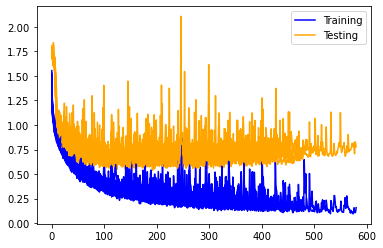

In [14]:
for i, history in enumerate(histories):
    pl.plot(history.history['loss'], label='Training', color="blue")
    pl.plot(history.history['val_loss'], label='Testing', color="orange")
    
    if i == 0:
        pl.legend()
        
    pl.grid()

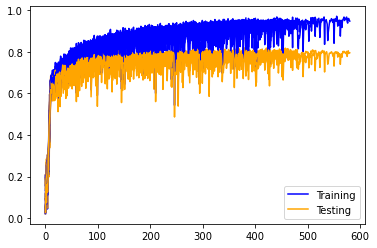

In [15]:
for i, history in enumerate(histories):
    pl.plot(history.history['f1_score_train'], label='Training', color="blue")
    pl.plot(history.history['f1_score_val'], label='Testing', color="orange")
    
    if i == 0:
        pl.legend()
        
    pl.grid()

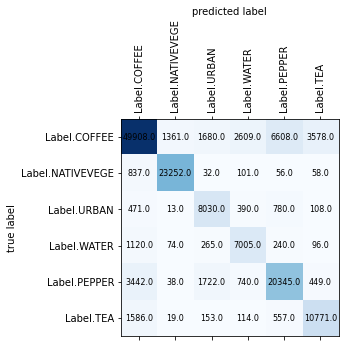

In [16]:
plot_confusion_matrix(conf_matrix, labels)

In [17]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrix)

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.87002301 0.93920911 0.67581215 0.63920066 0.71171203 0.71520584]
Mean precision:  0.7585271339186866

Recalls:  [0.75912631 0.95545694 0.82005719 0.79602273 0.76095901 0.81598485]
Mean recall:  0.8179345027022121

F-Score:  [0.81080027 0.94726336 0.74097998 0.70904398 0.73551209 0.76227884]
Mean f-score:  0.7843130863977247


 # Whole year 2017

In [19]:
dataset_args = dict(
    labels = labels,
    raster_paths = [DATA_ROOT_PATH + 'Vietnam_2017_whole_year/merged.tif'],
    labels_coordinates_list = [LABELS_COORDINATES],
    nb_pixel_around = NB_PIXEL_AROUND
)

dataset = make_dataset_from_raster_files(**dataset_args)

model_name = "whole_year_2017"

# images have all the same shapes, take the shape of the first image
image_width = len(dataset[0][1][0][0])
image_height = len(dataset[0][1][0])
image_depth = len(bands)
nb_outputs = len(labels)

# Create model
model = Sequential([
    Rescaling(1./2**16, input_shape=(image_width, image_height, image_depth)),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),
    SpatialDropout2D(0.25),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(nb_outputs, activation='softmax'),
])

mean_loss, mean_accuracy, histories, conf_matrix = cross_validation(model, dataset, bands, labels, EPOCHS, NB_TESTS, early_stopping=True, with_model_checkpoint=True, model_name=model_name)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 9, 9, 7)           0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 9, 9, 7)           28        
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 9, 9, 32)          2048      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 9, 9, 32)          9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 3, 3, 64)          18496     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 3, 3, 64)         

58/58 [==============================] - 0s 8ms/step - loss: 0.4181 - accuracy: 0.7649 - val_loss: 0.6656 - val_accuracy: 0.7547
Epoch 101/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.3713 - accuracy: 0.7735 - val_loss: 0.6571 - val_accuracy: 0.7609
Epoch 102/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.4130 - accuracy: 0.7778 - val_loss: 0.7188 - val_accuracy: 0.7383
Epoch 103/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.3703 - accuracy: 0.7988 - val_loss: 0.6645 - val_accuracy: 0.7722
Epoch 104/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3381 - accuracy: 0.8101 - val_loss: 0.6532 - val_accuracy: 0.7741
Epoch 105/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.3541 - accuracy: 0.8107 - val_loss: 0.6381 - val_accuracy: 0.7832
Epoch 106/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.3246 - accuracy: 0.8203 - val_loss: 0.6907 - val_accuracy: 0.7582
Epoch 1

Epoch 157/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2793 - accuracy: 0.8386 - val_loss: 0.6622 - val_accuracy: 0.7977
Epoch 158/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.3186 - accuracy: 0.8354 - val_loss: 0.6850 - val_accuracy: 0.7772
Epoch 159/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.3874 - accuracy: 0.7854 - val_loss: 0.6947 - val_accuracy: 0.7684
Epoch 160/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.4250 - accuracy: 0.7848 - val_loss: 0.7619 - val_accuracy: 0.7400
Epoch 161/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.4102 - accuracy: 0.8096 - val_loss: 0.6496 - val_accuracy: 0.7637
Epoch 162/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3250 - accuracy: 0.8295 - val_loss: 0.6460 - val_accuracy: 0.7768
Epoch 163/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3260 - accuracy: 0.8069 - val_loss: 0.6495 - val_accuracy:

Epoch 214/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2714 - accuracy: 0.8612 - val_loss: 0.6588 - val_accuracy: 0.7959
Epoch 215/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.3711 - accuracy: 0.8107 - val_loss: 0.7763 - val_accuracy: 0.7435
Epoch 216/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3189 - accuracy: 0.8295 - val_loss: 0.7440 - val_accuracy: 0.7563
Epoch 217/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2570 - accuracy: 0.8462 - val_loss: 0.6917 - val_accuracy: 0.7710
Epoch 218/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2068 - accuracy: 0.8833 - val_loss: 0.6753 - val_accuracy: 0.7844
Epoch 219/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2917 - accuracy: 0.8408 - val_loss: 0.6508 - val_accuracy: 0.7948
Epoch 220/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2626 - accuracy: 0.8612 - val_loss: 0.7171 - val_accuracy:

Epoch 271/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1600 - accuracy: 0.8999 - val_loss: 0.7189 - val_accuracy: 0.8034
Epoch 272/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1682 - accuracy: 0.9010 - val_loss: 0.7356 - val_accuracy: 0.8043
Epoch 273/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1363 - accuracy: 0.9161 - val_loss: 0.7486 - val_accuracy: 0.8068
Epoch 274/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1500 - accuracy: 0.9139 - val_loss: 0.7504 - val_accuracy: 0.8182
Epoch 275/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1559 - accuracy: 0.9042 - val_loss: 0.8401 - val_accuracy: 0.7835
Epoch 276/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1906 - accuracy: 0.8860 - val_loss: 0.7728 - val_accuracy: 0.8023
Epoch 277/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1520 - accuracy: 0.9064 - val_loss: 0.8018 - val_accuracy:

Epoch 328/2000
58/58 [==============================] - 1s 12ms/step - loss: 0.2738 - accuracy: 0.8472 - val_loss: 0.6679 - val_accuracy: 0.7799
Epoch 329/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.2320 - accuracy: 0.8709 - val_loss: 0.6942 - val_accuracy: 0.7870
Epoch 330/2000
58/58 [==============================] - 1s 12ms/step - loss: 0.1729 - accuracy: 0.9016 - val_loss: 0.7421 - val_accuracy: 0.7788
Epoch 331/2000
58/58 [==============================] - 1s 12ms/step - loss: 0.1738 - accuracy: 0.9005 - val_loss: 0.7244 - val_accuracy: 0.7976
Epoch 332/2000
58/58 [==============================] - 1s 12ms/step - loss: 0.2226 - accuracy: 0.8779 - val_loss: 0.7015 - val_accuracy: 0.7877
Epoch 333/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.1819 - accuracy: 0.8962 - val_loss: 0.8449 - val_accuracy: 0.7507
Epoch 334/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.2231 - accuracy: 0.8682 - val_loss: 0.8567 - val_ac

Epoch 441/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2101 - accuracy: 0.8618 - val_loss: 0.7894 - val_accuracy: 0.7874
Epoch 442/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1615 - accuracy: 0.9112 - val_loss: 0.8176 - val_accuracy: 0.7827
Epoch 443/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1615 - accuracy: 0.9182 - val_loss: 0.7966 - val_accuracy: 0.7951
Epoch 444/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1380 - accuracy: 0.9172 - val_loss: 0.7849 - val_accuracy: 0.7983
Epoch 445/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1791 - accuracy: 0.8994 - val_loss: 0.7935 - val_accuracy: 0.7866
Epoch 446/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1539 - accuracy: 0.9166 - val_loss: 0.7808 - val_accuracy: 0.7944
Epoch 447/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2238 - accuracy: 0.8876 - val_loss: 0.7797 - val_accuracy:

Epoch 39/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.6485 - accuracy: 0.6245 - val_loss: 0.8117 - val_accuracy: 0.6719
Epoch 40/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.7285 - accuracy: 0.6229 - val_loss: 0.9618 - val_accuracy: 0.5869
Epoch 41/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.6402 - accuracy: 0.6455 - val_loss: 0.8067 - val_accuracy: 0.6583
Epoch 42/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.6170 - accuracy: 0.6482 - val_loss: 0.8193 - val_accuracy: 0.6715
Epoch 43/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.6063 - accuracy: 0.6611 - val_loss: 0.9969 - val_accuracy: 0.5984
Epoch 44/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.6183 - accuracy: 0.6444 - val_loss: 0.8615 - val_accuracy: 0.6584
Epoch 45/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.6073 - accuracy: 0.6563 - val_loss: 0.7753 - val_accuracy: 0.6935

Epoch 153/2000
58/58 [==============================] - 1s 13ms/step - loss: 0.2746 - accuracy: 0.8268 - val_loss: 0.6510 - val_accuracy: 0.7840
Epoch 154/2000
58/58 [==============================] - 1s 13ms/step - loss: 0.3624 - accuracy: 0.7945 - val_loss: 1.6907 - val_accuracy: 0.5094
Epoch 155/2000
58/58 [==============================] - 1s 12ms/step - loss: 0.8047 - accuracy: 0.6132 - val_loss: 0.8551 - val_accuracy: 0.6369
Epoch 156/2000
58/58 [==============================] - 1s 13ms/step - loss: 0.5468 - accuracy: 0.6912 - val_loss: 0.7773 - val_accuracy: 0.7070
Epoch 157/2000
58/58 [==============================] - 1s 13ms/step - loss: 0.4713 - accuracy: 0.7375 - val_loss: 0.7627 - val_accuracy: 0.6990
Epoch 158/2000
58/58 [==============================] - 1s 14ms/step - loss: 0.3664 - accuracy: 0.7918 - val_loss: 0.6665 - val_accuracy: 0.7509
Epoch 159/2000
58/58 [==============================] - 1s 13ms/step - loss: 0.3263 - accuracy: 0.8150 - val_loss: 0.7112 - val_ac

58/58 [==============================] - 1s 15ms/step - loss: 0.2374 - accuracy: 0.8682 - val_loss: 0.7246 - val_accuracy: 0.7899
Epoch 266/2000
58/58 [==============================] - 1s 17ms/step - loss: 0.2417 - accuracy: 0.8531 - val_loss: 0.7168 - val_accuracy: 0.7866
Epoch 267/2000
58/58 [==============================] - 1s 16ms/step - loss: 0.2098 - accuracy: 0.8661 - val_loss: 0.6701 - val_accuracy: 0.8010
Epoch 268/2000
58/58 [==============================] - 1s 16ms/step - loss: 0.2097 - accuracy: 0.8623 - val_loss: 0.8253 - val_accuracy: 0.7566
Epoch 269/2000
58/58 [==============================] - 1s 18ms/step - loss: 0.3609 - accuracy: 0.8015 - val_loss: 0.6387 - val_accuracy: 0.7860
Epoch 270/2000
58/58 [==============================] - 1s 12ms/step - loss: 0.2688 - accuracy: 0.8343 - val_loss: 0.6430 - val_accuracy: 0.7951
Epoch 271/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.2014 - accuracy: 0.8790 - val_loss: 0.6448 - val_accuracy: 0.8014


58/58 [==============================] - 1s 13ms/step - loss: 0.1805 - accuracy: 0.8860 - val_loss: 0.7719 - val_accuracy: 0.8045
Epoch 378/2000
58/58 [==============================] - 1s 13ms/step - loss: 0.1372 - accuracy: 0.9037 - val_loss: 0.7375 - val_accuracy: 0.8147
Epoch 379/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.1795 - accuracy: 0.8940 - val_loss: 0.9072 - val_accuracy: 0.7760
Epoch 380/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.2057 - accuracy: 0.8811 - val_loss: 0.7507 - val_accuracy: 0.7979
Epoch 381/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.1912 - accuracy: 0.8994 - val_loss: 0.7219 - val_accuracy: 0.8029
Epoch 382/2000
58/58 [==============================] - 1s 13ms/step - loss: 0.1693 - accuracy: 0.8935 - val_loss: 0.7104 - val_accuracy: 0.8043
Epoch 383/2000
58/58 [==============================] - 1s 15ms/step - loss: 0.2180 - accuracy: 0.8725 - val_loss: 0.7270 - val_accuracy: 0.8055


58/58 [==============================] - 1s 15ms/step - loss: 0.2406 - accuracy: 0.8494 - val_loss: 0.7643 - val_accuracy: 0.7889
Epoch 490/2000
58/58 [==============================] - 1s 14ms/step - loss: 0.1651 - accuracy: 0.8999 - val_loss: 0.7842 - val_accuracy: 0.7938
Epoch 491/2000
58/58 [==============================] - 1s 16ms/step - loss: 0.1510 - accuracy: 0.9005 - val_loss: 0.7735 - val_accuracy: 0.8026
Epoch 492/2000
58/58 [==============================] - 1s 16ms/step - loss: 0.1933 - accuracy: 0.8843 - val_loss: 0.9319 - val_accuracy: 0.7551
Epoch 493/2000
58/58 [==============================] - 1s 18ms/step - loss: 0.1876 - accuracy: 0.8779 - val_loss: 0.7822 - val_accuracy: 0.8035
Epoch 494/2000
58/58 [==============================] - 1s 15ms/step - loss: 0.1515 - accuracy: 0.9037 - val_loss: 0.7330 - val_accuracy: 0.8154
Epoch 495/2000
58/58 [==============================] - 1s 16ms/step - loss: 0.1487 - accuracy: 0.9080 - val_loss: 0.8162 - val_accuracy: 0.8007


58/58 [==============================] - 1s 14ms/step - loss: 0.8629 - accuracy: 0.5390 - val_loss: 0.9844 - val_accuracy: 0.5237
Epoch 15/2000
58/58 [==============================] - 1s 13ms/step - loss: 0.8267 - accuracy: 0.5487 - val_loss: 1.0017 - val_accuracy: 0.5508
Epoch 16/2000
58/58 [==============================] - 1s 13ms/step - loss: 0.8113 - accuracy: 0.5680 - val_loss: 1.0207 - val_accuracy: 0.5124
Epoch 17/2000
58/58 [==============================] - 1s 12ms/step - loss: 0.8270 - accuracy: 0.5293 - val_loss: 1.0543 - val_accuracy: 0.5518
Epoch 18/2000
58/58 [==============================] - 1s 14ms/step - loss: 0.8378 - accuracy: 0.5557 - val_loss: 0.9760 - val_accuracy: 0.5994
Epoch 19/2000
58/58 [==============================] - 1s 15ms/step - loss: 0.8049 - accuracy: 0.5740 - val_loss: 0.9015 - val_accuracy: 0.5810
Epoch 20/2000
58/58 [==============================] - 1s 16ms/step - loss: 0.7562 - accuracy: 0.5793 - val_loss: 0.9272 - val_accuracy: 0.5732
Epoch 

Epoch 71/2000
58/58 [==============================] - 1s 15ms/step - loss: 0.4922 - accuracy: 0.7348 - val_loss: 0.7967 - val_accuracy: 0.6904
Epoch 72/2000
58/58 [==============================] - 1s 15ms/step - loss: 0.5163 - accuracy: 0.7364 - val_loss: 0.6961 - val_accuracy: 0.7282
Epoch 73/2000
58/58 [==============================] - 1s 16ms/step - loss: 0.4838 - accuracy: 0.7230 - val_loss: 0.7698 - val_accuracy: 0.7012
Epoch 74/2000
58/58 [==============================] - 1s 16ms/step - loss: 0.4550 - accuracy: 0.7526 - val_loss: 0.7038 - val_accuracy: 0.7292
Epoch 75/2000
58/58 [==============================] - 1s 15ms/step - loss: 0.4299 - accuracy: 0.7612 - val_loss: 0.8100 - val_accuracy: 0.6811
Epoch 76/2000
58/58 [==============================] - 1s 15ms/step - loss: 0.4110 - accuracy: 0.7536 - val_loss: 0.6555 - val_accuracy: 0.7450
Epoch 77/2000
58/58 [==============================] - 1s 16ms/step - loss: 0.4713 - accuracy: 0.7407 - val_loss: 0.8874 - val_accuracy:

Epoch 128/2000
58/58 [==============================] - 1s 15ms/step - loss: 0.4325 - accuracy: 0.7601 - val_loss: 0.8104 - val_accuracy: 0.6747
Epoch 129/2000
58/58 [==============================] - 1s 16ms/step - loss: 0.3208 - accuracy: 0.8004 - val_loss: 0.6622 - val_accuracy: 0.7669
Epoch 130/2000
58/58 [==============================] - 1s 16ms/step - loss: 0.3153 - accuracy: 0.8230 - val_loss: 0.6745 - val_accuracy: 0.7633
Epoch 131/2000
58/58 [==============================] - 1s 15ms/step - loss: 0.3392 - accuracy: 0.8203 - val_loss: 0.6759 - val_accuracy: 0.7591
Epoch 132/2000
58/58 [==============================] - 1s 15ms/step - loss: 0.3405 - accuracy: 0.8144 - val_loss: 0.6463 - val_accuracy: 0.7626
Epoch 133/2000
58/58 [==============================] - 1s 15ms/step - loss: 0.3463 - accuracy: 0.7934 - val_loss: 0.6338 - val_accuracy: 0.7664
Epoch 134/2000
58/58 [==============================] - 1s 16ms/step - loss: 0.3052 - accuracy: 0.8236 - val_loss: 0.6070 - val_ac

58/58 [==============================] - 1s 17ms/step - loss: 0.2103 - accuracy: 0.8752 - val_loss: 0.8916 - val_accuracy: 0.7049
Epoch 241/2000
58/58 [==============================] - 1s 18ms/step - loss: 0.2633 - accuracy: 0.8467 - val_loss: 0.6883 - val_accuracy: 0.7692
Epoch 242/2000
58/58 [==============================] - 1s 14ms/step - loss: 0.2168 - accuracy: 0.8655 - val_loss: 0.7038 - val_accuracy: 0.7683
Epoch 243/2000
58/58 [==============================] - 1s 18ms/step - loss: 0.1921 - accuracy: 0.8833 - val_loss: 0.6310 - val_accuracy: 0.8038
Epoch 244/2000
58/58 [==============================] - 1s 14ms/step - loss: 0.1978 - accuracy: 0.8865 - val_loss: 0.6459 - val_accuracy: 0.7961
Epoch 245/2000
58/58 [==============================] - 1s 16ms/step - loss: 0.1801 - accuracy: 0.9010 - val_loss: 0.6532 - val_accuracy: 0.7972
Epoch 246/2000
58/58 [==============================] - 1s 15ms/step - loss: 0.1745 - accuracy: 0.8930 - val_loss: 0.6259 - val_accuracy: 0.8062


58/58 [==============================] - 1s 14ms/step - loss: 0.9965 - accuracy: 0.4637 - val_loss: 1.5555 - val_accuracy: 0.2634
Epoch 7/2000
58/58 [==============================] - 1s 17ms/step - loss: 0.9631 - accuracy: 0.4992 - val_loss: 1.4706 - val_accuracy: 0.2663
Epoch 8/2000
58/58 [==============================] - 1s 21ms/step - loss: 0.9605 - accuracy: 0.4906 - val_loss: 1.4577 - val_accuracy: 0.2487
Epoch 9/2000
58/58 [==============================] - 1s 15ms/step - loss: 0.9628 - accuracy: 0.4809 - val_loss: 1.2121 - val_accuracy: 0.4320
Epoch 10/2000
58/58 [==============================] - 1s 14ms/step - loss: 0.9442 - accuracy: 0.5110 - val_loss: 1.1127 - val_accuracy: 0.5017
Epoch 11/2000
58/58 [==============================] - 1s 15ms/step - loss: 0.8677 - accuracy: 0.5401 - val_loss: 1.0240 - val_accuracy: 0.5715
Epoch 12/2000
58/58 [==============================] - 1s 13ms/step - loss: 0.9193 - accuracy: 0.5299 - val_loss: 1.0020 - val_accuracy: 0.5266
Epoch 13/

58/58 [==============================] - 1s 16ms/step - loss: 0.5002 - accuracy: 0.7359 - val_loss: 0.6887 - val_accuracy: 0.7263
Epoch 64/2000
58/58 [==============================] - 1s 18ms/step - loss: 0.4664 - accuracy: 0.7434 - val_loss: 0.7838 - val_accuracy: 0.6884
Epoch 65/2000
58/58 [==============================] - 1s 18ms/step - loss: 0.5105 - accuracy: 0.7230 - val_loss: 0.9398 - val_accuracy: 0.6127
Epoch 66/2000
58/58 [==============================] - 1s 17ms/step - loss: 0.4968 - accuracy: 0.7283 - val_loss: 0.7333 - val_accuracy: 0.7177
Epoch 67/2000
58/58 [==============================] - 1s 17ms/step - loss: 0.4842 - accuracy: 0.7407 - val_loss: 0.8305 - val_accuracy: 0.6643
Epoch 68/2000
58/58 [==============================] - 1s 17ms/step - loss: 0.5252 - accuracy: 0.7294 - val_loss: 0.6826 - val_accuracy: 0.7336
Epoch 69/2000
58/58 [==============================] - 1s 17ms/step - loss: 0.4810 - accuracy: 0.7461 - val_loss: 0.7631 - val_accuracy: 0.6959
Epoch 

Epoch 120/2000
58/58 [==============================] - 1s 18ms/step - loss: 0.3313 - accuracy: 0.8187 - val_loss: 0.8252 - val_accuracy: 0.7075
Epoch 121/2000
58/58 [==============================] - 1s 19ms/step - loss: 0.3402 - accuracy: 0.8074 - val_loss: 0.6211 - val_accuracy: 0.7738
Epoch 122/2000
58/58 [==============================] - 1s 16ms/step - loss: 0.3328 - accuracy: 0.8074 - val_loss: 0.6391 - val_accuracy: 0.7795
Epoch 123/2000
58/58 [==============================] - 1s 17ms/step - loss: 0.3116 - accuracy: 0.8209 - val_loss: 0.6485 - val_accuracy: 0.7702
Epoch 124/2000
58/58 [==============================] - 1s 17ms/step - loss: 0.3030 - accuracy: 0.8236 - val_loss: 0.7312 - val_accuracy: 0.7461
Epoch 125/2000
58/58 [==============================] - 1s 15ms/step - loss: 0.3327 - accuracy: 0.8117 - val_loss: 0.6763 - val_accuracy: 0.7691
Epoch 126/2000
58/58 [==============================] - 1s 16ms/step - loss: 0.3000 - accuracy: 0.8171 - val_loss: 0.7085 - val_ac

58/58 [==============================] - 1s 13ms/step - loss: 0.1998 - accuracy: 0.8811 - val_loss: 0.7041 - val_accuracy: 0.7961
Epoch 233/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2686 - accuracy: 0.8472 - val_loss: 0.8987 - val_accuracy: 0.7418
Epoch 234/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.3074 - accuracy: 0.8419 - val_loss: 0.6860 - val_accuracy: 0.7893
Epoch 235/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2630 - accuracy: 0.8510 - val_loss: 0.7275 - val_accuracy: 0.7926
Epoch 236/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2417 - accuracy: 0.8607 - val_loss: 0.7278 - val_accuracy: 0.7699
Epoch 237/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.2716 - accuracy: 0.8515 - val_loss: 0.7196 - val_accuracy: 0.7727
Epoch 238/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2179 - accuracy: 0.8714 - val_loss: 0.6650 - val_accuracy: 0.7977
Epoch

Epoch 289/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.1968 - accuracy: 0.8951 - val_loss: 0.8225 - val_accuracy: 0.7591
Epoch 290/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.1821 - accuracy: 0.8956 - val_loss: 0.7431 - val_accuracy: 0.7832
Epoch 291/2000
58/58 [==============================] - 1s 12ms/step - loss: 0.2241 - accuracy: 0.8580 - val_loss: 0.6809 - val_accuracy: 0.7934
Epoch 292/2000
58/58 [==============================] - 1s 12ms/step - loss: 0.2326 - accuracy: 0.8779 - val_loss: 0.7354 - val_accuracy: 0.7832
Epoch 293/2000
58/58 [==============================] - 1s 13ms/step - loss: 0.1738 - accuracy: 0.9032 - val_loss: 0.7259 - val_accuracy: 0.7961
Epoch 294/2000
58/58 [==============================] - 1s 12ms/step - loss: 0.1878 - accuracy: 0.8930 - val_loss: 0.7207 - val_accuracy: 0.8030
Epoch 295/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.1823 - accuracy: 0.8892 - val_loss: 0.7340 - val_ac

58/58 [==============================] - 1s 13ms/step - loss: 0.4219 - accuracy: 0.7940 - val_loss: 0.7066 - val_accuracy: 0.7413
Epoch 104/2000
58/58 [==============================] - 1s 13ms/step - loss: 0.3596 - accuracy: 0.8069 - val_loss: 0.7013 - val_accuracy: 0.7465
Epoch 105/2000
58/58 [==============================] - 1s 12ms/step - loss: 0.3893 - accuracy: 0.7918 - val_loss: 0.7261 - val_accuracy: 0.7262
Epoch 106/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.3727 - accuracy: 0.7870 - val_loss: 0.6706 - val_accuracy: 0.7565
Epoch 107/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.3172 - accuracy: 0.8338 - val_loss: 0.7393 - val_accuracy: 0.7356
Epoch 108/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.3764 - accuracy: 0.7988 - val_loss: 0.8873 - val_accuracy: 0.6924
Epoch 109/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.4175 - accuracy: 0.7778 - val_loss: 0.6177 - val_accuracy: 0.7699


58/58 [==============================] - 1s 11ms/step - loss: 0.2388 - accuracy: 0.8666 - val_loss: 0.6445 - val_accuracy: 0.7953
Epoch 216/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.2747 - accuracy: 0.8596 - val_loss: 0.8518 - val_accuracy: 0.7227
Epoch 217/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.2220 - accuracy: 0.8682 - val_loss: 0.6194 - val_accuracy: 0.8015
Epoch 218/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.2393 - accuracy: 0.8687 - val_loss: 0.6699 - val_accuracy: 0.7823
Epoch 219/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.2114 - accuracy: 0.8795 - val_loss: 0.6478 - val_accuracy: 0.8037
Epoch 220/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.2293 - accuracy: 0.8682 - val_loss: 0.6441 - val_accuracy: 0.7922
Epoch 221/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.2455 - accuracy: 0.8698 - val_loss: 0.6860 - val_accuracy: 0.7809


Epoch 272/2000
58/58 [==============================] - 1s 12ms/step - loss: 0.1927 - accuracy: 0.8854 - val_loss: 0.7047 - val_accuracy: 0.7879
Epoch 273/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.1869 - accuracy: 0.8881 - val_loss: 0.6918 - val_accuracy: 0.7918
Epoch 274/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.2666 - accuracy: 0.8456 - val_loss: 0.8596 - val_accuracy: 0.7309
Epoch 275/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.3020 - accuracy: 0.8419 - val_loss: 0.7531 - val_accuracy: 0.7548
Epoch 276/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.2215 - accuracy: 0.8704 - val_loss: 0.6891 - val_accuracy: 0.7930
Epoch 277/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2048 - accuracy: 0.8881 - val_loss: 0.7076 - val_accuracy: 0.7847
Epoch 278/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2083 - accuracy: 0.8822 - val_loss: 0.7163 - val_accu

58/58 [==============================] - 1s 9ms/step - loss: 0.5114 - accuracy: 0.7439 - val_loss: 0.7735 - val_accuracy: 0.6969
Epoch 67/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.4942 - accuracy: 0.7499 - val_loss: 0.7929 - val_accuracy: 0.6783
Epoch 68/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.4931 - accuracy: 0.7504 - val_loss: 0.7235 - val_accuracy: 0.7132
Epoch 69/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.5028 - accuracy: 0.7321 - val_loss: 0.7442 - val_accuracy: 0.7004
Epoch 70/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.5223 - accuracy: 0.7321 - val_loss: 0.8129 - val_accuracy: 0.6742
Epoch 71/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.5138 - accuracy: 0.7483 - val_loss: 0.6905 - val_accuracy: 0.7232
Epoch 72/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.5211 - accuracy: 0.7343 - val_loss: 0.7824 - val_accuracy: 0.6797
Epoch 73/20

Epoch 123/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.3412 - accuracy: 0.8096 - val_loss: 0.7473 - val_accuracy: 0.7204
Epoch 124/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.4978 - accuracy: 0.7843 - val_loss: 0.7425 - val_accuracy: 0.7177
Epoch 125/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.3747 - accuracy: 0.7945 - val_loss: 0.7645 - val_accuracy: 0.7001
Epoch 126/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.3441 - accuracy: 0.8010 - val_loss: 0.6813 - val_accuracy: 0.7488
Epoch 127/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.3241 - accuracy: 0.8133 - val_loss: 0.6603 - val_accuracy: 0.7710
Epoch 128/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.3758 - accuracy: 0.7902 - val_loss: 0.7200 - val_accuracy: 0.7395
Epoch 129/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.3702 - accuracy: 0.7967 - val_loss: 0.6902 - val_accu

58/58 [==============================] - 1s 9ms/step - loss: 0.2859 - accuracy: 0.8343 - val_loss: 0.8798 - val_accuracy: 0.6904
Epoch 236/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2834 - accuracy: 0.8349 - val_loss: 0.6613 - val_accuracy: 0.7846
Epoch 237/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2269 - accuracy: 0.8628 - val_loss: 0.8360 - val_accuracy: 0.7413
Epoch 238/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.2832 - accuracy: 0.8257 - val_loss: 0.7171 - val_accuracy: 0.7461
Epoch 239/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.2639 - accuracy: 0.8499 - val_loss: 0.6950 - val_accuracy: 0.7751
Epoch 240/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2225 - accuracy: 0.8537 - val_loss: 0.7769 - val_accuracy: 0.7655
Epoch 241/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2916 - accuracy: 0.8413 - val_loss: 0.6854 - val_accuracy: 0.7714
Epoch

Epoch 292/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.2062 - accuracy: 0.8817 - val_loss: 0.8170 - val_accuracy: 0.7640
Epoch 293/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2182 - accuracy: 0.8682 - val_loss: 0.7271 - val_accuracy: 0.7776
Epoch 294/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.3128 - accuracy: 0.8381 - val_loss: 0.7341 - val_accuracy: 0.7672
Epoch 295/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2185 - accuracy: 0.8725 - val_loss: 0.7611 - val_accuracy: 0.7515
Epoch 296/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2193 - accuracy: 0.8693 - val_loss: 0.6857 - val_accuracy: 0.7870
Epoch 297/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2498 - accuracy: 0.8488 - val_loss: 0.6778 - val_accuracy: 0.7859
Epoch 298/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2066 - accuracy: 0.8736 - val_loss: 0.7967 - val_accuracy

Epoch 405/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.1506 - accuracy: 0.9037 - val_loss: 0.7899 - val_accuracy: 0.7921
Epoch 406/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.1516 - accuracy: 0.9091 - val_loss: 0.8288 - val_accuracy: 0.7881
Epoch 407/2000
58/58 [==============================] - 1s 12ms/step - loss: 0.2007 - accuracy: 0.8870 - val_loss: 0.7928 - val_accuracy: 0.7885
Epoch 408/2000
58/58 [==============================] - 1s 12ms/step - loss: 0.1525 - accuracy: 0.9069 - val_loss: 0.7918 - val_accuracy: 0.7902
Epoch 409/2000
58/58 [==============================] - 1s 12ms/step - loss: 0.1925 - accuracy: 0.9037 - val_loss: 0.7208 - val_accuracy: 0.7936
Epoch 410/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.2417 - accuracy: 0.8892 - val_loss: 0.7662 - val_accuracy: 0.7839
Epoch 411/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.2626 - accuracy: 0.8639 - val_loss: 0.7423 - val_ac

Epoch 518/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.2001 - accuracy: 0.8967 - val_loss: 0.7666 - val_accuracy: 0.7926
Epoch 519/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.1327 - accuracy: 0.9231 - val_loss: 0.7412 - val_accuracy: 0.8035
Epoch 520/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.1240 - accuracy: 0.9258 - val_loss: 0.8128 - val_accuracy: 0.8002
Epoch 521/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.1286 - accuracy: 0.9328 - val_loss: 0.8275 - val_accuracy: 0.8030
Epoch 522/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.1406 - accuracy: 0.9193 - val_loss: 0.8297 - val_accuracy: 0.7863
Epoch 523/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.1579 - accuracy: 0.9107 - val_loss: 0.8370 - val_accuracy: 0.7885
Epoch 524/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.1778 - accuracy: 0.9204 - val_loss: 0.7853 - val_accur

58/58 [==============================] - 1s 10ms/step - loss: 0.5782 - accuracy: 0.7208 - val_loss: 0.8592 - val_accuracy: 0.6782
Epoch 50/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.5629 - accuracy: 0.7278 - val_loss: 0.7571 - val_accuracy: 0.7205
Epoch 51/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.5925 - accuracy: 0.7009 - val_loss: 0.8017 - val_accuracy: 0.6962
Epoch 52/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.5704 - accuracy: 0.7181 - val_loss: 0.7053 - val_accuracy: 0.7355
Epoch 53/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.5755 - accuracy: 0.7160 - val_loss: 0.6886 - val_accuracy: 0.7349
Epoch 54/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.5120 - accuracy: 0.7429 - val_loss: 0.8181 - val_accuracy: 0.6759
Epoch 55/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.5481 - accuracy: 0.7343 - val_loss: 0.9298 - val_accuracy: 0.6386
Epoch 

58/58 [==============================] - 1s 10ms/step - loss: 0.3381 - accuracy: 0.8171 - val_loss: 0.6908 - val_accuracy: 0.7587
Epoch 107/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.3117 - accuracy: 0.8332 - val_loss: 0.6489 - val_accuracy: 0.7785
Epoch 108/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.3477 - accuracy: 0.8295 - val_loss: 0.6545 - val_accuracy: 0.7602
Epoch 109/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.3529 - accuracy: 0.8101 - val_loss: 0.6982 - val_accuracy: 0.7430
Epoch 110/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.3436 - accuracy: 0.8150 - val_loss: 0.6735 - val_accuracy: 0.7585
Epoch 111/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.3765 - accuracy: 0.8117 - val_loss: 0.6640 - val_accuracy: 0.7589
Epoch 112/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.3550 - accuracy: 0.8085 - val_loss: 1.1916 - val_accuracy: 0.6335


Epoch 163/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.3925 - accuracy: 0.7999 - val_loss: 1.0981 - val_accuracy: 0.6346
Epoch 164/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.3448 - accuracy: 0.8074 - val_loss: 0.7087 - val_accuracy: 0.7644
Epoch 165/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.3107 - accuracy: 0.8316 - val_loss: 0.6715 - val_accuracy: 0.7585
Epoch 166/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.3166 - accuracy: 0.8144 - val_loss: 0.7221 - val_accuracy: 0.7426
Epoch 167/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.2844 - accuracy: 0.8494 - val_loss: 0.6738 - val_accuracy: 0.7760
Epoch 168/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.3176 - accuracy: 0.8316 - val_loss: 0.6761 - val_accuracy: 0.7790
Epoch 169/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.2851 - accuracy: 0.8548 - val_loss: 0.6731 - val_accu

Epoch 276/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.1884 - accuracy: 0.8886 - val_loss: 0.6921 - val_accuracy: 0.8008
Epoch 277/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.1725 - accuracy: 0.8930 - val_loss: 0.6776 - val_accuracy: 0.8182
Epoch 278/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.1788 - accuracy: 0.9032 - val_loss: 0.7396 - val_accuracy: 0.8030
Epoch 279/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.1896 - accuracy: 0.8935 - val_loss: 0.7025 - val_accuracy: 0.7961
Epoch 280/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.1448 - accuracy: 0.9096 - val_loss: 0.7070 - val_accuracy: 0.8109
Epoch 281/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.1545 - accuracy: 0.9086 - val_loss: 0.7056 - val_accuracy: 0.8108
Epoch 282/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.1799 - accuracy: 0.8978 - val_loss: 0.7388 - val_ac

Epoch 389/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.1502 - accuracy: 0.9112 - val_loss: 0.7112 - val_accuracy: 0.8068
Epoch 390/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.1344 - accuracy: 0.9204 - val_loss: 0.6615 - val_accuracy: 0.8140
Epoch 391/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.1283 - accuracy: 0.9242 - val_loss: 0.6897 - val_accuracy: 0.8158
Epoch 392/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.1245 - accuracy: 0.9290 - val_loss: 0.6993 - val_accuracy: 0.8107
Epoch 393/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.2092 - accuracy: 0.8897 - val_loss: 0.7602 - val_accuracy: 0.7842
Epoch 394/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.1577 - accuracy: 0.9080 - val_loss: 0.7130 - val_accuracy: 0.8078
Epoch 395/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.1609 - accuracy: 0.9064 - val_loss: 0.7769 - val_ac

58/58 [==============================] - 1s 9ms/step - loss: 0.6752 - accuracy: 0.6498 - val_loss: 0.8876 - val_accuracy: 0.6557
Epoch 34/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.6221 - accuracy: 0.6482 - val_loss: 0.7717 - val_accuracy: 0.6893
Epoch 35/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.6450 - accuracy: 0.6493 - val_loss: 0.8981 - val_accuracy: 0.6263
Epoch 36/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.5868 - accuracy: 0.6713 - val_loss: 0.7345 - val_accuracy: 0.7079
Epoch 37/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.5878 - accuracy: 0.6799 - val_loss: 0.7934 - val_accuracy: 0.6758
Epoch 38/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.6206 - accuracy: 0.6772 - val_loss: 0.8281 - val_accuracy: 0.6518
Epoch 39/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.6005 - accuracy: 0.6724 - val_loss: 0.8994 - val_accuracy: 0.6315
Epoch 40

58/58 [==============================] - 1s 10ms/step - loss: 0.3945 - accuracy: 0.7784 - val_loss: 0.6595 - val_accuracy: 0.7694
Epoch 91/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.3578 - accuracy: 0.8063 - val_loss: 0.6150 - val_accuracy: 0.7843
Epoch 92/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.3919 - accuracy: 0.7816 - val_loss: 0.7501 - val_accuracy: 0.7277
Epoch 93/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.4069 - accuracy: 0.7735 - val_loss: 0.6131 - val_accuracy: 0.7770
Epoch 94/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.4017 - accuracy: 0.7762 - val_loss: 0.7772 - val_accuracy: 0.7121
Epoch 95/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.3587 - accuracy: 0.8031 - val_loss: 0.6444 - val_accuracy: 0.7730
Epoch 96/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.4108 - accuracy: 0.7864 - val_loss: 0.6902 - val_accuracy: 0.7558
Epoch 97

Epoch 147/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.2412 - accuracy: 0.8445 - val_loss: 0.6386 - val_accuracy: 0.8050
Epoch 148/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2400 - accuracy: 0.8526 - val_loss: 0.6634 - val_accuracy: 0.7839
Epoch 149/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.3112 - accuracy: 0.8198 - val_loss: 0.6969 - val_accuracy: 0.7714
Epoch 150/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.3337 - accuracy: 0.8236 - val_loss: 0.7300 - val_accuracy: 0.7519
Epoch 151/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2985 - accuracy: 0.8219 - val_loss: 0.6214 - val_accuracy: 0.7956
Epoch 152/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2676 - accuracy: 0.8435 - val_loss: 0.6721 - val_accuracy: 0.7707
Epoch 153/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.3084 - accuracy: 0.8338 - val_loss: 0.8112 - val_accuracy

Epoch 204/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.2066 - accuracy: 0.8661 - val_loss: 0.6402 - val_accuracy: 0.8090
Epoch 205/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2157 - accuracy: 0.8698 - val_loss: 0.6593 - val_accuracy: 0.8055
Epoch 206/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2859 - accuracy: 0.8429 - val_loss: 0.6806 - val_accuracy: 0.7747
Epoch 207/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.2601 - accuracy: 0.8575 - val_loss: 0.6770 - val_accuracy: 0.7796
Epoch 208/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2412 - accuracy: 0.8682 - val_loss: 0.6640 - val_accuracy: 0.8015
Epoch 209/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.2108 - accuracy: 0.8736 - val_loss: 0.6708 - val_accuracy: 0.8035
Epoch 210/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2271 - accuracy: 0.8612 - val_loss: 0.8025 - val_accura

58/58 [==============================] - 1s 11ms/step - loss: 0.1558 - accuracy: 0.9032 - val_loss: 0.7596 - val_accuracy: 0.7838
Epoch 317/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.1605 - accuracy: 0.9215 - val_loss: 0.6916 - val_accuracy: 0.8183
Epoch 318/2000
58/58 [==============================] - 1s 13ms/step - loss: 0.1455 - accuracy: 0.9021 - val_loss: 0.6894 - val_accuracy: 0.8240
Epoch 319/2000
58/58 [==============================] - 1s 12ms/step - loss: 0.1587 - accuracy: 0.9032 - val_loss: 0.7407 - val_accuracy: 0.8215
Epoch 320/2000
58/58 [==============================] - 1s 12ms/step - loss: 0.1720 - accuracy: 0.9037 - val_loss: 0.7359 - val_accuracy: 0.8062
Epoch 321/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.2063 - accuracy: 0.8838 - val_loss: 1.0519 - val_accuracy: 0.7207
Epoch 322/2000
58/58 [==============================] - 1s 12ms/step - loss: 0.3240 - accuracy: 0.8230 - val_loss: 0.7223 - val_accuracy: 0.7764


58/58 [==============================] - 1s 12ms/step - loss: 0.4907 - accuracy: 0.7138 - val_loss: 0.9704 - val_accuracy: 0.6284
Epoch 84/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.4692 - accuracy: 0.7230 - val_loss: 0.8380 - val_accuracy: 0.7099
Epoch 85/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.3945 - accuracy: 0.7606 - val_loss: 0.7316 - val_accuracy: 0.7394
Epoch 86/2000
58/58 [==============================] - 1s 22ms/step - loss: 0.3549 - accuracy: 0.7918 - val_loss: 0.7266 - val_accuracy: 0.7462
Epoch 87/2000
58/58 [==============================] - 1s 15ms/step - loss: 0.4360 - accuracy: 0.7407 - val_loss: 0.7366 - val_accuracy: 0.7469
Epoch 88/2000
58/58 [==============================] - 1s 12ms/step - loss: 0.3913 - accuracy: 0.7698 - val_loss: 0.8426 - val_accuracy: 0.7071
Epoch 89/2000
58/58 [==============================] - 1s 14ms/step - loss: 0.4262 - accuracy: 0.7472 - val_loss: 0.8879 - val_accuracy: 0.6954
Epoch 9

Epoch 140/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.3146 - accuracy: 0.7956 - val_loss: 0.7829 - val_accuracy: 0.7484
Epoch 141/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.2781 - accuracy: 0.8263 - val_loss: 0.7514 - val_accuracy: 0.7602
Epoch 142/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.3090 - accuracy: 0.8085 - val_loss: 0.7691 - val_accuracy: 0.7665
Epoch 143/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.3237 - accuracy: 0.8107 - val_loss: 0.7274 - val_accuracy: 0.7788
Epoch 144/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.2964 - accuracy: 0.8230 - val_loss: 0.8106 - val_accuracy: 0.7454
Epoch 145/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.3409 - accuracy: 0.7977 - val_loss: 0.7421 - val_accuracy: 0.7500
Epoch 146/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.2735 - accuracy: 0.8252 - val_loss: 0.7316 - val_ac

Epoch 253/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.1878 - accuracy: 0.8822 - val_loss: 0.8534 - val_accuracy: 0.7895
Epoch 254/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.1829 - accuracy: 0.8779 - val_loss: 0.7399 - val_accuracy: 0.8045
Epoch 255/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.1907 - accuracy: 0.8854 - val_loss: 0.7904 - val_accuracy: 0.7920
Epoch 256/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2939 - accuracy: 0.8295 - val_loss: 0.7923 - val_accuracy: 0.7594
Epoch 257/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.2243 - accuracy: 0.8483 - val_loss: 0.8017 - val_accuracy: 0.7743
Epoch 258/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2168 - accuracy: 0.8655 - val_loss: 0.7669 - val_accuracy: 0.8024
Epoch 259/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.1895 - accuracy: 0.8779 - val_loss: 0.7690 - val_accura

Epoch 366/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.1613 - accuracy: 0.8903 - val_loss: 0.8537 - val_accuracy: 0.7906
Epoch 367/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.2193 - accuracy: 0.8935 - val_loss: 0.8420 - val_accuracy: 0.7800
Epoch 368/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.1707 - accuracy: 0.8940 - val_loss: 0.7734 - val_accuracy: 0.8097
Epoch 369/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2201 - accuracy: 0.8736 - val_loss: 0.8292 - val_accuracy: 0.7846
Epoch 370/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.1445 - accuracy: 0.8924 - val_loss: 0.7586 - val_accuracy: 0.8154
Epoch 371/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.1604 - accuracy: 0.9134 - val_loss: 0.8116 - val_accuracy: 0.8019
Epoch 372/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.1555 - accuracy: 0.9021 - val_loss: 0.8671 - val_accurac

Epoch 423/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.2096 - accuracy: 0.8531 - val_loss: 0.8474 - val_accuracy: 0.7712
Epoch 424/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.1813 - accuracy: 0.8886 - val_loss: 0.7918 - val_accuracy: 0.8057
Epoch 425/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.1530 - accuracy: 0.8956 - val_loss: 0.7948 - val_accuracy: 0.8068
Epoch 426/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.1415 - accuracy: 0.9075 - val_loss: 0.8207 - val_accuracy: 0.8172
Epoch 427/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.1337 - accuracy: 0.9204 - val_loss: 0.8328 - val_accuracy: 0.8121
Epoch 428/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.1267 - accuracy: 0.9263 - val_loss: 0.9793 - val_accuracy: 0.7847
Epoch 429/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.1743 - accuracy: 0.8892 - val_loss: 0.8758 - val_accur

Epoch 73/2000
58/58 [==============================] - 1s 12ms/step - loss: 0.4325 - accuracy: 0.7649 - val_loss: 0.7052 - val_accuracy: 0.7460
Epoch 74/2000
58/58 [==============================] - 1s 12ms/step - loss: 0.4148 - accuracy: 0.7827 - val_loss: 0.7584 - val_accuracy: 0.7279
Epoch 75/2000
58/58 [==============================] - 1s 12ms/step - loss: 0.4205 - accuracy: 0.7741 - val_loss: 0.8264 - val_accuracy: 0.7091
Epoch 76/2000
58/58 [==============================] - 1s 12ms/step - loss: 0.4647 - accuracy: 0.7375 - val_loss: 0.8474 - val_accuracy: 0.6881
Epoch 77/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.3991 - accuracy: 0.7816 - val_loss: 0.8272 - val_accuracy: 0.6806
Epoch 78/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.4078 - accuracy: 0.7751 - val_loss: 0.7172 - val_accuracy: 0.7386
Epoch 79/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.3787 - accuracy: 0.7795 - val_loss: 0.7830 - val_accuracy: 

Epoch 130/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.2573 - accuracy: 0.8467 - val_loss: 0.6972 - val_accuracy: 0.7683
Epoch 131/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.2664 - accuracy: 0.8408 - val_loss: 0.7302 - val_accuracy: 0.7628
Epoch 132/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.3164 - accuracy: 0.8338 - val_loss: 0.8420 - val_accuracy: 0.7187
Epoch 133/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.3236 - accuracy: 0.8133 - val_loss: 0.7100 - val_accuracy: 0.7569
Epoch 134/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.2721 - accuracy: 0.8268 - val_loss: 0.6800 - val_accuracy: 0.7712
Epoch 135/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.2334 - accuracy: 0.8537 - val_loss: 0.6992 - val_accuracy: 0.7780
Epoch 136/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.2377 - accuracy: 0.8505 - val_loss: 0.6905 - val_ac

Epoch 243/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2528 - accuracy: 0.8591 - val_loss: 0.7485 - val_accuracy: 0.7735
Epoch 244/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.2048 - accuracy: 0.8833 - val_loss: 0.8214 - val_accuracy: 0.7680
Epoch 245/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.1982 - accuracy: 0.8833 - val_loss: 0.7664 - val_accuracy: 0.7747
Epoch 246/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1624 - accuracy: 0.8897 - val_loss: 0.8117 - val_accuracy: 0.7796
Epoch 247/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1916 - accuracy: 0.8736 - val_loss: 0.7926 - val_accuracy: 0.7938
Epoch 248/2000
58/58 [==============================] - 1s 12ms/step - loss: 0.1999 - accuracy: 0.8827 - val_loss: 0.7474 - val_accuracy: 0.7824
Epoch 249/2000
58/58 [==============================] - 1s 13ms/step - loss: 0.1753 - accuracy: 0.8870 - val_loss: 0.7785 - val_accura

Epoch 300/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1671 - accuracy: 0.8913 - val_loss: 0.7908 - val_accuracy: 0.7774
Epoch 301/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1676 - accuracy: 0.8951 - val_loss: 0.7310 - val_accuracy: 0.7983
Epoch 302/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.3016 - accuracy: 0.8429 - val_loss: 0.7176 - val_accuracy: 0.7717
Epoch 303/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2053 - accuracy: 0.8886 - val_loss: 0.7461 - val_accuracy: 0.7858
Epoch 304/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1880 - accuracy: 0.8849 - val_loss: 0.7738 - val_accuracy: 0.7774
Epoch 305/2000
58/58 [==============================] - 0s 9ms/step - loss: 0.1559 - accuracy: 0.8892 - val_loss: 0.7714 - val_accuracy: 0.7894
Epoch 306/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.1726 - accuracy: 0.8860 - val_loss: 0.8325 - val_accuracy

Epoch 357/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1718 - accuracy: 0.9069 - val_loss: 0.7799 - val_accuracy: 0.7858
Epoch 358/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1628 - accuracy: 0.8924 - val_loss: 0.8565 - val_accuracy: 0.7813
Epoch 359/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1475 - accuracy: 0.9096 - val_loss: 0.8064 - val_accuracy: 0.7901
Epoch 360/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1379 - accuracy: 0.9145 - val_loss: 0.8009 - val_accuracy: 0.7912
Epoch 361/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2503 - accuracy: 0.8644 - val_loss: 0.7891 - val_accuracy: 0.7651
Epoch 362/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1970 - accuracy: 0.8806 - val_loss: 0.8153 - val_accuracy: 0.7941
Epoch 363/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.1558 - accuracy: 0.9032 - val_loss: 0.8545 - val_accuracy

Epoch 414/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2131 - accuracy: 0.8790 - val_loss: 0.8650 - val_accuracy: 0.7651
Epoch 415/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1784 - accuracy: 0.8924 - val_loss: 0.8063 - val_accuracy: 0.7805
Epoch 416/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1405 - accuracy: 0.9118 - val_loss: 0.7793 - val_accuracy: 0.7899
Epoch 417/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1561 - accuracy: 0.9059 - val_loss: 0.8714 - val_accuracy: 0.7749
Epoch 418/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1848 - accuracy: 0.8930 - val_loss: 0.8433 - val_accuracy: 0.7799
Epoch 419/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1632 - accuracy: 0.8935 - val_loss: 0.9170 - val_accuracy: 0.7825
Epoch 420/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1399 - accuracy: 0.9139 - val_loss: 0.8131 - val_accuracy:

Epoch 471/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1392 - accuracy: 0.9225 - val_loss: 0.9304 - val_accuracy: 0.7929
Epoch 472/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1376 - accuracy: 0.9091 - val_loss: 0.8679 - val_accuracy: 0.8084
Epoch 473/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1557 - accuracy: 0.9075 - val_loss: 0.8642 - val_accuracy: 0.8024
Epoch 474/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1177 - accuracy: 0.9242 - val_loss: 0.8762 - val_accuracy: 0.8086
Epoch 475/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1441 - accuracy: 0.9107 - val_loss: 0.9592 - val_accuracy: 0.7739
Epoch 476/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1394 - accuracy: 0.9166 - val_loss: 0.8431 - val_accuracy: 0.8121
Epoch 477/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1392 - accuracy: 0.9285 - val_loss: 0.8868 - val_accuracy:

Epoch 528/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1558 - accuracy: 0.9069 - val_loss: 0.7886 - val_accuracy: 0.8057
Epoch 529/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1368 - accuracy: 0.9263 - val_loss: 0.9008 - val_accuracy: 0.7881
Epoch 530/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2318 - accuracy: 0.8827 - val_loss: 0.8903 - val_accuracy: 0.7546
Epoch 531/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1819 - accuracy: 0.8930 - val_loss: 0.8215 - val_accuracy: 0.7909
Epoch 532/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1164 - accuracy: 0.9258 - val_loss: 0.9052 - val_accuracy: 0.7854
Epoch 533/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1419 - accuracy: 0.9134 - val_loss: 0.8732 - val_accuracy: 0.7980
Epoch 534/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1514 - accuracy: 0.9112 - val_loss: 0.9098 - val_accuracy:

58/58 [==============================] - 0s 7ms/step - loss: 0.5177 - accuracy: 0.7138 - val_loss: 0.6935 - val_accuracy: 0.7375
Epoch 66/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.5115 - accuracy: 0.7273 - val_loss: 0.7532 - val_accuracy: 0.7051
Epoch 67/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.4929 - accuracy: 0.7359 - val_loss: 0.7043 - val_accuracy: 0.7337
Epoch 68/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.4681 - accuracy: 0.7423 - val_loss: 0.6404 - val_accuracy: 0.7543
Epoch 69/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.4934 - accuracy: 0.7310 - val_loss: 0.8309 - val_accuracy: 0.6634
Epoch 70/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.5434 - accuracy: 0.6993 - val_loss: 0.9298 - val_accuracy: 0.6205
Epoch 71/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.4861 - accuracy: 0.7240 - val_loss: 0.7054 - val_accuracy: 0.7322
Epoch 72/2000

Epoch 179/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2440 - accuracy: 0.8612 - val_loss: 0.6020 - val_accuracy: 0.8109
Epoch 180/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2400 - accuracy: 0.8580 - val_loss: 0.6569 - val_accuracy: 0.7788
Epoch 181/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2785 - accuracy: 0.8354 - val_loss: 0.7321 - val_accuracy: 0.7633
Epoch 182/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2462 - accuracy: 0.8666 - val_loss: 0.6307 - val_accuracy: 0.8002
Epoch 183/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2211 - accuracy: 0.8731 - val_loss: 0.6535 - val_accuracy: 0.8027
Epoch 184/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2276 - accuracy: 0.8634 - val_loss: 0.6873 - val_accuracy: 0.7765
Epoch 185/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2545 - accuracy: 0.8462 - val_loss: 0.6471 - val_accuracy:

Epoch 236/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2873 - accuracy: 0.8618 - val_loss: 0.6889 - val_accuracy: 0.7694
Epoch 237/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2406 - accuracy: 0.8752 - val_loss: 0.6600 - val_accuracy: 0.7856
Epoch 238/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2157 - accuracy: 0.8817 - val_loss: 0.6297 - val_accuracy: 0.8131
Epoch 239/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2556 - accuracy: 0.8607 - val_loss: 0.6284 - val_accuracy: 0.7914
Epoch 240/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2542 - accuracy: 0.8704 - val_loss: 0.6373 - val_accuracy: 0.7821
Epoch 241/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1947 - accuracy: 0.8876 - val_loss: 0.6476 - val_accuracy: 0.7894
Epoch 242/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1863 - accuracy: 0.8913 - val_loss: 0.6582 - val_accuracy:

Epoch 293/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1774 - accuracy: 0.9005 - val_loss: 0.6772 - val_accuracy: 0.8058
Epoch 294/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1944 - accuracy: 0.8892 - val_loss: 0.7620 - val_accuracy: 0.7719
Epoch 295/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2112 - accuracy: 0.8913 - val_loss: 0.6985 - val_accuracy: 0.7868
Epoch 296/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1766 - accuracy: 0.8978 - val_loss: 0.7139 - val_accuracy: 0.7918
Epoch 297/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1826 - accuracy: 0.8924 - val_loss: 0.7101 - val_accuracy: 0.7905
Epoch 298/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.3688 - accuracy: 0.8284 - val_loss: 0.7211 - val_accuracy: 0.7523
Epoch 299/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2013 - accuracy: 0.8800 - val_loss: 0.6985 - val_accuracy:

Epoch 350/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1327 - accuracy: 0.9129 - val_loss: 0.7495 - val_accuracy: 0.7985
Epoch 351/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.1172 - accuracy: 0.9338 - val_loss: 0.6960 - val_accuracy: 0.8112
Epoch 352/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1464 - accuracy: 0.9112 - val_loss: 0.7038 - val_accuracy: 0.8098
Epoch 353/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1465 - accuracy: 0.9188 - val_loss: 0.7426 - val_accuracy: 0.8096
Epoch 354/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1463 - accuracy: 0.9032 - val_loss: 0.7113 - val_accuracy: 0.8186
Epoch 355/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1611 - accuracy: 0.9107 - val_loss: 0.6988 - val_accuracy: 0.8171
Epoch 356/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1660 - accuracy: 0.9048 - val_loss: 0.7518 - val_accuracy:

Epoch 407/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1880 - accuracy: 0.8881 - val_loss: 0.7493 - val_accuracy: 0.8158
Epoch 408/2000
58/58 [==============================] - 0s 9ms/step - loss: 0.1445 - accuracy: 0.9155 - val_loss: 0.7095 - val_accuracy: 0.8164
Epoch 409/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.1325 - accuracy: 0.9242 - val_loss: 0.7824 - val_accuracy: 0.7990
Epoch 410/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1507 - accuracy: 0.9139 - val_loss: 0.7003 - val_accuracy: 0.8051
Epoch 411/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1368 - accuracy: 0.9209 - val_loss: 0.7092 - val_accuracy: 0.8116
Epoch 412/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1087 - accuracy: 0.9392 - val_loss: 0.7633 - val_accuracy: 0.8086
Epoch 413/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1584 - accuracy: 0.9198 - val_loss: 0.7524 - val_accuracy

Epoch 464/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1294 - accuracy: 0.9134 - val_loss: 0.6984 - val_accuracy: 0.8219
Epoch 465/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1600 - accuracy: 0.9166 - val_loss: 0.8353 - val_accuracy: 0.7955
Epoch 466/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1406 - accuracy: 0.9311 - val_loss: 0.8382 - val_accuracy: 0.7976
Epoch 467/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1419 - accuracy: 0.9242 - val_loss: 0.7188 - val_accuracy: 0.8135
Epoch 468/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1792 - accuracy: 0.9263 - val_loss: 0.7397 - val_accuracy: 0.7948
Epoch 469/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1805 - accuracy: 0.8935 - val_loss: 0.6845 - val_accuracy: 0.8156
Epoch 470/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1459 - accuracy: 0.9129 - val_loss: 0.7050 - val_accuracy:

Epoch 521/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1876 - accuracy: 0.9053 - val_loss: 0.7555 - val_accuracy: 0.7984
Epoch 522/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.1538 - accuracy: 0.9091 - val_loss: 0.7168 - val_accuracy: 0.8167
Epoch 523/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.1503 - accuracy: 0.9139 - val_loss: 0.7599 - val_accuracy: 0.8089
Epoch 524/2000
58/58 [==============================] - 1s 13ms/step - loss: 0.1167 - accuracy: 0.9311 - val_loss: 0.7090 - val_accuracy: 0.8186
Epoch 525/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1096 - accuracy: 0.9387 - val_loss: 0.7625 - val_accuracy: 0.8089
Epoch 526/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1658 - accuracy: 0.9032 - val_loss: 0.8070 - val_accuracy: 0.7746
Epoch 527/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.1881 - accuracy: 0.9016 - val_loss: 0.8222 - val_accurac

Epoch 578/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1022 - accuracy: 0.9457 - val_loss: 0.7260 - val_accuracy: 0.8254
Epoch 579/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1073 - accuracy: 0.9376 - val_loss: 0.8260 - val_accuracy: 0.8129
Epoch 580/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1212 - accuracy: 0.9311 - val_loss: 0.8043 - val_accuracy: 0.8038
Epoch 581/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.1308 - accuracy: 0.9478 - val_loss: 0.7992 - val_accuracy: 0.8146
Epoch 582/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1456 - accuracy: 0.9150 - val_loss: 0.8123 - val_accuracy: 0.7999
Epoch 583/2000
58/58 [==============================] - 1s 12ms/step - loss: 0.1212 - accuracy: 0.9371 - val_loss: 0.7391 - val_accuracy: 0.8053
Epoch 584/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.1539 - accuracy: 0.9215 - val_loss: 0.7260 - val_accuracy

Epoch 635/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1428 - accuracy: 0.9306 - val_loss: 0.6799 - val_accuracy: 0.8211
Epoch 636/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.0929 - accuracy: 0.9467 - val_loss: 0.7077 - val_accuracy: 0.8180
Epoch 637/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.1436 - accuracy: 0.9215 - val_loss: 0.7873 - val_accuracy: 0.7902
Epoch 638/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1070 - accuracy: 0.9333 - val_loss: 0.7323 - val_accuracy: 0.8113
Epoch 639/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1255 - accuracy: 0.9285 - val_loss: 0.7296 - val_accuracy: 0.8094
Epoch 640/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1560 - accuracy: 0.9236 - val_loss: 0.7586 - val_accuracy: 0.7996
Epoch 641/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1523 - accuracy: 0.9166 - val_loss: 0.6786 - val_accuracy

Epoch 692/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1375 - accuracy: 0.9349 - val_loss: 0.7571 - val_accuracy: 0.8104
Epoch 693/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.0911 - accuracy: 0.9537 - val_loss: 0.7574 - val_accuracy: 0.8146
Epoch 694/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1015 - accuracy: 0.9473 - val_loss: 0.7290 - val_accuracy: 0.8187
Epoch 695/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1023 - accuracy: 0.9457 - val_loss: 0.7106 - val_accuracy: 0.8284
Epoch 696/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.0915 - accuracy: 0.9473 - val_loss: 0.7225 - val_accuracy: 0.8225
Epoch 697/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.0947 - accuracy: 0.9484 - val_loss: 0.7212 - val_accuracy: 0.8341
Epoch 698/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.0696 - accuracy: 0.9634 - val_loss: 0.7312 - val_accuracy:

Epoch 749/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1207 - accuracy: 0.9398 - val_loss: 0.8601 - val_accuracy: 0.7968
Epoch 750/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.0981 - accuracy: 0.9392 - val_loss: 0.7272 - val_accuracy: 0.8272
Epoch 751/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.0854 - accuracy: 0.9527 - val_loss: 0.8250 - val_accuracy: 0.8092
Epoch 752/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1121 - accuracy: 0.9408 - val_loss: 0.7910 - val_accuracy: 0.8143
Epoch 753/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.0810 - accuracy: 0.9559 - val_loss: 0.7994 - val_accuracy: 0.8168
Epoch 754/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1791 - accuracy: 0.9112 - val_loss: 0.8405 - val_accuracy: 0.7891
Epoch 755/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2865 - accuracy: 0.8682 - val_loss: 0.9361 - val_accuracy:

Epoch 25/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.7261 - accuracy: 0.6218 - val_loss: 0.8197 - val_accuracy: 0.6544
Epoch 26/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.7231 - accuracy: 0.6052 - val_loss: 0.8458 - val_accuracy: 0.6518
Epoch 27/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.7091 - accuracy: 0.6245 - val_loss: 0.8775 - val_accuracy: 0.6357
Epoch 28/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.7067 - accuracy: 0.6175 - val_loss: 0.8777 - val_accuracy: 0.6655
Epoch 29/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.7311 - accuracy: 0.6391 - val_loss: 0.8002 - val_accuracy: 0.6794
Epoch 30/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.6515 - accuracy: 0.6530 - val_loss: 0.9428 - val_accuracy: 0.6165
Epoch 31/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.6956 - accuracy: 0.6235 - val_loss: 0.8562 - val_accuracy: 0.6366

58/58 [==============================] - 0s 8ms/step - loss: 0.2675 - accuracy: 0.8478 - val_loss: 0.6519 - val_accuracy: 0.7882
Epoch 140/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2612 - accuracy: 0.8397 - val_loss: 0.6229 - val_accuracy: 0.7963
Epoch 141/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.2518 - accuracy: 0.8537 - val_loss: 0.6577 - val_accuracy: 0.7891
Epoch 142/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.3051 - accuracy: 0.8343 - val_loss: 0.7336 - val_accuracy: 0.7496
Epoch 143/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.2743 - accuracy: 0.8386 - val_loss: 0.6182 - val_accuracy: 0.7862
Epoch 144/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2311 - accuracy: 0.8661 - val_loss: 0.6865 - val_accuracy: 0.7839
Epoch 145/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2607 - accuracy: 0.8505 - val_loss: 0.7141 - val_accuracy: 0.7745
Epoch

Epoch 196/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2309 - accuracy: 0.8580 - val_loss: 0.6750 - val_accuracy: 0.7926
Epoch 197/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2416 - accuracy: 0.8661 - val_loss: 0.7421 - val_accuracy: 0.7591
Epoch 198/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2434 - accuracy: 0.8639 - val_loss: 0.7755 - val_accuracy: 0.7750
Epoch 199/2000
58/58 [==============================] - 1s 14ms/step - loss: 0.2460 - accuracy: 0.8558 - val_loss: 0.6527 - val_accuracy: 0.7901
Epoch 200/2000
58/58 [==============================] - 0s 9ms/step - loss: 0.1891 - accuracy: 0.8817 - val_loss: 0.6467 - val_accuracy: 0.8041
Epoch 201/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2403 - accuracy: 0.8483 - val_loss: 0.7920 - val_accuracy: 0.7590
Epoch 202/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2728 - accuracy: 0.8408 - val_loss: 0.7636 - val_accuracy

Epoch 253/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1989 - accuracy: 0.8897 - val_loss: 0.6671 - val_accuracy: 0.8006
Epoch 254/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1817 - accuracy: 0.8903 - val_loss: 0.6721 - val_accuracy: 0.8061
Epoch 255/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2607 - accuracy: 0.8628 - val_loss: 0.7631 - val_accuracy: 0.7452
Epoch 256/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.2991 - accuracy: 0.8408 - val_loss: 0.7228 - val_accuracy: 0.7902
Epoch 257/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.3115 - accuracy: 0.8332 - val_loss: 0.6332 - val_accuracy: 0.8049
Epoch 258/2000
58/58 [==============================] - 1s 14ms/step - loss: 0.2437 - accuracy: 0.8666 - val_loss: 0.6289 - val_accuracy: 0.8121
Epoch 259/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2095 - accuracy: 0.8731 - val_loss: 0.6878 - val_accura

Epoch 310/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1724 - accuracy: 0.8919 - val_loss: 0.6555 - val_accuracy: 0.8000
Epoch 311/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1883 - accuracy: 0.8994 - val_loss: 0.7115 - val_accuracy: 0.7930
Epoch 312/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.1713 - accuracy: 0.8892 - val_loss: 0.7102 - val_accuracy: 0.7956
Epoch 313/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2077 - accuracy: 0.8720 - val_loss: 0.7107 - val_accuracy: 0.7855
Epoch 314/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1692 - accuracy: 0.8973 - val_loss: 0.7090 - val_accuracy: 0.7996
Epoch 315/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3242 - accuracy: 0.8467 - val_loss: 0.6642 - val_accuracy: 0.7920
Epoch 316/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2581 - accuracy: 0.8725 - val_loss: 0.6762 - val_accuracy:

Epoch 367/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1851 - accuracy: 0.8865 - val_loss: 0.6514 - val_accuracy: 0.8096
Epoch 368/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1508 - accuracy: 0.9107 - val_loss: 0.6617 - val_accuracy: 0.8123
Epoch 369/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2010 - accuracy: 0.8913 - val_loss: 0.8323 - val_accuracy: 0.7668
Epoch 370/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2460 - accuracy: 0.8693 - val_loss: 0.6597 - val_accuracy: 0.8051
Epoch 371/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1754 - accuracy: 0.8897 - val_loss: 0.6781 - val_accuracy: 0.8084
Epoch 372/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1528 - accuracy: 0.9064 - val_loss: 0.7197 - val_accuracy: 0.8073
Epoch 373/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1719 - accuracy: 0.9086 - val_loss: 0.6971 - val_accuracy:

Epoch 36/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.7023 - accuracy: 0.6229 - val_loss: 0.9358 - val_accuracy: 0.5928
Epoch 37/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.6713 - accuracy: 0.6482 - val_loss: 0.8149 - val_accuracy: 0.6611
Epoch 38/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.6637 - accuracy: 0.6471 - val_loss: 0.9206 - val_accuracy: 0.6068
Epoch 39/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.6165 - accuracy: 0.6547 - val_loss: 0.9181 - val_accuracy: 0.6135
Epoch 40/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.6688 - accuracy: 0.6466 - val_loss: 1.0341 - val_accuracy: 0.5467
Epoch 41/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.6739 - accuracy: 0.6584 - val_loss: 0.8892 - val_accuracy: 0.6417
Epoch 42/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.6354 - accuracy: 0.6659 - val_loss: 0.8299 - val_accuracy: 0.6547

58/58 [==============================] - 0s 8ms/step - loss: 0.2910 - accuracy: 0.8193 - val_loss: 0.7080 - val_accuracy: 0.7515
Epoch 151/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2747 - accuracy: 0.8236 - val_loss: 0.6833 - val_accuracy: 0.7669
Epoch 152/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2764 - accuracy: 0.8327 - val_loss: 0.6872 - val_accuracy: 0.7656
Epoch 153/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2929 - accuracy: 0.8209 - val_loss: 0.6610 - val_accuracy: 0.7696
Epoch 154/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2838 - accuracy: 0.8440 - val_loss: 0.7346 - val_accuracy: 0.7645
Epoch 155/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2724 - accuracy: 0.8370 - val_loss: 0.6683 - val_accuracy: 0.7655
Epoch 156/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2752 - accuracy: 0.8402 - val_loss: 0.6673 - val_accuracy: 0.7665
Epoch 1

Epoch 207/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2423 - accuracy: 0.8693 - val_loss: 0.6453 - val_accuracy: 0.7921
Epoch 208/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2432 - accuracy: 0.8553 - val_loss: 0.7272 - val_accuracy: 0.7727
Epoch 209/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2254 - accuracy: 0.8618 - val_loss: 0.7359 - val_accuracy: 0.7668
Epoch 210/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2294 - accuracy: 0.8666 - val_loss: 0.6973 - val_accuracy: 0.7868
Epoch 211/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2512 - accuracy: 0.8585 - val_loss: 0.8055 - val_accuracy: 0.7423
Epoch 212/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3068 - accuracy: 0.8225 - val_loss: 0.7255 - val_accuracy: 0.7435
Epoch 213/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2285 - accuracy: 0.8585 - val_loss: 0.6558 - val_accuracy:

Epoch 264/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1930 - accuracy: 0.8838 - val_loss: 0.8860 - val_accuracy: 0.7605
Epoch 265/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.3692 - accuracy: 0.8214 - val_loss: 1.7063 - val_accuracy: 0.6064
Epoch 266/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.6421 - accuracy: 0.7025 - val_loss: 0.8147 - val_accuracy: 0.7246
Epoch 267/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2785 - accuracy: 0.8332 - val_loss: 0.6695 - val_accuracy: 0.7821
Epoch 268/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2426 - accuracy: 0.8542 - val_loss: 0.6754 - val_accuracy: 0.7930
Epoch 269/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2562 - accuracy: 0.8478 - val_loss: 0.6561 - val_accuracy: 0.7928
Epoch 270/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2117 - accuracy: 0.8747 - val_loss: 0.7106 - val_accuracy:

Epoch 321/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2163 - accuracy: 0.8768 - val_loss: 0.7015 - val_accuracy: 0.7929
Epoch 322/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2259 - accuracy: 0.8811 - val_loss: 0.6959 - val_accuracy: 0.7937
Epoch 323/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2196 - accuracy: 0.8827 - val_loss: 0.6595 - val_accuracy: 0.8033
Epoch 324/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1812 - accuracy: 0.8903 - val_loss: 0.6977 - val_accuracy: 0.8020
Epoch 325/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2517 - accuracy: 0.8849 - val_loss: 0.6882 - val_accuracy: 0.7999
Epoch 326/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1707 - accuracy: 0.9021 - val_loss: 0.7264 - val_accuracy: 0.7852
Epoch 327/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1752 - accuracy: 0.8951 - val_loss: 0.7106 - val_accuracy:

Epoch 378/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2515 - accuracy: 0.8558 - val_loss: 0.7349 - val_accuracy: 0.7813
Epoch 379/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1939 - accuracy: 0.8930 - val_loss: 0.7537 - val_accuracy: 0.7834
Epoch 380/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3107 - accuracy: 0.8311 - val_loss: 0.7184 - val_accuracy: 0.7902
Epoch 381/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1795 - accuracy: 0.8860 - val_loss: 0.7692 - val_accuracy: 0.7816
Epoch 382/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1606 - accuracy: 0.8983 - val_loss: 0.7274 - val_accuracy: 0.8026
Epoch 383/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1517 - accuracy: 0.9026 - val_loss: 0.7090 - val_accuracy: 0.8073
Epoch 384/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1329 - accuracy: 0.9247 - val_loss: 0.7332 - val_accuracy:

Epoch 435/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1743 - accuracy: 0.8967 - val_loss: 1.0526 - val_accuracy: 0.7306
Epoch 436/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.3560 - accuracy: 0.8241 - val_loss: 0.8037 - val_accuracy: 0.7591
Epoch 437/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2358 - accuracy: 0.8822 - val_loss: 0.7139 - val_accuracy: 0.7867
Epoch 438/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.3565 - accuracy: 0.7918 - val_loss: 0.7771 - val_accuracy: 0.7591
Epoch 439/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2273 - accuracy: 0.8553 - val_loss: 0.7085 - val_accuracy: 0.7899
Epoch 440/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1938 - accuracy: 0.8774 - val_loss: 0.7079 - val_accuracy: 0.7936
Epoch 441/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.1889 - accuracy: 0.8999 - val_loss: 0.8700 - val_accuracy:

Epoch 492/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1338 - accuracy: 0.9161 - val_loss: 0.7767 - val_accuracy: 0.8053
Epoch 493/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1021 - accuracy: 0.9290 - val_loss: 0.7455 - val_accuracy: 0.8179
Epoch 494/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1152 - accuracy: 0.9268 - val_loss: 0.8103 - val_accuracy: 0.8061
Epoch 495/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1187 - accuracy: 0.9204 - val_loss: 0.8030 - val_accuracy: 0.8000
Epoch 496/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.4721 - accuracy: 0.8074 - val_loss: 1.0556 - val_accuracy: 0.6556
Epoch 497/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.4027 - accuracy: 0.7735 - val_loss: 0.8056 - val_accuracy: 0.7430
Epoch 498/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2720 - accuracy: 0.8338 - val_loss: 0.7490 - val_accuracy:

Epoch 549/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1002 - accuracy: 0.9301 - val_loss: 0.8907 - val_accuracy: 0.8098
Epoch 550/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1268 - accuracy: 0.9295 - val_loss: 1.0355 - val_accuracy: 0.7828
Epoch 551/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1940 - accuracy: 0.9010 - val_loss: 0.8540 - val_accuracy: 0.7979
Epoch 552/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1405 - accuracy: 0.9236 - val_loss: 0.8140 - val_accuracy: 0.8029
Epoch 553/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1336 - accuracy: 0.9139 - val_loss: 0.8001 - val_accuracy: 0.8006
Epoch 554/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1050 - accuracy: 0.9408 - val_loss: 0.9166 - val_accuracy: 0.7813
Epoch 555/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1317 - accuracy: 0.9150 - val_loss: 0.8585 - val_accuracy:

58/58 [==============================] - 0s 7ms/step - loss: 0.4610 - accuracy: 0.7569 - val_loss: 0.8112 - val_accuracy: 0.6908
Epoch 70/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.5325 - accuracy: 0.7257 - val_loss: 0.8304 - val_accuracy: 0.6778
Epoch 71/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.4903 - accuracy: 0.7456 - val_loss: 0.7304 - val_accuracy: 0.7123
Epoch 72/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.4329 - accuracy: 0.7617 - val_loss: 0.7304 - val_accuracy: 0.7169
Epoch 73/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.5414 - accuracy: 0.7353 - val_loss: 0.8668 - val_accuracy: 0.6747
Epoch 74/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.4665 - accuracy: 0.7477 - val_loss: 0.7477 - val_accuracy: 0.7191
Epoch 75/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.4821 - accuracy: 0.7499 - val_loss: 0.7736 - val_accuracy: 0.6970
Epoch 76/2000

Epoch 183/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2372 - accuracy: 0.8483 - val_loss: 0.7332 - val_accuracy: 0.7577
Epoch 184/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2475 - accuracy: 0.8548 - val_loss: 0.6720 - val_accuracy: 0.7807
Epoch 185/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.3604 - accuracy: 0.8031 - val_loss: 0.9313 - val_accuracy: 0.6906
Epoch 186/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2919 - accuracy: 0.8241 - val_loss: 0.7819 - val_accuracy: 0.7433
Epoch 187/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2588 - accuracy: 0.8386 - val_loss: 0.6737 - val_accuracy: 0.7782
Epoch 188/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2575 - accuracy: 0.8505 - val_loss: 0.6305 - val_accuracy: 0.7881
Epoch 189/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2531 - accuracy: 0.8569 - val_loss: 0.7186 - val_accuracy:

Epoch 240/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2095 - accuracy: 0.8725 - val_loss: 0.7496 - val_accuracy: 0.7641
Epoch 241/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2689 - accuracy: 0.8558 - val_loss: 0.6897 - val_accuracy: 0.7741
Epoch 242/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2279 - accuracy: 0.8709 - val_loss: 0.6726 - val_accuracy: 0.7924
Epoch 243/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1900 - accuracy: 0.8908 - val_loss: 0.6976 - val_accuracy: 0.7809
Epoch 244/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2138 - accuracy: 0.8714 - val_loss: 0.7047 - val_accuracy: 0.7917
Epoch 245/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2074 - accuracy: 0.8596 - val_loss: 0.6925 - val_accuracy: 0.7906
Epoch 246/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2083 - accuracy: 0.8779 - val_loss: 0.7860 - val_accuracy:

Epoch 297/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1652 - accuracy: 0.8919 - val_loss: 0.6668 - val_accuracy: 0.8092
Epoch 298/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1784 - accuracy: 0.8962 - val_loss: 0.6890 - val_accuracy: 0.8084
Epoch 299/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1792 - accuracy: 0.8983 - val_loss: 0.6594 - val_accuracy: 0.8147
Epoch 300/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2671 - accuracy: 0.8612 - val_loss: 0.6725 - val_accuracy: 0.7902
Epoch 301/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.3388 - accuracy: 0.8273 - val_loss: 0.7535 - val_accuracy: 0.7450
Epoch 302/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2615 - accuracy: 0.8375 - val_loss: 0.7166 - val_accuracy: 0.7707
Epoch 303/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2194 - accuracy: 0.8747 - val_loss: 0.7550 - val_accuracy:

Epoch 354/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1587 - accuracy: 0.9042 - val_loss: 0.8234 - val_accuracy: 0.7929
Epoch 355/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2035 - accuracy: 0.8999 - val_loss: 0.8485 - val_accuracy: 0.7737
Epoch 356/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1708 - accuracy: 0.9037 - val_loss: 0.7644 - val_accuracy: 0.7918
Epoch 357/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3024 - accuracy: 0.8445 - val_loss: 0.8455 - val_accuracy: 0.7454
Epoch 358/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2665 - accuracy: 0.8440 - val_loss: 0.7484 - val_accuracy: 0.7661
Epoch 359/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2147 - accuracy: 0.8763 - val_loss: 0.7143 - val_accuracy: 0.7873
Epoch 360/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2221 - accuracy: 0.8795 - val_loss: 0.7315 - val_accuracy:

Epoch 411/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1413 - accuracy: 0.9129 - val_loss: 0.6835 - val_accuracy: 0.8102
Epoch 412/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1821 - accuracy: 0.8876 - val_loss: 0.7714 - val_accuracy: 0.7739
Epoch 413/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2637 - accuracy: 0.8714 - val_loss: 0.7370 - val_accuracy: 0.7824
Epoch 414/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1638 - accuracy: 0.8994 - val_loss: 0.7484 - val_accuracy: 0.7883
Epoch 415/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1728 - accuracy: 0.8956 - val_loss: 0.6718 - val_accuracy: 0.8113
Epoch 416/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2327 - accuracy: 0.8817 - val_loss: 0.7233 - val_accuracy: 0.7910
Epoch 417/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1572 - accuracy: 0.8994 - val_loss: 0.7093 - val_accuracy:

Epoch 468/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1536 - accuracy: 0.9091 - val_loss: 0.7400 - val_accuracy: 0.7979
Epoch 469/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1521 - accuracy: 0.9069 - val_loss: 0.8479 - val_accuracy: 0.7754
Epoch 470/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1481 - accuracy: 0.9091 - val_loss: 0.7307 - val_accuracy: 0.8065
Epoch 471/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2328 - accuracy: 0.8913 - val_loss: 0.7910 - val_accuracy: 0.7809
Epoch 472/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2290 - accuracy: 0.8784 - val_loss: 0.6916 - val_accuracy: 0.8082
Epoch 473/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1377 - accuracy: 0.9161 - val_loss: 0.7369 - val_accuracy: 0.8037
Epoch 474/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1567 - accuracy: 0.9075 - val_loss: 0.7626 - val_accuracy:


Validation 3, fold 5 :
---------------------------

Epoch 1/2000
58/58 [==============================] - 1s 8ms/step - loss: 1.4839 - accuracy: 0.2733 - val_loss: 1.7306 - val_accuracy: 0.0873
Epoch 2/2000
58/58 [==============================] - 0s 7ms/step - loss: 1.1597 - accuracy: 0.3911 - val_loss: 1.7658 - val_accuracy: 0.0871
Epoch 3/2000
58/58 [==============================] - 0s 7ms/step - loss: 1.0853 - accuracy: 0.4077 - val_loss: 1.7456 - val_accuracy: 0.0880
Epoch 4/2000
58/58 [==============================] - 0s 7ms/step - loss: 1.0522 - accuracy: 0.4438 - val_loss: 1.7421 - val_accuracy: 0.1038
Epoch 5/2000
58/58 [==============================] - 0s 7ms/step - loss: 1.0375 - accuracy: 0.4443 - val_loss: 1.7818 - val_accuracy: 0.1127
Epoch 6/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.9936 - accuracy: 0.4718 - val_loss: 1.7946 - val_accuracy: 0.1114
Epoch 7/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.9865 - accuracy: 0.

Epoch 58/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.5118 - accuracy: 0.7122 - val_loss: 0.7291 - val_accuracy: 0.7133
Epoch 59/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.4938 - accuracy: 0.7407 - val_loss: 0.8886 - val_accuracy: 0.6456
Epoch 60/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.5257 - accuracy: 0.7176 - val_loss: 0.6814 - val_accuracy: 0.7300
Epoch 61/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.5817 - accuracy: 0.6896 - val_loss: 0.7924 - val_accuracy: 0.6785
Epoch 62/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.5249 - accuracy: 0.7160 - val_loss: 0.8541 - val_accuracy: 0.6802
Epoch 63/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.5250 - accuracy: 0.7240 - val_loss: 0.7823 - val_accuracy: 0.6923
Epoch 64/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.5409 - accuracy: 0.7079 - val_loss: 0.7866 - val_accuracy: 0.6809

Epoch 172/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3059 - accuracy: 0.8198 - val_loss: 0.7381 - val_accuracy: 0.7387
Epoch 173/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2959 - accuracy: 0.8203 - val_loss: 0.7656 - val_accuracy: 0.7495
Epoch 174/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3176 - accuracy: 0.8047 - val_loss: 0.6595 - val_accuracy: 0.7741
Epoch 175/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.3450 - accuracy: 0.8187 - val_loss: 0.6891 - val_accuracy: 0.7552
Epoch 176/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3053 - accuracy: 0.8144 - val_loss: 0.6407 - val_accuracy: 0.7691
Epoch 177/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2582 - accuracy: 0.8402 - val_loss: 0.6624 - val_accuracy: 0.7758
Epoch 178/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2615 - accuracy: 0.8494 - val_loss: 0.6744 - val_accuracy:

Epoch 229/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2727 - accuracy: 0.8386 - val_loss: 0.6479 - val_accuracy: 0.7769
Epoch 230/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2210 - accuracy: 0.8639 - val_loss: 0.5897 - val_accuracy: 0.8061
Epoch 231/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2012 - accuracy: 0.8725 - val_loss: 0.7047 - val_accuracy: 0.7800
Epoch 232/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2113 - accuracy: 0.8763 - val_loss: 0.6380 - val_accuracy: 0.8033
Epoch 233/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1924 - accuracy: 0.8833 - val_loss: 0.6965 - val_accuracy: 0.7975
Epoch 234/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2133 - accuracy: 0.8741 - val_loss: 0.7705 - val_accuracy: 0.7683
Epoch 235/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3419 - accuracy: 0.8026 - val_loss: 0.6690 - val_accuracy:

Epoch 286/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2032 - accuracy: 0.8741 - val_loss: 0.7220 - val_accuracy: 0.7851
Epoch 287/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1853 - accuracy: 0.8881 - val_loss: 0.7184 - val_accuracy: 0.7851
Epoch 288/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1954 - accuracy: 0.8795 - val_loss: 0.6639 - val_accuracy: 0.7936
Epoch 289/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2620 - accuracy: 0.8618 - val_loss: 0.7440 - val_accuracy: 0.7563
Epoch 290/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.3357 - accuracy: 0.8160 - val_loss: 0.6809 - val_accuracy: 0.7606
Epoch 291/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2271 - accuracy: 0.8666 - val_loss: 0.6898 - val_accuracy: 0.7764
Epoch 292/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1900 - accuracy: 0.8838 - val_loss: 0.6940 - val_accuracy:

Epoch 343/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1609 - accuracy: 0.9102 - val_loss: 0.6839 - val_accuracy: 0.8077
Epoch 344/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1716 - accuracy: 0.8935 - val_loss: 0.7207 - val_accuracy: 0.7897
Epoch 345/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1608 - accuracy: 0.9091 - val_loss: 0.7161 - val_accuracy: 0.7922
Epoch 346/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2127 - accuracy: 0.8865 - val_loss: 0.7596 - val_accuracy: 0.7863
Epoch 347/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1563 - accuracy: 0.8989 - val_loss: 0.6755 - val_accuracy: 0.8037
Epoch 348/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1845 - accuracy: 0.8978 - val_loss: 0.7819 - val_accuracy: 0.7753
Epoch 349/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2026 - accuracy: 0.8779 - val_loss: 0.8406 - val_accuracy:

Epoch 43/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.6186 - accuracy: 0.6923 - val_loss: 0.7498 - val_accuracy: 0.7017
Epoch 44/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.6381 - accuracy: 0.6826 - val_loss: 0.7705 - val_accuracy: 0.6988
Epoch 45/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.5892 - accuracy: 0.7084 - val_loss: 0.8468 - val_accuracy: 0.6751
Epoch 46/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.6523 - accuracy: 0.6724 - val_loss: 1.0170 - val_accuracy: 0.6038
Epoch 47/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.6134 - accuracy: 0.6778 - val_loss: 0.8135 - val_accuracy: 0.6824
Epoch 48/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.5670 - accuracy: 0.6982 - val_loss: 0.8265 - val_accuracy: 0.6766
Epoch 49/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.5346 - accuracy: 0.7235 - val_loss: 0.7157 - val_accuracy: 0.7165

Epoch 157/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2844 - accuracy: 0.8456 - val_loss: 0.6107 - val_accuracy: 0.7864
Epoch 158/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2915 - accuracy: 0.8225 - val_loss: 0.6324 - val_accuracy: 0.7926
Epoch 159/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2709 - accuracy: 0.8542 - val_loss: 0.7413 - val_accuracy: 0.7507
Epoch 160/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2854 - accuracy: 0.8133 - val_loss: 0.6147 - val_accuracy: 0.7994
Epoch 161/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2670 - accuracy: 0.8424 - val_loss: 0.6981 - val_accuracy: 0.7760
Epoch 162/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.4035 - accuracy: 0.7848 - val_loss: 0.6873 - val_accuracy: 0.7587
Epoch 163/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2869 - accuracy: 0.8279 - val_loss: 0.6645 - val_accuracy:

Epoch 214/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2348 - accuracy: 0.8704 - val_loss: 0.6435 - val_accuracy: 0.7979
Epoch 215/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2700 - accuracy: 0.8558 - val_loss: 0.6533 - val_accuracy: 0.7921
Epoch 216/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2520 - accuracy: 0.8580 - val_loss: 0.6090 - val_accuracy: 0.8078
Epoch 217/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2062 - accuracy: 0.8827 - val_loss: 0.6134 - val_accuracy: 0.8098
Epoch 218/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2012 - accuracy: 0.8784 - val_loss: 0.6400 - val_accuracy: 0.7996
Epoch 219/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2144 - accuracy: 0.8827 - val_loss: 0.8199 - val_accuracy: 0.7481
Epoch 220/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2177 - accuracy: 0.8677 - val_loss: 0.6632 - val_accuracy:

Epoch 271/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1902 - accuracy: 0.8865 - val_loss: 0.6693 - val_accuracy: 0.8007
Epoch 272/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1959 - accuracy: 0.9005 - val_loss: 0.6372 - val_accuracy: 0.8043
Epoch 273/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1620 - accuracy: 0.9026 - val_loss: 0.6328 - val_accuracy: 0.8034
Epoch 274/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.4223 - accuracy: 0.7967 - val_loss: 0.6083 - val_accuracy: 0.7984
Epoch 275/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2512 - accuracy: 0.8526 - val_loss: 0.6257 - val_accuracy: 0.7971
Epoch 276/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2018 - accuracy: 0.8811 - val_loss: 0.6080 - val_accuracy: 0.8055
Epoch 277/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1831 - accuracy: 0.8779 - val_loss: 0.6200 - val_accuracy:

Epoch 328/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1757 - accuracy: 0.8973 - val_loss: 0.6615 - val_accuracy: 0.8096
Epoch 329/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1681 - accuracy: 0.9112 - val_loss: 0.6665 - val_accuracy: 0.8141
Epoch 330/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1811 - accuracy: 0.8924 - val_loss: 0.6728 - val_accuracy: 0.8007
Epoch 331/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1696 - accuracy: 0.8956 - val_loss: 0.6953 - val_accuracy: 0.7967
Epoch 332/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1590 - accuracy: 0.9037 - val_loss: 0.6778 - val_accuracy: 0.8093
Epoch 333/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1622 - accuracy: 0.9037 - val_loss: 0.7183 - val_accuracy: 0.7996
Epoch 334/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2176 - accuracy: 0.8860 - val_loss: 0.7436 - val_accuracy:

Epoch 385/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2358 - accuracy: 0.8693 - val_loss: 0.7520 - val_accuracy: 0.7727
Epoch 386/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1947 - accuracy: 0.8779 - val_loss: 0.8517 - val_accuracy: 0.7613
Epoch 387/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2714 - accuracy: 0.8682 - val_loss: 0.7156 - val_accuracy: 0.7761
Epoch 388/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1743 - accuracy: 0.9026 - val_loss: 0.6368 - val_accuracy: 0.8128
Epoch 389/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2701 - accuracy: 0.8623 - val_loss: 0.7784 - val_accuracy: 0.7629
Epoch 390/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2085 - accuracy: 0.8967 - val_loss: 0.6597 - val_accuracy: 0.7913
Epoch 391/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2295 - accuracy: 0.8935 - val_loss: 0.6901 - val_accuracy:

Epoch 442/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1572 - accuracy: 0.9161 - val_loss: 0.7181 - val_accuracy: 0.8072
Epoch 443/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1608 - accuracy: 0.9172 - val_loss: 0.9855 - val_accuracy: 0.7491

Validation 4, fold 2 :
---------------------------

Epoch 1/2000
58/58 [==============================] - 1s 8ms/step - loss: 1.4850 - accuracy: 0.3271 - val_loss: 1.8375 - val_accuracy: 0.0861
Epoch 2/2000
58/58 [==============================] - 0s 7ms/step - loss: 1.2042 - accuracy: 0.3819 - val_loss: 1.7682 - val_accuracy: 0.1275
Epoch 3/2000
58/58 [==============================] - 0s 8ms/step - loss: 1.0980 - accuracy: 0.4018 - val_loss: 1.7551 - val_accuracy: 0.0861
Epoch 4/2000
58/58 [==============================] - 0s 8ms/step - loss: 1.0550 - accuracy: 0.4051 - val_loss: 1.7915 - val_accuracy: 0.0865
Epoch 5/2000
58/58 [==============================] - 1s 9ms/step - loss: 1.0296 - accuracy

Epoch 56/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.5829 - accuracy: 0.7106 - val_loss: 0.6963 - val_accuracy: 0.7224
Epoch 57/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.5938 - accuracy: 0.6875 - val_loss: 0.9457 - val_accuracy: 0.6062
Epoch 58/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.5664 - accuracy: 0.7160 - val_loss: 0.7107 - val_accuracy: 0.7309
Epoch 59/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.5265 - accuracy: 0.7321 - val_loss: 0.6449 - val_accuracy: 0.7530
Epoch 60/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.5130 - accuracy: 0.7348 - val_loss: 0.6633 - val_accuracy: 0.7473
Epoch 61/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.4919 - accuracy: 0.7585 - val_loss: 0.6851 - val_accuracy: 0.7382
Epoch 62/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.5513 - accuracy: 0.6853 - val_loss: 0.6968 - val_accuracy: 0.7320

Epoch 170/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2376 - accuracy: 0.8569 - val_loss: 0.7260 - val_accuracy: 0.7669
Epoch 171/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2464 - accuracy: 0.8510 - val_loss: 0.6964 - val_accuracy: 0.7942
Epoch 172/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2800 - accuracy: 0.8564 - val_loss: 0.6839 - val_accuracy: 0.7671
Epoch 173/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2395 - accuracy: 0.8569 - val_loss: 0.6896 - val_accuracy: 0.7766
Epoch 174/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2541 - accuracy: 0.8526 - val_loss: 0.6662 - val_accuracy: 0.7916
Epoch 175/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2404 - accuracy: 0.8499 - val_loss: 0.7132 - val_accuracy: 0.7731
Epoch 176/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2513 - accuracy: 0.8612 - val_loss: 0.6688 - val_accuracy:

Epoch 227/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1903 - accuracy: 0.8784 - val_loss: 0.6941 - val_accuracy: 0.7902
Epoch 228/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2677 - accuracy: 0.8467 - val_loss: 0.7080 - val_accuracy: 0.7702
Epoch 229/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2620 - accuracy: 0.8521 - val_loss: 0.6813 - val_accuracy: 0.7811
Epoch 230/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2156 - accuracy: 0.8677 - val_loss: 0.6817 - val_accuracy: 0.8026
Epoch 231/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2029 - accuracy: 0.8757 - val_loss: 0.7237 - val_accuracy: 0.7992
Epoch 232/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2625 - accuracy: 0.8553 - val_loss: 0.8149 - val_accuracy: 0.7383
Epoch 233/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2055 - accuracy: 0.8628 - val_loss: 0.6598 - val_accuracy:

Epoch 284/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1944 - accuracy: 0.8881 - val_loss: 0.7349 - val_accuracy: 0.7870
Epoch 285/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1962 - accuracy: 0.8811 - val_loss: 0.6997 - val_accuracy: 0.8012
Epoch 286/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1683 - accuracy: 0.8956 - val_loss: 0.7349 - val_accuracy: 0.8050
Epoch 287/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1727 - accuracy: 0.8913 - val_loss: 0.6821 - val_accuracy: 0.8058
Epoch 288/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1536 - accuracy: 0.8946 - val_loss: 0.7359 - val_accuracy: 0.8047
Epoch 289/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1684 - accuracy: 0.9010 - val_loss: 0.8197 - val_accuracy: 0.7821
Epoch 290/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.1759 - accuracy: 0.8811 - val_loss: 0.7221 - val_accuracy:

Epoch 30/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.7546 - accuracy: 0.6100 - val_loss: 0.9014 - val_accuracy: 0.5908
Epoch 31/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.8094 - accuracy: 0.5777 - val_loss: 0.9294 - val_accuracy: 0.6280
Epoch 32/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.7582 - accuracy: 0.6192 - val_loss: 1.0105 - val_accuracy: 0.5425
Epoch 33/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.7164 - accuracy: 0.6084 - val_loss: 0.9253 - val_accuracy: 0.6151
Epoch 34/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.7207 - accuracy: 0.6019 - val_loss: 0.8676 - val_accuracy: 0.6682
Epoch 35/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.6778 - accuracy: 0.6353 - val_loss: 1.0357 - val_accuracy: 0.5451
Epoch 36/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.6783 - accuracy: 0.6326 - val_loss: 0.8469 - val_accuracy: 0.6339

58/58 [==============================] - 1s 10ms/step - loss: 0.4300 - accuracy: 0.7768 - val_loss: 0.7471 - val_accuracy: 0.7172
Epoch 145/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.3483 - accuracy: 0.7988 - val_loss: 0.6788 - val_accuracy: 0.7492
Epoch 146/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.3105 - accuracy: 0.8236 - val_loss: 0.5873 - val_accuracy: 0.7852
Epoch 147/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2832 - accuracy: 0.8467 - val_loss: 0.7596 - val_accuracy: 0.7283
Epoch 148/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.3214 - accuracy: 0.7994 - val_loss: 0.6192 - val_accuracy: 0.7792
Epoch 149/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.3101 - accuracy: 0.8284 - val_loss: 0.7382 - val_accuracy: 0.7293
Epoch 150/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.3467 - accuracy: 0.7940 - val_loss: 0.7449 - val_accuracy: 0.7425
Epoch

Epoch 201/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2042 - accuracy: 0.8666 - val_loss: 0.6598 - val_accuracy: 0.7844
Epoch 202/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2250 - accuracy: 0.8634 - val_loss: 0.6188 - val_accuracy: 0.7983
Epoch 203/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2601 - accuracy: 0.8505 - val_loss: 0.6878 - val_accuracy: 0.7854
Epoch 204/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.3389 - accuracy: 0.8289 - val_loss: 0.6368 - val_accuracy: 0.7886
Epoch 205/2000
58/58 [==============================] - 0s 7ms/step - loss: 0.2982 - accuracy: 0.8241 - val_loss: 0.6776 - val_accuracy: 0.7742
Epoch 206/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2713 - accuracy: 0.8402 - val_loss: 0.6729 - val_accuracy: 0.7770
Epoch 207/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2589 - accuracy: 0.8483 - val_loss: 0.8157 - val_accuracy:

Epoch 258/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2406 - accuracy: 0.8515 - val_loss: 0.7008 - val_accuracy: 0.7648
Epoch 259/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.3641 - accuracy: 0.8343 - val_loss: 0.6792 - val_accuracy: 0.7613
Epoch 260/2000
58/58 [==============================] - 1s 11ms/step - loss: 0.2451 - accuracy: 0.8413 - val_loss: 0.6667 - val_accuracy: 0.7742
Epoch 261/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2509 - accuracy: 0.8478 - val_loss: 0.6593 - val_accuracy: 0.7797
Epoch 262/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.1891 - accuracy: 0.8860 - val_loss: 0.6897 - val_accuracy: 0.7909
Epoch 263/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.1822 - accuracy: 0.8870 - val_loss: 0.6872 - val_accuracy: 0.7932
Epoch 264/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.1927 - accuracy: 0.8908 - val_loss: 0.7039 - val_accuracy

Epoch 315/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1686 - accuracy: 0.8860 - val_loss: 0.7415 - val_accuracy: 0.7903
Epoch 316/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.1961 - accuracy: 0.8806 - val_loss: 0.6687 - val_accuracy: 0.8065
Epoch 317/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2141 - accuracy: 0.8677 - val_loss: 0.7401 - val_accuracy: 0.7839
Epoch 318/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.1843 - accuracy: 0.8854 - val_loss: 0.7334 - val_accuracy: 0.7897
Epoch 319/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.1677 - accuracy: 0.8962 - val_loss: 0.7493 - val_accuracy: 0.7937
Epoch 320/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2061 - accuracy: 0.8817 - val_loss: 0.6965 - val_accuracy: 0.7994
Epoch 321/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1625 - accuracy: 0.9010 - val_loss: 0.7725 - val_accuracy:

Epoch 372/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.1517 - accuracy: 0.9145 - val_loss: 0.7903 - val_accuracy: 0.7842
Epoch 373/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.1759 - accuracy: 0.8849 - val_loss: 0.7970 - val_accuracy: 0.7878
Epoch 374/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.1778 - accuracy: 0.8913 - val_loss: 0.7234 - val_accuracy: 0.8000
Epoch 375/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.1652 - accuracy: 0.8973 - val_loss: 0.7275 - val_accuracy: 0.8023
Epoch 376/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.3363 - accuracy: 0.8209 - val_loss: 0.7861 - val_accuracy: 0.7546
Epoch 377/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.2147 - accuracy: 0.8682 - val_loss: 0.6865 - val_accuracy: 0.8029
Epoch 378/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2301 - accuracy: 0.8709 - val_loss: 0.6895 - val_accura

Epoch 429/2000
58/58 [==============================] - 0s 9ms/step - loss: 0.1739 - accuracy: 0.8983 - val_loss: 0.8947 - val_accuracy: 0.7773
Epoch 430/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2201 - accuracy: 0.8817 - val_loss: 0.7049 - val_accuracy: 0.7929
Epoch 431/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.1625 - accuracy: 0.9026 - val_loss: 0.8868 - val_accuracy: 0.7382
Epoch 432/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.1638 - accuracy: 0.8870 - val_loss: 0.7069 - val_accuracy: 0.8055
Epoch 433/2000
58/58 [==============================] - 0s 9ms/step - loss: 0.1633 - accuracy: 0.8940 - val_loss: 0.7858 - val_accuracy: 0.7770
Epoch 434/2000
58/58 [==============================] - 0s 9ms/step - loss: 0.3282 - accuracy: 0.8386 - val_loss: 0.8622 - val_accuracy: 0.7382
Epoch 435/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2583 - accuracy: 0.8607 - val_loss: 0.7086 - val_accuracy:

Epoch 486/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.1700 - accuracy: 0.8994 - val_loss: 0.7299 - val_accuracy: 0.7992
Epoch 487/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.1374 - accuracy: 0.9177 - val_loss: 0.7285 - val_accuracy: 0.8050
Epoch 488/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.1487 - accuracy: 0.9107 - val_loss: 0.7292 - val_accuracy: 0.8072
Epoch 489/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.1329 - accuracy: 0.9177 - val_loss: 0.8745 - val_accuracy: 0.7867
Epoch 490/2000
58/58 [==============================] - 0s 9ms/step - loss: 0.1030 - accuracy: 0.9295 - val_loss: 0.7210 - val_accuracy: 0.8131
Epoch 491/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.1407 - accuracy: 0.9236 - val_loss: 0.7796 - val_accuracy: 0.8107
Epoch 492/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.1675 - accuracy: 0.9091 - val_loss: 0.8468 - val_accuracy

Epoch 49/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.6078 - accuracy: 0.6622 - val_loss: 0.7804 - val_accuracy: 0.6907
Epoch 50/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.5635 - accuracy: 0.7235 - val_loss: 0.8850 - val_accuracy: 0.6434
Epoch 51/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.6441 - accuracy: 0.6659 - val_loss: 0.8908 - val_accuracy: 0.6385
Epoch 52/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.5950 - accuracy: 0.6842 - val_loss: 0.7843 - val_accuracy: 0.6985
Epoch 53/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.5429 - accuracy: 0.7348 - val_loss: 0.7738 - val_accuracy: 0.6955
Epoch 54/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.5320 - accuracy: 0.7203 - val_loss: 0.7383 - val_accuracy: 0.7234
Epoch 55/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.5461 - accuracy: 0.7084 - val_loss: 0.8101 - val_accuracy: 0.694

Epoch 163/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2809 - accuracy: 0.8424 - val_loss: 0.7324 - val_accuracy: 0.7433
Epoch 164/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2375 - accuracy: 0.8494 - val_loss: 0.6421 - val_accuracy: 0.7840
Epoch 165/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2466 - accuracy: 0.8553 - val_loss: 0.6827 - val_accuracy: 0.7834
Epoch 166/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2603 - accuracy: 0.8478 - val_loss: 0.7635 - val_accuracy: 0.7415
Epoch 167/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.3333 - accuracy: 0.8349 - val_loss: 0.7636 - val_accuracy: 0.7396
Epoch 168/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2506 - accuracy: 0.8402 - val_loss: 0.6726 - val_accuracy: 0.7714
Epoch 169/2000
58/58 [==============================] - 0s 9ms/step - loss: 0.2946 - accuracy: 0.8494 - val_loss: 0.6986 - val_accuracy:

Epoch 220/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2589 - accuracy: 0.8472 - val_loss: 0.6468 - val_accuracy: 0.7932
Epoch 221/2000
58/58 [==============================] - 0s 9ms/step - loss: 0.2251 - accuracy: 0.8763 - val_loss: 0.6381 - val_accuracy: 0.7967
Epoch 222/2000
58/58 [==============================] - 0s 9ms/step - loss: 0.2354 - accuracy: 0.8709 - val_loss: 0.6982 - val_accuracy: 0.7793
Epoch 223/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2581 - accuracy: 0.8322 - val_loss: 0.6920 - val_accuracy: 0.7659
Epoch 224/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2186 - accuracy: 0.8779 - val_loss: 0.6783 - val_accuracy: 0.7852
Epoch 225/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2343 - accuracy: 0.8698 - val_loss: 0.6881 - val_accuracy: 0.7852
Epoch 226/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2017 - accuracy: 0.8752 - val_loss: 0.6662 - val_accuracy:

Epoch 277/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1883 - accuracy: 0.8967 - val_loss: 0.7449 - val_accuracy: 0.7912
Epoch 278/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.1738 - accuracy: 0.9064 - val_loss: 0.7535 - val_accuracy: 0.7881
Epoch 279/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1993 - accuracy: 0.8897 - val_loss: 0.7130 - val_accuracy: 0.7961
Epoch 280/2000
58/58 [==============================] - 0s 9ms/step - loss: 0.3111 - accuracy: 0.8440 - val_loss: 0.6338 - val_accuracy: 0.8019
Epoch 281/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.1955 - accuracy: 0.8833 - val_loss: 0.6630 - val_accuracy: 0.8045
Epoch 282/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2269 - accuracy: 0.8698 - val_loss: 0.7032 - val_accuracy: 0.7964
Epoch 283/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2236 - accuracy: 0.8790 - val_loss: 0.6726 - val_accuracy:

Epoch 334/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2086 - accuracy: 0.8973 - val_loss: 0.7087 - val_accuracy: 0.7987
Epoch 335/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2648 - accuracy: 0.8736 - val_loss: 1.0096 - val_accuracy: 0.6904
Epoch 336/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2635 - accuracy: 0.8478 - val_loss: 0.6521 - val_accuracy: 0.8047
Epoch 337/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2041 - accuracy: 0.8897 - val_loss: 0.7168 - val_accuracy: 0.7910
Epoch 338/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.1872 - accuracy: 0.8854 - val_loss: 0.6809 - val_accuracy: 0.8123
Epoch 339/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.1327 - accuracy: 0.9161 - val_loss: 0.6673 - val_accuracy: 0.8186
Epoch 340/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.1631 - accuracy: 0.9021 - val_loss: 0.6857 - val_accuracy:

Epoch 391/2000
58/58 [==============================] - 1s 10ms/step - loss: 0.1604 - accuracy: 0.9032 - val_loss: 0.6887 - val_accuracy: 0.8038
Epoch 392/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.1869 - accuracy: 0.9086 - val_loss: 0.6936 - val_accuracy: 0.8029
Epoch 393/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.1355 - accuracy: 0.9172 - val_loss: 0.6771 - val_accuracy: 0.8152
Epoch 394/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2099 - accuracy: 0.8983 - val_loss: 0.8757 - val_accuracy: 0.7483
Epoch 395/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.1894 - accuracy: 0.8790 - val_loss: 0.6994 - val_accuracy: 0.7944
Epoch 396/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.1489 - accuracy: 0.9134 - val_loss: 0.7085 - val_accuracy: 0.8063
Epoch 397/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.1531 - accuracy: 0.9080 - val_loss: 0.6934 - val_accuracy

Epoch 44/2000
58/58 [==============================] - 0s 9ms/step - loss: 0.6543 - accuracy: 0.6751 - val_loss: 0.8638 - val_accuracy: 0.6612
Epoch 45/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.6368 - accuracy: 0.6606 - val_loss: 0.8091 - val_accuracy: 0.6752
Epoch 46/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.6369 - accuracy: 0.6616 - val_loss: 0.8433 - val_accuracy: 0.6477
Epoch 47/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.6672 - accuracy: 0.6665 - val_loss: 0.8087 - val_accuracy: 0.6852
Epoch 48/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.6161 - accuracy: 0.6961 - val_loss: 0.8514 - val_accuracy: 0.6711
Epoch 49/2000
58/58 [==============================] - 0s 9ms/step - loss: 0.6264 - accuracy: 0.6848 - val_loss: 1.0264 - val_accuracy: 0.6056
Epoch 50/2000
58/58 [==============================] - 0s 9ms/step - loss: 0.6484 - accuracy: 0.6627 - val_loss: 0.8826 - val_accuracy: 0.6724

Epoch 158/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.3216 - accuracy: 0.8112 - val_loss: 0.7280 - val_accuracy: 0.7374
Epoch 159/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.4927 - accuracy: 0.7483 - val_loss: 0.6835 - val_accuracy: 0.7458
Epoch 160/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.3956 - accuracy: 0.7768 - val_loss: 0.7149 - val_accuracy: 0.7421
Epoch 161/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.3276 - accuracy: 0.8198 - val_loss: 0.7381 - val_accuracy: 0.7414
Epoch 162/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2935 - accuracy: 0.8306 - val_loss: 0.7104 - val_accuracy: 0.7739
Epoch 163/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.3345 - accuracy: 0.8020 - val_loss: 0.6239 - val_accuracy: 0.7824
Epoch 164/2000
58/58 [==============================] - 0s 9ms/step - loss: 0.2946 - accuracy: 0.8332 - val_loss: 0.6418 - val_accuracy:

Epoch 215/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2249 - accuracy: 0.8720 - val_loss: 0.6593 - val_accuracy: 0.8014
Epoch 216/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2238 - accuracy: 0.8601 - val_loss: 0.7027 - val_accuracy: 0.7877
Epoch 217/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2335 - accuracy: 0.8655 - val_loss: 0.7278 - val_accuracy: 0.7956
Epoch 218/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2874 - accuracy: 0.8402 - val_loss: 0.7002 - val_accuracy: 0.7719
Epoch 219/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2852 - accuracy: 0.8435 - val_loss: 1.0558 - val_accuracy: 0.6680
Epoch 220/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.3717 - accuracy: 0.8042 - val_loss: 0.6761 - val_accuracy: 0.7741
Epoch 221/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.3110 - accuracy: 0.8133 - val_loss: 0.6490 - val_accuracy:

Epoch 272/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.3042 - accuracy: 0.8284 - val_loss: 0.6480 - val_accuracy: 0.7772
Epoch 273/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2320 - accuracy: 0.8553 - val_loss: 0.6309 - val_accuracy: 0.8026
Epoch 274/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.2271 - accuracy: 0.8795 - val_loss: 0.6175 - val_accuracy: 0.8072
Epoch 275/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2038 - accuracy: 0.8671 - val_loss: 0.6292 - val_accuracy: 0.8108
Epoch 276/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2135 - accuracy: 0.8838 - val_loss: 0.6648 - val_accuracy: 0.7934
Epoch 277/2000
58/58 [==============================] - 0s 9ms/step - loss: 0.3136 - accuracy: 0.8273 - val_loss: 0.6925 - val_accuracy: 0.7695
Epoch 278/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2293 - accuracy: 0.8644 - val_loss: 0.6964 - val_accuracy:

Epoch 329/2000
58/58 [==============================] - 0s 9ms/step - loss: 0.2360 - accuracy: 0.8671 - val_loss: 0.6990 - val_accuracy: 0.8010
Epoch 330/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.1890 - accuracy: 0.8806 - val_loss: 0.7427 - val_accuracy: 0.7983
Epoch 331/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2037 - accuracy: 0.8811 - val_loss: 0.8270 - val_accuracy: 0.7606
Epoch 332/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.2423 - accuracy: 0.8650 - val_loss: 0.7198 - val_accuracy: 0.7781
Epoch 333/2000
58/58 [==============================] - 1s 9ms/step - loss: 0.1935 - accuracy: 0.8800 - val_loss: 0.7011 - val_accuracy: 0.7910
Epoch 334/2000
58/58 [==============================] - 0s 8ms/step - loss: 0.1728 - accuracy: 0.8930 - val_loss: 0.7130 - val_accuracy: 0.8127


In [20]:
print("mean loss: ", mean_loss)
print("mean accuracy: ", mean_accuracy)

mean loss:  0.7863179862499236
mean accuracy:  0.7923883795738221


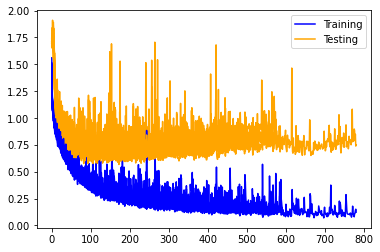

In [21]:
for i, history in enumerate(histories):
    pl.plot(history.history['loss'], label='Training', color="blue")
    pl.plot(history.history['val_loss'], label='Testing', color="orange")
    
    if i == 0:
        pl.legend()
        
    pl.grid()

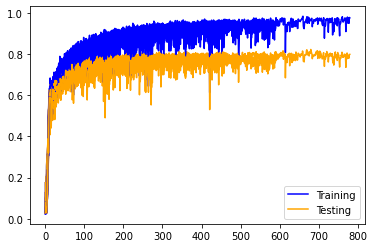

In [22]:
for i, history in enumerate(histories):
    pl.plot(history.history['f1_score_train'], label='Training', color="blue")
    pl.plot(history.history['f1_score_val'], label='Testing', color="orange")
    
    if i == 0:
        pl.legend()
        
    pl.grid()

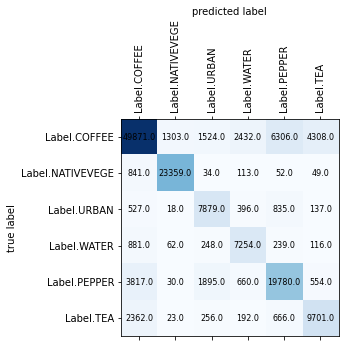

In [23]:
plot_confusion_matrix(conf_matrix, labels)

In [24]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrix)

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.85543491 0.9420851  0.66568097 0.65664886 0.70952005 0.65260679]
Mean precision:  0.746996115717724

Recalls:  [0.75856352 0.95545648 0.80463644 0.82431818 0.73982645 0.73492424]
Mean recall:  0.8029542185899547

F-Score:  [0.80409213 0.94872368 0.72859257 0.73099209 0.72435639 0.69132371]
Mean f-score:  0.7713467609041889
